In [24]:
## remember to run conn_cocolab from the terminal before running cells in this notebook!
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import datetime

import svg_render_helpers as rdh
from scipy.spatial import distance

### file hierarchy and database connection vars

In [2]:
## directory & file hierarchy
iterationName = 'CDM_photodraw_e1'
exp_path = 'photodraw'
analysis_dir = os.getcwd()
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../..','experiments'))
##
sketch_dir = os.path.join(analysis_dir,'sketches_CDM_included_only')
if not os.path.exists(sketch_dir):
    os.makedirs(sketch_dir)

## dir where we can keep all sketches not binned by category    

In [5]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db['CDM_photodraw_e1']


### Preprocessing data and rendering images

Notes:
There are two types of records in the database: 'stroke' and 'finalImage'. This is stored under the key: 'dataType'.
The 'stroke'-type of record contains the svg string information. Every stroke event is stored as a separate record.
The session identifier is called "sessionId".




In [6]:
total_sessions = coll.find().distinct('sessionId') ## this returns ALL sessions in this collection.
print 'We currently have {} total sessions.'.format(len(total_sessions))

We currently have 88 total sessions.


In [7]:
## see  https://docs.google.com/spreadsheets/d/1pZ2MFfAjoT_11ZJQcSAjdeA_ZZvRraTZRqkVBcVIXCM/edit#gid=8551646
## for information on which 
exclude_session_id=['CDM_photodraw_e11532109648493',
'CDM_photodraw_e11532110198274',
'CDM_photodraw_e11532119534231',
'CDM_photodraw_e11532120540660',
'CDM_photodraw_e11532121593015',
'CDM_photodraw_e11532123507785',
'CDM_photodraw_e11532454335609',
'CDM_photodraw_e11532455751579',
'CDM_photodraw_e11532455837908',
'CDM_photodraw_e11532463418268',
'CDM_photodraw_e11532468803382',
'CDM_photodraw_e11532472054977',
'CDM_photodraw_e11532540831557',
'CDM_photodraw_e11532543365329',
'CDM_photodraw_e11532551867786',
'CDM_photodraw_e11532556255130',
'CDM_photodraw_e11532558764161',
'CDM_photodraw_e11533073503103',
'CDM_photodraw_e11533144107489',
'CDM_photodraw_e11533147048549',
'CDM_photodraw_e11532463825380',
'CDM_photodraw_e11532461805013',
'CDM_photodraw_e11532541701592']

In [41]:
really_run_this = 1
if really_run_this:
    
    ## img writing parameters
    imsize = 224
    
    ## desired output: a dataframe that has trials on the rows, and the following columns:
    ## category, age, number of strokes, mean_pixel_intensity, bounding_box_coordinates_LTRB, list of strokes, 
    ## PNG string, submission_time, submission_date
    ## to be saved out as a nice tidy CSV
    session_id = []
    trial_num = []
    category = []
    num_strokes = []
    mean_pixel_intensity = []
    bounding_box_coords = []
    svg = []
    kidName = []
    svg_times = []
    png = []
    submit_time = []
    submit_date = []
    draw_duration = []
    filename = []
    age=[]
    countErr = 0
    condition=[]
    S_num_stroke=[]
    W_num_stroke=[]
    P_num_stroke=[]
    S_time=[]
    W_time=[]
    P_time=[]
    readadble_date = []
    
    ## storke length
    reload(rdh)
    max_stroke_length = []
    min_stroke_length = []
    avg_stroke_length = []
    
    exclude_category = ['this circle','this square','this shape']

    exclude_age = ['age8','age9','age10']
    for s in total_sessions:
        this_collection = coll
        image_recs = this_collection.find({'$and': [{'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')  
        
        for imrec in image_recs:  
                ## if you want to render all sessions
                # if imrec['category'] not in exclude_category:
                
                ## exclude invalid sessions, tracing trials, and old kids just in case our filtering didn't get them.
                if imrec['sessionId'] not in exclude_session_id and imrec['category'] not in exclude_category and imrec['age'] not in exclude_age:
                    stroke_recs = this_collection.find({'$and': [ 
                                                      {'sessionId':s}, 
                                                      {'dataType':'stroke'},
                                                      {'category': imrec['category']}]}).sort('time')   

                    if stroke_recs.count() > 0: ## only include trials if the drawings are not blank            
                        session_id.append(imrec['sessionId'])        
                        trial_num.append(imrec['trialNum']) 
                        category.append(imrec['category'])


                        try:    
                            png.append(imrec['imgData'])
                            submit_time.append(imrec['time'])
                            submit_date.append(imrec['date'])
                            age.append(imrec['age'])
                            condition.append(imrec['condition'])
                            filename.append(os.path.join(sketch_dir,'{}_sketch_{}_{}_{}.png'.format(imrec['category'], imrec['sessionId'], imrec['condition'], imrec['age'])))
                            num_strokes.append(stroke_recs.count())

                            _svg = [] # this keeps track of the strokes from THIS final image
                            _svg_times = []
                            for strec in stroke_recs:
                                _svg.append(strec['svg'])
                                _svg_times.append(strec['time'])
                            draw_duration.append((_svg_times[-1] - _svg_times[0])/1000) ## in seconds
                            svg.append(_svg)
                            svg_times.append(_svg_times)

                            if imrec['condition']=='S':
                                S_num_stroke.append(stroke_recs.count())
                                S_time.append((_svg_times[-1] - _svg_times[0])/1000)
                            elif imrec['condition']=='W':
                                W_num_stroke.append(stroke_recs.count())
                                W_time.append((_svg_times[-1] - _svg_times[0])/1000)
                            elif imrec['condition']=='P':
                                P_num_stroke.append(stroke_recs.count())
                                P_time.append((_svg_times[-1] - _svg_times[0])/1000)
                                
                                
                                
                            ## compute stroke length
                            max_num = 50
                            if stroke_recs.count()> max_num:
                                stroke_recs = stroke_recs[:max_num]
                            
                        
                            ## make an svg list of all strokes
#                             svg_list = rdh.make_svg_list(stroke_recs)
                            svg_list = _svg
                            
                            
                            ## convert all strokes into two lists
                            ## Verts includes vertice infor of each stroke
                            ## Codes includes coordinates infor of each stroke
                            Verts, Codes = rdh.get_verts_and_codes(svg_list)

                            stroke_length_list = []
                            
                            # iterate each stroke
                            for verts in Verts:
                                print 'verts', len(verts)
                                stroke_length = 0

                                # sum the distance between each two continuous vertices
                                for v_index, vertex in enumerate(verts[:-1]):
                                    print 'v', vertex
                                    stroke_length += distance.euclidean(np.array(vertex),np.array(verts[v_index+1]))

                                stroke_length_list.append(stroke_length)
                                print stroke_length

                            max_stroke_length.append(np.max(stroke_length_list))
                            min_stroke_length.append(np.min(stroke_length_list))
                            avg_stroke_length.append(np.average(stroke_length_list))   
                                
                                

                            ## and write out image data here too
                            imgData = imrec['imgData'];
                            filestr = base64.b64decode(imgData)
#                             child_dir = os.path.join(sketch_dir,imrec['condition'],imrec['age'],imrec['sessionId'])
#                             child_dir = os.path.join(sketch_dir,imrec['sessionId'])
                            child_dir = os.path.join(sketch_dir,imrec['condition'])
                            if not os.path.exists(child_dir):
                                os.makedirs(child_dir)
                            fname = os.path.join(child_dir,'{}_sketch_{}_{}_{}.png'.format(imrec['category'],imrec['sessionId'],imrec['condition'], imrec['age']))
                            with open(fname, "wb") as fh:
                                fh.write(imgData.decode('base64'))  
                                
                                
                    
                        except Exception as e:
                            print('something went wrong with an image')
                            print e
                            countErr = countErr + 1
                            print imrec['category']
                            child_dir = os.path.join(sketch_dir,'noname')
                            if not os.path.exists(child_dir):
                                os.makedirs(child_dir)
                            fname = os.path.join(child_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], 'noname',imrec['sessionId']))
                            with open(fname, "wb") as fh:
                                fh.write(imgData.decode('base64'))  
                        

('svg_list', [u'M199.71875,196.51563v7v1v2v1v2l1,2l1,2v2l1,3l1,3l1,2l1,4l1,4l1,4l1,5v4l1,5v5v4v5v4v3v4v3v3v3v3v3v4v4l-1,4v4v3l-1,4v2l-1,3v2v2v2l-1,2v3l-1,2v2l-1,2v2v1l-1,3v2v1v2l-1,2v2v1l-1,2v2l-1,1v1l-1,2v1v1v2l-1,1v1v2v1l-1,2v1v1v1v2v2v1v1v1l-1,1v1v2v1v1v1v2v1v1v1v2v1v2v1v2v1v1v2v1v1v2v2v1v2v1v2v2v1v2v2v2v2l1,2v3v2v2l1,3v2l1,2v2v2l1,1v2l1,1v1l1,1v1v1v1l1,2v1l1,1v1v1v1l1,1v1v1l1,1v1h1v1l1,1l1,1h1h1v1h1h1h1h1h1h2h1h2h1h1h2h1h1h1h1h1h1h2h2h1h1h1h1h1h2h1h1h1h2h1h2h2h1h2h1h1h2h1h2h1h2h2h1h2l1,1h2h1h2l2,1h2h1l2,1h3h2h2h3h2h3h2h2h3h3h2h3h3h3h3h3h3h3h2h3h2h3l2,-1l2,-1h3l2,-1h2h2h2h2l1,-1h2h2l1,-1h1h2h2l1,-1h2h1l2,-1h1l2,-1h1h1h2h1h1l2,-1h1h2l2,-1h1h2h2h1h2h2h1h2l2,-1h1h2h2l2,-1h2h2l2,-1h2h2h3h2l2,-1h2h3l2,-1h3h2h2l2,-1h1l2,-1h2h1h1l1,-1h2h1l2,-1h1h2h2l1,-1h2h2l1,-1h2l1,-1h1h2v-1h2v-1h2l1,-1h2h1l2,-1h2l1,-1h1l2,-1l1,-1l1,-1h1v-1l1,-1l1,-1v-1l1,-1l1,-1v-1l1,-1v-1v-1v-2v-1v-1v-1v-1v-1v-1v-1v-1v-2v-1v-1v-2v-2v-2v-2v-3v-4v-4l-1,-4v-4v-3v-4v-3l-1,-4v-3v-4v-3v-4l-1,-3v-5v-4l-1,-5v-4l-1,-5v-4v-5l-1,

v (167.71875, 141.51563)
v (163.71875, 142.51563)
v (160.71875, 143.51563)
v (158.71875, 144.51563)
v (155.71875, 145.51563)
v (152.71875, 147.51563)
v (149.71875, 148.51563)
v (146.71875, 150.51563)
v (143.71875, 152.51563)
v (141.71875, 154.51563)
v (138.71875, 156.51563)
v (134.71875, 159.51563)
v (131.71875, 162.51563)
v (128.71875, 165.51563)
v (124.71875, 169.51563)
v (121.71875, 172.51563)
v (118.71875, 177.51563)
v (114.71875, 181.51563)
v (111.71875, 185.51563)
v (107.71875, 190.51563)
v (105.71875, 195.51563)
v (102.71875, 200.51563)
v (99.71875, 205.51563)
v (96.71875, 210.51563)
v (94.71875, 216.51563)
v (92.71875, 221.51563)
v (89.71875, 226.51563)
v (87.71875, 231.51563)
v (85.71875, 238.51563)
v (83.71875, 243.51563)
v (82.71875, 248.51563)
v (80.71875, 255.51563)
v (79.71875, 261.51563)
v (78.71875, 266.51563)
v (78.71875, 273.51563)
v (78.71875, 280.51563)
v (78.71875, 286.51563)
v (78.71875, 294.51563)
v (78.71875, 300.51563)
v (79.71875, 306.51563)
v (81.71875, 313.5

v (262.71875, 176.51563)
v (257.71875, 168.51563)
v (253.71875, 162.51563)
v (248.71875, 155.51563)
v (244.71875, 148.51563)
v (239.71875, 143.51563)
v (235.71875, 138.51563)
v (231.71875, 134.51563)
v (227.71875, 131.51563)
v (224.71875, 128.51563)
v (220.71875, 126.51562999999999)
v (218.71875, 125.51562999999999)
v (215.71875, 124.51562999999999)
v (213.71875, 124.51562999999999)
v (211.71875, 124.51562999999999)
v (210.71875, 124.51562999999999)
v (209.71875, 124.51562999999999)
v (208.71875, 124.51562999999999)
v (210.71875, 124.51562999999999)
v (151.71875, 226.51563)
v (145.71875, 216.51563)
v (145.71875, 217.51563)
v (146.71875, 217.51563)
v (147.71875, 217.51563)
v (148.71875, 217.51563)
v (149.71875, 217.51563)
v (150.71875, 217.51563)
v (151.71875, 216.51563)
v (151.71875, 215.51563)
834.37545107
verts 143
v (211.71875, 143.51563)
v (204.71875, 138.51563)
v (202.71875, 138.51563)
v (200.71875, 138.51563)
v (198.71875, 138.51563)
v (196.71875, 138.51563)
v (194.71875, 138.515

v (470.71875, 439.51563)
v (470.71875, 438.51563)
v (470.71875, 437.51563)
v (470.71875, 436.51563)
v (470.71875, 435.51563)
v (469.71875, 434.51563)
v (469.71875, 433.51563)
v (469.71875, 432.51563)
v (469.71875, 431.51563)
v (468.71875, 430.51563)
v (468.71875, 429.51563)
v (468.71875, 428.51563)
v (467.71875, 427.51563)
v (467.71875, 426.51563)
v (467.71875, 425.51563)
v (467.71875, 424.51563)
v (467.71875, 423.51563)
v (467.71875, 422.51563)
v (467.71875, 421.51563)
v (467.71875, 420.51563)
v (467.71875, 419.51563)
v (466.71875, 418.51563)
v (466.71875, 417.51563)
v (466.71875, 416.51563)
v (466.71875, 415.51563)
v (465.71875, 415.51563)
v (465.71875, 414.51563)
v (465.71875, 413.51563)
v (465.71875, 412.51563)
v (464.71875, 411.51563)
v (464.71875, 410.51563)
v (464.71875, 409.51563)
v (463.71875, 408.51563)
v (463.71875, 407.51563)
v (463.71875, 406.51563)
v (462.71875, 405.51563)
v (461.71875, 405.51563)
v (461.71875, 404.51563)
v (460.71875, 403.51563)
v (460.71875, 402.51563)


v (469.71875, 433.51563)
v (469.71875, 432.51563)
v (469.71875, 431.51563)
v (468.71875, 430.51563)
v (468.71875, 429.51563)
v (468.71875, 428.51563)
v (467.71875, 427.51563)
v (467.71875, 426.51563)
v (467.71875, 425.51563)
v (467.71875, 424.51563)
v (467.71875, 423.51563)
v (467.71875, 422.51563)
v (467.71875, 421.51563)
v (467.71875, 420.51563)
v (467.71875, 419.51563)
v (466.71875, 418.51563)
v (466.71875, 417.51563)
v (466.71875, 416.51563)
v (466.71875, 415.51563)
v (465.71875, 415.51563)
v (465.71875, 414.51563)
v (465.71875, 413.51563)
v (465.71875, 412.51563)
v (464.71875, 411.51563)
v (464.71875, 410.51563)
v (464.71875, 409.51563)
v (463.71875, 408.51563)
v (463.71875, 407.51563)
v (463.71875, 406.51563)
v (462.71875, 405.51563)
v (461.71875, 405.51563)
v (461.71875, 404.51563)
v (460.71875, 403.51563)
v (460.71875, 402.51563)
v (459.71875, 402.51563)
v (458.71875, 401.51563)
v (457.71875, 400.51563)
v (456.71875, 399.51563)
v (455.71875, 398.51563)
v (453.71875, 397.51563)


v (448.71875, 394.51563)
v (447.71875, 393.51563)
v (446.71875, 393.51563)
v (444.71875, 392.51563)
v (443.71875, 392.51563)
v (442.71875, 391.51563)
v (441.71875, 391.51563)
v (440.71875, 391.51563)
v (439.71875, 390.51563)
v (437.71875, 390.51563)
v (435.71875, 389.51563)
v (434.71875, 388.51563)
v (431.71875, 388.51563)
v (429.71875, 388.51563)
v (427.71875, 387.51563)
v (424.71875, 386.51563)
v (422.71875, 386.51563)
v (419.71875, 386.51563)
v (415.71875, 385.51563)
v (412.71875, 385.51563)
v (407.71875, 385.51563)
v (403.71875, 385.51563)
v (399.71875, 384.51563)
v (395.71875, 384.51563)
v (391.71875, 384.51563)
v (386.71875, 384.51563)
v (382.71875, 384.51563)
v (378.71875, 384.51563)
v (374.71875, 384.51563)
v (369.71875, 384.51563)
v (364.71875, 384.51563)
v (360.71875, 384.51563)
v (355.71875, 384.51563)
v (351.71875, 384.51563)
v (346.71875, 385.51563)
v (341.71875, 385.51563)
v (336.71875, 386.51563)
v (331.71875, 386.51563)
v (326.71875, 387.51563)
v (321.71875, 388.51563)


v (466.71875, 415.51563)
v (465.71875, 415.51563)
v (465.71875, 414.51563)
v (465.71875, 413.51563)
v (465.71875, 412.51563)
v (464.71875, 411.51563)
v (464.71875, 410.51563)
v (464.71875, 409.51563)
v (463.71875, 408.51563)
v (463.71875, 407.51563)
v (463.71875, 406.51563)
v (462.71875, 405.51563)
v (461.71875, 405.51563)
v (461.71875, 404.51563)
v (460.71875, 403.51563)
v (460.71875, 402.51563)
v (459.71875, 402.51563)
v (458.71875, 401.51563)
v (457.71875, 400.51563)
v (456.71875, 399.51563)
v (455.71875, 398.51563)
v (453.71875, 397.51563)
v (452.71875, 396.51563)
v (451.71875, 396.51563)
v (450.71875, 395.51563)
v (449.71875, 394.51563)
v (448.71875, 394.51563)
v (447.71875, 393.51563)
v (446.71875, 393.51563)
v (444.71875, 392.51563)
v (443.71875, 392.51563)
v (442.71875, 391.51563)
v (441.71875, 391.51563)
v (440.71875, 391.51563)
v (439.71875, 390.51563)
v (437.71875, 390.51563)
v (435.71875, 389.51563)
v (434.71875, 388.51563)
v (431.71875, 388.51563)
v (429.71875, 388.51563)


v (150.71875, 164.51563)
v (150.71875, 166.51563)
v (150.71875, 168.51563)
v (150.71875, 171.51563)
v (150.71875, 173.51563)
v (150.71875, 176.51563)
v (150.71875, 179.51563)
v (150.71875, 183.51563)
v (150.71875, 187.51563)
v (150.71875, 192.51563)
v (150.71875, 197.51563)
v (150.71875, 201.51563)
v (150.71875, 206.51563)
v (150.71875, 211.51563)
v (151.71875, 216.51563)
v (151.71875, 221.51563)
v (151.71875, 227.51563)
v (151.71875, 232.51563)
v (151.71875, 237.51563)
v (151.71875, 242.51563)
v (151.71875, 247.51563)
v (151.71875, 252.51563)
v (152.71875, 256.51563)
v (152.71875, 261.51563)
v (152.71875, 265.51563)
v (152.71875, 269.51563)
v (153.71875, 274.51563)
v (153.71875, 279.51563)
v (153.71875, 283.51563)
v (154.71875, 287.51563)
v (155.71875, 292.51563)
v (155.71875, 296.51563)
v (156.71875, 301.51563)
v (156.71875, 304.51563)
v (157.71875, 308.51563)
v (158.71875, 312.51563)
v (158.71875, 315.51563)
v (159.71875, 319.51563)
v (160.71875, 322.51563)
v (160.71875, 325.51563)


v (293.71875, 436.51563)
v (297.71875, 435.51563)
v (301.71875, 435.51563)
v (305.71875, 435.51563)
v (309.71875, 434.51563)
v (313.71875, 434.51563)
v (316.71875, 433.51563)
v (320.71875, 433.51563)
v (324.71875, 432.51563)
v (328.71875, 432.51563)
v (331.71875, 431.51563)
v (335.71875, 430.51563)
v (338.71875, 428.51563)
v (342.71875, 427.51563)
v (346.71875, 425.51563)
v (350.71875, 423.51563)
v (354.71875, 421.51563)
v (358.71875, 419.51563)
v (362.71875, 417.51563)
v (368.71875, 413.51563)
v (372.71875, 410.51563)
v (378.71875, 406.51563)
v (383.71875, 401.51563)
v (388.71875, 396.51563)
v (393.71875, 391.51563)
v (398.71875, 385.51563)
v (402.71875, 381.51563)
v (405.71875, 376.51563)
v (407.71875, 372.51563)
v (410.71875, 369.51563)
v (411.71875, 365.51563)
v (412.71875, 362.51563)
v (413.71875, 359.51563)
v (414.71875, 356.51563)
v (415.71875, 353.51563)
v (415.71875, 350.51563)
v (416.71875, 346.51563)
v (416.71875, 341.51563)
v (417.71875, 336.51563)
v (418.71875, 330.51563)


v (191.71875, 290.51563)
v (191.71875, 287.51563)
v (191.71875, 285.51563)
v (191.71875, 283.51563)
v (192.71875, 281.51563)
v (192.71875, 279.51563)
v (193.71875, 277.51563)
v (193.71875, 274.51563)
v (194.71875, 272.51563)
v (194.71875, 270.51563)
v (194.71875, 268.51563)
v (194.71875, 266.51563)
v (194.71875, 264.51563)
v (194.71875, 262.51563)
v (194.71875, 260.51563)
v (194.71875, 257.51563)
v (194.71875, 256.51563)
v (195.71875, 254.51563)
v (196.71875, 252.51563)
v (196.71875, 251.51563)
v (197.71875, 249.51563)
v (198.71875, 247.51563)
v (198.71875, 246.51563)
v (199.71875, 245.51563)
v (200.71875, 243.51563)
v (200.71875, 241.51563)
v (200.71875, 240.51563)
v (201.71875, 238.51563)
v (201.71875, 236.51563)
v (201.71875, 234.51563)
v (201.71875, 233.51563)
v (201.71875, 231.51563)
v (201.71875, 229.51563)
v (201.71875, 227.51563)
v (201.71875, 225.51563)
v (201.71875, 223.51563)
v (201.71875, 222.51563)
v (202.71875, 221.51563)
v (202.71875, 219.51563)
v (202.71875, 218.51563)


v (498.71875, 254.51563)
v (498.71875, 255.51563)
v (498.71875, 257.51563)
v (498.71875, 259.51563)
v (499.71875, 260.51563)
v (499.71875, 261.51563)
v (499.71875, 262.51563)
v (499.71875, 263.51563)
v (499.71875, 265.51563)
v (499.71875, 266.51563)
v (499.71875, 268.51563)
v (499.71875, 269.51563)
v (499.71875, 272.51563)
v (499.71875, 273.51563)
v (499.71875, 276.51563)
v (499.71875, 277.51563)
v (499.71875, 280.51563)
v (499.71875, 282.51563)
v (499.71875, 284.51563)
v (499.71875, 286.51563)
v (499.71875, 288.51563)
v (499.71875, 290.51563)
v (499.71875, 293.51563)
v (499.71875, 295.51563)
v (498.71875, 297.51563)
v (498.71875, 299.51563)
v (497.71875, 301.51563)
v (497.71875, 303.51563)
v (496.71875, 305.51563)
v (496.71875, 307.51563)
v (496.71875, 309.51563)
v (495.71875, 312.51563)
v (495.71875, 314.51563)
v (494.71875, 316.51563)
v (494.71875, 318.51563)
v (494.71875, 320.51563)
v (494.71875, 323.51563)
v (494.71875, 324.51563)
v (493.71875, 326.51563)
v (493.71875, 328.51563)


v (205.71875, 373.51563)
v (204.71875, 370.51563)
v (203.71875, 367.51563)
v (203.71875, 363.51563)
v (202.71875, 360.51563)
v (201.71875, 357.51563)
v (201.71875, 353.51563)
v (200.71875, 350.51563)
v (198.71875, 346.51563)
v (198.71875, 342.51563)
v (196.71875, 339.51563)
v (196.71875, 335.51563)
v (194.71875, 331.51563)
v (194.71875, 328.51563)
v (193.71875, 324.51563)
v (192.71875, 320.51563)
v (192.71875, 316.51563)
v (191.71875, 313.51563)
v (191.71875, 310.51563)
v (191.71875, 307.51563)
v (191.71875, 303.51563)
v (191.71875, 301.51563)
v (191.71875, 298.51563)
v (191.71875, 295.51563)
v (191.71875, 292.51563)
v (191.71875, 290.51563)
v (191.71875, 287.51563)
v (191.71875, 285.51563)
v (191.71875, 283.51563)
v (192.71875, 281.51563)
v (192.71875, 279.51563)
v (193.71875, 277.51563)
v (193.71875, 274.51563)
v (194.71875, 272.51563)
v (194.71875, 270.51563)
v (194.71875, 268.51563)
v (194.71875, 266.51563)
v (194.71875, 264.51563)
v (194.71875, 262.51563)
v (194.71875, 260.51563)


v (363.71875, 194.51563)
v (367.71875, 193.51563)
v (370.71875, 193.51563)
v (374.71875, 193.51563)
v (377.71875, 193.51563)
v (381.71875, 193.51563)
v (385.71875, 193.51563)
v (388.71875, 193.51563)
v (391.71875, 193.51563)
v (395.71875, 193.51563)
v (398.71875, 193.51563)
v (401.71875, 193.51563)
v (405.71875, 193.51563)
v (407.71875, 193.51563)
v (411.71875, 193.51563)
v (414.71875, 193.51563)
v (416.71875, 193.51563)
v (419.71875, 193.51563)
v (421.71875, 194.51563)
v (423.71875, 194.51563)
v (425.71875, 194.51563)
v (427.71875, 194.51563)
v (429.71875, 195.51563)
v (430.71875, 195.51563)
v (432.71875, 195.51563)
v (434.71875, 196.51563)
v (436.71875, 196.51563)
v (437.71875, 196.51563)
v (439.71875, 197.51563)
v (441.71875, 197.51563)
v (442.71875, 198.51563)
v (444.71875, 198.51563)
v (445.71875, 199.51563)
v (446.71875, 199.51563)
v (448.71875, 199.51563)
v (450.71875, 199.51563)
v (451.71875, 200.51563)
v (452.71875, 200.51563)
v (453.71875, 201.51563)
v (455.71875, 201.51563)


v (469.71875, 446.51563)
v (469.71875, 448.51563)
v (469.71875, 449.51563)
v (468.71875, 450.51563)
v (468.71875, 452.51563)
v (468.71875, 453.51563)
v (467.71875, 454.51563)
v (467.71875, 455.51563)
v (467.71875, 457.51563)
v (466.71875, 458.51563)
v (465.71875, 459.51563)
v (465.71875, 460.51563)
v (464.71875, 461.51563)
v (464.71875, 462.51563)
v (463.71875, 464.51563)
v (463.71875, 466.51563)
v (462.71875, 467.51563)
v (461.71875, 468.51563)
v (461.71875, 469.51563)
v (460.71875, 470.51563)
v (460.71875, 471.51563)
v (460.71875, 473.51563)
v (459.71875, 474.51563)
v (459.71875, 475.51563)
v (459.71875, 476.51563)
v (458.71875, 478.51563)
v (458.71875, 480.51563)
v (457.71875, 481.51563)
v (457.71875, 482.51563)
v (456.71875, 483.51563)
v (456.71875, 484.51563)
v (455.71875, 485.51563)
v (455.71875, 486.51563)
v (454.71875, 487.51563)
v (453.71875, 488.51563)
v (453.71875, 489.51563)
v (452.71875, 490.51563)
v (451.71875, 491.51563)
v (450.71875, 491.51563)
v (449.71875, 492.51563)


v (226.71875, 185.51563)
v (227.71875, 185.51563)
v (229.71875, 185.51563)
v (230.71875, 186.51563)
v (231.71875, 186.51563)
v (232.71875, 186.51563)
v (234.71875, 186.51563)
v (237.71875, 186.51563)
v (239.71875, 186.51563)
v (242.71875, 187.51563)
v (244.71875, 187.51563)
v (247.71875, 187.51563)
v (250.71875, 188.51563)
v (252.71875, 188.51563)
v (255.71875, 189.51563)
v (258.71875, 190.51563)
v (262.71875, 190.51563)
v (265.71875, 191.51563)
v (268.71875, 192.51563)
v (272.71875, 192.51563)
v (276.71875, 193.51563)
v (280.71875, 193.51563)
v (283.71875, 194.51563)
v (287.71875, 194.51563)
v (291.71875, 194.51563)
v (295.71875, 195.51563)
v (299.71875, 195.51563)
v (302.71875, 196.51563)
v (306.71875, 196.51563)
v (309.71875, 196.51563)
v (312.71875, 196.51563)
v (316.71875, 196.51563)
v (319.71875, 196.51563)
v (322.71875, 196.51563)
v (325.71875, 196.51563)
v (328.71875, 196.51563)
v (332.71875, 195.51563)
v (335.71875, 194.51563)
v (339.71875, 194.51563)
v (342.71875, 194.51563)


v (493.71875, 239.51563)
v (494.71875, 241.51563)
v (495.71875, 243.51563)
v (496.71875, 245.51563)
v (496.71875, 246.51563)
v (497.71875, 247.51563)
v (497.71875, 249.51563)
v (498.71875, 250.51563)
v (498.71875, 252.51563)
v (498.71875, 253.51563)
v (498.71875, 254.51563)
v (498.71875, 255.51563)
v (498.71875, 257.51563)
v (498.71875, 259.51563)
v (499.71875, 260.51563)
v (499.71875, 261.51563)
v (499.71875, 262.51563)
v (499.71875, 263.51563)
v (499.71875, 265.51563)
v (499.71875, 266.51563)
v (499.71875, 268.51563)
v (499.71875, 269.51563)
v (499.71875, 272.51563)
v (499.71875, 273.51563)
v (499.71875, 276.51563)
v (499.71875, 277.51563)
v (499.71875, 280.51563)
v (499.71875, 282.51563)
v (499.71875, 284.51563)
v (499.71875, 286.51563)
v (499.71875, 288.51563)
v (499.71875, 290.51563)
v (499.71875, 293.51563)
v (499.71875, 295.51563)
v (498.71875, 297.51563)
v (498.71875, 299.51563)
v (497.71875, 301.51563)
v (497.71875, 303.51563)
v (496.71875, 305.51563)
v (496.71875, 307.51563)


v (457.71875, 481.51563)
v (457.71875, 482.51563)
v (456.71875, 483.51563)
v (456.71875, 484.51563)
v (455.71875, 485.51563)
v (455.71875, 486.51563)
v (454.71875, 487.51563)
v (453.71875, 488.51563)
v (453.71875, 489.51563)
v (452.71875, 490.51563)
v (451.71875, 491.51563)
v (450.71875, 491.51563)
v (449.71875, 492.51563)
v (448.71875, 493.51563)
v (447.71875, 493.51563)
v (446.71875, 493.51563)
v (445.71875, 494.51563)
v (443.71875, 494.51563)
v (442.71875, 494.51563)
v (441.71875, 494.51563)
v (439.71875, 494.51563)
v (437.71875, 494.51563)
v (435.71875, 494.51563)
v (432.71875, 494.51563)
v (429.71875, 493.51563)
v (427.71875, 492.51563)
v (423.71875, 490.51563)
v (419.71875, 488.51563)
v (416.71875, 486.51563)
v (412.71875, 484.51563)
v (408.71875, 483.51563)
v (405.71875, 481.51563)
v (401.71875, 479.51563)
v (398.71875, 478.51563)
v (395.71875, 477.51563)
v (392.71875, 476.51563)
v (388.71875, 475.51563)
v (385.71875, 474.51563)
v (381.71875, 473.51563)
v (378.71875, 472.51563)


v (325.71875, 196.51563)
v (328.71875, 196.51563)
v (332.71875, 195.51563)
v (335.71875, 194.51563)
v (339.71875, 194.51563)
v (342.71875, 194.51563)
v (345.71875, 194.51563)
v (349.71875, 194.51563)
v (352.71875, 194.51563)
v (356.71875, 194.51563)
v (359.71875, 194.51563)
v (363.71875, 194.51563)
v (367.71875, 193.51563)
v (370.71875, 193.51563)
v (374.71875, 193.51563)
v (377.71875, 193.51563)
v (381.71875, 193.51563)
v (385.71875, 193.51563)
v (388.71875, 193.51563)
v (391.71875, 193.51563)
v (395.71875, 193.51563)
v (398.71875, 193.51563)
v (401.71875, 193.51563)
v (405.71875, 193.51563)
v (407.71875, 193.51563)
v (411.71875, 193.51563)
v (414.71875, 193.51563)
v (416.71875, 193.51563)
v (419.71875, 193.51563)
v (421.71875, 194.51563)
v (423.71875, 194.51563)
v (425.71875, 194.51563)
v (427.71875, 194.51563)
v (429.71875, 195.51563)
v (430.71875, 195.51563)
v (432.71875, 195.51563)
v (434.71875, 196.51563)
v (436.71875, 196.51563)
v (437.71875, 196.51563)
v (439.71875, 197.51563)


v (492.71875, 238.51563)
v (493.71875, 239.51563)
v (494.71875, 241.51563)
v (495.71875, 243.51563)
v (496.71875, 245.51563)
v (496.71875, 246.51563)
v (497.71875, 247.51563)
v (497.71875, 249.51563)
v (498.71875, 250.51563)
v (498.71875, 252.51563)
v (498.71875, 253.51563)
v (498.71875, 254.51563)
v (498.71875, 255.51563)
v (498.71875, 257.51563)
v (498.71875, 259.51563)
v (499.71875, 260.51563)
v (499.71875, 261.51563)
v (499.71875, 262.51563)
v (499.71875, 263.51563)
v (499.71875, 265.51563)
v (499.71875, 266.51563)
v (499.71875, 268.51563)
v (499.71875, 269.51563)
v (499.71875, 272.51563)
v (499.71875, 273.51563)
v (499.71875, 276.51563)
v (499.71875, 277.51563)
v (499.71875, 280.51563)
v (499.71875, 282.51563)
v (499.71875, 284.51563)
v (499.71875, 286.51563)
v (499.71875, 288.51563)
v (499.71875, 290.51563)
v (499.71875, 293.51563)
v (499.71875, 295.51563)
v (498.71875, 297.51563)
v (498.71875, 299.51563)
v (497.71875, 301.51563)
v (497.71875, 303.51563)
v (496.71875, 305.51563)


v (498.71875, 254.51563)
v (498.71875, 255.51563)
v (498.71875, 257.51563)
v (498.71875, 259.51563)
v (499.71875, 260.51563)
v (499.71875, 261.51563)
v (499.71875, 262.51563)
v (499.71875, 263.51563)
v (499.71875, 265.51563)
v (499.71875, 266.51563)
v (499.71875, 268.51563)
v (499.71875, 269.51563)
v (499.71875, 272.51563)
v (499.71875, 273.51563)
v (499.71875, 276.51563)
v (499.71875, 277.51563)
v (499.71875, 280.51563)
v (499.71875, 282.51563)
v (499.71875, 284.51563)
v (499.71875, 286.51563)
v (499.71875, 288.51563)
v (499.71875, 290.51563)
v (499.71875, 293.51563)
v (499.71875, 295.51563)
v (498.71875, 297.51563)
v (498.71875, 299.51563)
v (497.71875, 301.51563)
v (497.71875, 303.51563)
v (496.71875, 305.51563)
v (496.71875, 307.51563)
v (496.71875, 309.51563)
v (495.71875, 312.51563)
v (495.71875, 314.51563)
v (494.71875, 316.51563)
v (494.71875, 318.51563)
v (494.71875, 320.51563)
v (494.71875, 323.51563)
v (494.71875, 324.51563)
v (493.71875, 326.51563)
v (493.71875, 328.51563)


v (203.71875, 200.51563)
v (204.71875, 199.51563)
v (205.71875, 198.51563)
v (205.71875, 197.51563)
v (205.71875, 196.51563)
v (206.71875, 196.51563)
v (206.71875, 195.51563)
v (207.71875, 194.51563)
v (208.71875, 193.51563)
v (208.71875, 192.51563)
v (208.71875, 190.51563)
v (208.71875, 189.51563)
v (208.71875, 188.51563)
v (209.71875, 187.51563)
v (209.71875, 186.51563)
v (210.71875, 185.51563)
v (210.71875, 184.51563)
v (211.71875, 184.51563)
v (212.71875, 184.51563)
v (213.71875, 183.51563)
v (214.71875, 183.51563)
v (215.71875, 183.51563)
v (217.71875, 183.51563)
v (218.71875, 183.51563)
v (219.71875, 183.51563)
v (220.71875, 183.51563)
v (221.71875, 183.51563)
v (222.71875, 183.51563)
v (223.71875, 184.51563)
v (225.71875, 184.51563)
v (226.71875, 185.51563)
v (227.71875, 185.51563)
v (229.71875, 185.51563)
v (230.71875, 186.51563)
v (231.71875, 186.51563)
v (232.71875, 186.51563)
v (234.71875, 186.51563)
v (237.71875, 186.51563)
v (239.71875, 186.51563)
v (242.71875, 187.51563)


v (252.71875, 188.51563)
v (255.71875, 189.51563)
v (258.71875, 190.51563)
v (262.71875, 190.51563)
v (265.71875, 191.51563)
v (268.71875, 192.51563)
v (272.71875, 192.51563)
v (276.71875, 193.51563)
v (280.71875, 193.51563)
v (283.71875, 194.51563)
v (287.71875, 194.51563)
v (291.71875, 194.51563)
v (295.71875, 195.51563)
v (299.71875, 195.51563)
v (302.71875, 196.51563)
v (306.71875, 196.51563)
v (309.71875, 196.51563)
v (312.71875, 196.51563)
v (316.71875, 196.51563)
v (319.71875, 196.51563)
v (322.71875, 196.51563)
v (325.71875, 196.51563)
v (328.71875, 196.51563)
v (332.71875, 195.51563)
v (335.71875, 194.51563)
v (339.71875, 194.51563)
v (342.71875, 194.51563)
v (345.71875, 194.51563)
v (349.71875, 194.51563)
v (352.71875, 194.51563)
v (356.71875, 194.51563)
v (359.71875, 194.51563)
v (363.71875, 194.51563)
v (367.71875, 193.51563)
v (370.71875, 193.51563)
v (374.71875, 193.51563)
v (377.71875, 193.51563)
v (381.71875, 193.51563)
v (385.71875, 193.51563)
v (388.71875, 193.51563)


v (437.71875, 494.51563)
v (435.71875, 494.51563)
v (432.71875, 494.51563)
v (429.71875, 493.51563)
v (427.71875, 492.51563)
v (423.71875, 490.51563)
v (419.71875, 488.51563)
v (416.71875, 486.51563)
v (412.71875, 484.51563)
v (408.71875, 483.51563)
v (405.71875, 481.51563)
v (401.71875, 479.51563)
v (398.71875, 478.51563)
v (395.71875, 477.51563)
v (392.71875, 476.51563)
v (388.71875, 475.51563)
v (385.71875, 474.51563)
v (381.71875, 473.51563)
v (378.71875, 472.51563)
v (374.71875, 471.51563)
v (371.71875, 470.51563)
v (369.71875, 469.51563)
v (366.71875, 469.51563)
v (363.71875, 468.51563)
v (360.71875, 467.51563)
v (358.71875, 467.51563)
v (356.71875, 466.51563)
v (354.71875, 466.51563)
v (352.71875, 466.51563)
v (350.71875, 466.51563)
v (348.71875, 466.51563)
v (347.71875, 466.51563)
v (345.71875, 466.51563)
v (343.71875, 466.51563)
v (341.71875, 466.51563)
v (339.71875, 467.51563)
v (337.71875, 467.51563)
v (335.71875, 468.51563)
v (333.71875, 468.51563)
v (331.71875, 469.51563)


v (277.71875, 473.51563)
v (275.71875, 473.51563)
v (274.71875, 473.51563)
v (272.71875, 473.51563)
v (271.71875, 473.51563)
v (270.71875, 473.51563)
v (268.71875, 473.51563)
v (267.71875, 473.51563)
v (266.71875, 473.51563)
v (265.71875, 472.51563)
v (264.71875, 471.51563)
v (264.71875, 471.51563)
v (263.71875, 471.51563)
v (263.71875, 470.51563)
v (263.71875, 469.51563)
v (262.71875, 467.51563)
v (399.71875, 237.51563)
v (399.71875, 237.51563)
v (396.71875, 231.51563)
v (393.71875, 224.51563)
v (393.71875, 222.51563)
v (393.71875, 222.51563)
v (210.71875, 422.51563)
v (213.71875, 415.51563)
v (213.71875, 413.51563)
v (213.71875, 411.51563)
v (213.71875, 408.51563)
v (212.71875, 405.51563)
v (212.71875, 402.51563)
v (211.71875, 399.51563)
v (210.71875, 396.51563)
v (209.71875, 393.51563)
v (208.71875, 390.51563)
v (208.71875, 387.51563)
v (207.71875, 384.51563)
v (206.71875, 382.51563)
v (206.71875, 379.51563)
v (206.71875, 376.51563)
v (205.71875, 373.51563)
v (204.71875, 370.51563)


v (452.71875, 490.51563)
v (451.71875, 491.51563)
v (450.71875, 491.51563)
v (449.71875, 492.51563)
v (448.71875, 493.51563)
v (447.71875, 493.51563)
v (446.71875, 493.51563)
v (445.71875, 494.51563)
v (443.71875, 494.51563)
v (442.71875, 494.51563)
v (441.71875, 494.51563)
v (439.71875, 494.51563)
v (437.71875, 494.51563)
v (435.71875, 494.51563)
v (432.71875, 494.51563)
v (429.71875, 493.51563)
v (427.71875, 492.51563)
v (423.71875, 490.51563)
v (419.71875, 488.51563)
v (416.71875, 486.51563)
v (412.71875, 484.51563)
v (408.71875, 483.51563)
v (405.71875, 481.51563)
v (401.71875, 479.51563)
v (398.71875, 478.51563)
v (395.71875, 477.51563)
v (392.71875, 476.51563)
v (388.71875, 475.51563)
v (385.71875, 474.51563)
v (381.71875, 473.51563)
v (378.71875, 472.51563)
v (374.71875, 471.51563)
v (371.71875, 470.51563)
v (369.71875, 469.51563)
v (366.71875, 469.51563)
v (363.71875, 468.51563)
v (360.71875, 467.51563)
v (358.71875, 467.51563)
v (356.71875, 466.51563)
v (354.71875, 466.51563)


v (492.71875, 238.51563)
v (493.71875, 239.51563)
v (494.71875, 241.51563)
v (495.71875, 243.51563)
v (496.71875, 245.51563)
v (496.71875, 246.51563)
v (497.71875, 247.51563)
v (497.71875, 249.51563)
v (498.71875, 250.51563)
v (498.71875, 252.51563)
v (498.71875, 253.51563)
v (498.71875, 254.51563)
v (498.71875, 255.51563)
v (498.71875, 257.51563)
v (498.71875, 259.51563)
v (499.71875, 260.51563)
v (499.71875, 261.51563)
v (499.71875, 262.51563)
v (499.71875, 263.51563)
v (499.71875, 265.51563)
v (499.71875, 266.51563)
v (499.71875, 268.51563)
v (499.71875, 269.51563)
v (499.71875, 272.51563)
v (499.71875, 273.51563)
v (499.71875, 276.51563)
v (499.71875, 277.51563)
v (499.71875, 280.51563)
v (499.71875, 282.51563)
v (499.71875, 284.51563)
v (499.71875, 286.51563)
v (499.71875, 288.51563)
v (499.71875, 290.51563)
v (499.71875, 293.51563)
v (499.71875, 295.51563)
v (498.71875, 297.51563)
v (498.71875, 299.51563)
v (497.71875, 301.51563)
v (497.71875, 303.51563)
v (496.71875, 305.51563)


v (327.71875, 470.51563)
v (326.71875, 471.51563)
v (324.71875, 471.51563)
v (322.71875, 471.51563)
v (321.71875, 472.51563)
v (319.71875, 472.51563)
v (317.71875, 473.51563)
v (316.71875, 473.51563)
v (314.71875, 473.51563)
v (313.71875, 473.51563)
v (311.71875, 473.51563)
v (310.71875, 473.51563)
v (308.71875, 473.51563)
v (307.71875, 473.51563)
v (305.71875, 473.51563)
v (304.71875, 473.51563)
v (302.71875, 473.51563)
v (301.71875, 473.51563)
v (299.71875, 473.51563)
v (298.71875, 473.51563)
v (296.71875, 473.51563)
v (294.71875, 473.51563)
v (292.71875, 473.51563)
v (290.71875, 473.51563)
v (288.71875, 473.51563)
v (287.71875, 473.51563)
v (285.71875, 473.51563)
v (283.71875, 473.51563)
v (281.71875, 473.51563)
v (279.71875, 473.51563)
v (277.71875, 473.51563)
v (275.71875, 473.51563)
v (274.71875, 473.51563)
v (272.71875, 473.51563)
v (271.71875, 473.51563)
v (270.71875, 473.51563)
v (268.71875, 473.51563)
v (267.71875, 473.51563)
v (266.71875, 473.51563)
v (265.71875, 472.51563)


v (487.71875, 228.51563)
v (487.71875, 229.51563)
v (488.71875, 230.51563)
v (488.71875, 231.51563)
v (489.71875, 232.51563)
v (489.71875, 233.51563)
v (490.71875, 234.51563)
v (491.71875, 235.51563)
v (491.71875, 237.51563)
v (492.71875, 238.51563)
v (493.71875, 239.51563)
v (494.71875, 241.51563)
v (495.71875, 243.51563)
v (496.71875, 245.51563)
v (496.71875, 246.51563)
v (497.71875, 247.51563)
v (497.71875, 249.51563)
v (498.71875, 250.51563)
v (498.71875, 252.51563)
v (498.71875, 253.51563)
v (498.71875, 254.51563)
v (498.71875, 255.51563)
v (498.71875, 257.51563)
v (498.71875, 259.51563)
v (499.71875, 260.51563)
v (499.71875, 261.51563)
v (499.71875, 262.51563)
v (499.71875, 263.51563)
v (499.71875, 265.51563)
v (499.71875, 266.51563)
v (499.71875, 268.51563)
v (499.71875, 269.51563)
v (499.71875, 272.51563)
v (499.71875, 273.51563)
v (499.71875, 276.51563)
v (499.71875, 277.51563)
v (499.71875, 280.51563)
v (499.71875, 282.51563)
v (499.71875, 284.51563)
v (499.71875, 286.51563)


v (201.71875, 229.51563)
v (201.71875, 227.51563)
v (201.71875, 225.51563)
v (201.71875, 223.51563)
v (201.71875, 222.51563)
v (202.71875, 221.51563)
v (202.71875, 219.51563)
v (202.71875, 218.51563)
v (202.71875, 216.51563)
v (202.71875, 215.51563)
v (202.71875, 213.51563)
v (202.71875, 212.51563)
v (202.71875, 210.51563)
v (202.71875, 209.51563)
v (202.71875, 208.51563)
v (202.71875, 206.51563)
v (202.71875, 205.51563)
v (202.71875, 204.51563)
v (202.71875, 203.51563)
v (202.71875, 202.51563)
v (203.71875, 201.51563)
v (203.71875, 200.51563)
v (204.71875, 199.51563)
v (205.71875, 198.51563)
v (205.71875, 197.51563)
v (205.71875, 196.51563)
v (206.71875, 196.51563)
v (206.71875, 195.51563)
v (207.71875, 194.51563)
v (208.71875, 193.51563)
v (208.71875, 192.51563)
v (208.71875, 190.51563)
v (208.71875, 189.51563)
v (208.71875, 188.51563)
v (209.71875, 187.51563)
v (209.71875, 186.51563)
v (210.71875, 185.51563)
v (210.71875, 184.51563)
v (211.71875, 184.51563)
v (212.71875, 184.51563)


v (473.71875, 414.51563)
v (473.71875, 415.51563)
v (472.71875, 418.51563)
v (472.71875, 420.51563)
v (472.71875, 422.51563)
v (472.71875, 424.51563)
v (472.71875, 426.51563)
v (472.71875, 427.51563)
v (472.71875, 429.51563)
v (472.71875, 431.51563)
v (471.71875, 432.51563)
v (471.71875, 434.51563)
v (471.71875, 436.51563)
v (470.71875, 437.51563)
v (470.71875, 439.51563)
v (470.71875, 440.51563)
v (470.71875, 442.51563)
v (470.71875, 443.51563)
v (470.71875, 445.51563)
v (469.71875, 446.51563)
v (469.71875, 448.51563)
v (469.71875, 449.51563)
v (468.71875, 450.51563)
v (468.71875, 452.51563)
v (468.71875, 453.51563)
v (467.71875, 454.51563)
v (467.71875, 455.51563)
v (467.71875, 457.51563)
v (466.71875, 458.51563)
v (465.71875, 459.51563)
v (465.71875, 460.51563)
v (464.71875, 461.51563)
v (464.71875, 462.51563)
v (463.71875, 464.51563)
v (463.71875, 466.51563)
v (462.71875, 467.51563)
v (461.71875, 468.51563)
v (461.71875, 469.51563)
v (460.71875, 470.51563)
v (460.71875, 471.51563)


v (466.71875, 211.51563)
v (467.71875, 211.51563)
v (467.71875, 212.51563)
v (468.71875, 213.51563)
v (469.71875, 213.51563)
v (470.71875, 213.51563)
v (470.71875, 214.51563)
v (472.71875, 215.51563)
v (473.71875, 216.51563)
v (475.71875, 217.51563)
v (476.71875, 218.51563)
v (477.71875, 219.51563)
v (479.71875, 220.51563)
v (480.71875, 221.51563)
v (481.71875, 222.51563)
v (482.71875, 223.51563)
v (483.71875, 225.51563)
v (484.71875, 226.51563)
v (485.71875, 227.51563)
v (487.71875, 228.51563)
v (487.71875, 229.51563)
v (488.71875, 230.51563)
v (488.71875, 231.51563)
v (489.71875, 232.51563)
v (489.71875, 233.51563)
v (490.71875, 234.51563)
v (491.71875, 235.51563)
v (491.71875, 237.51563)
v (492.71875, 238.51563)
v (493.71875, 239.51563)
v (494.71875, 241.51563)
v (495.71875, 243.51563)
v (496.71875, 245.51563)
v (496.71875, 246.51563)
v (497.71875, 247.51563)
v (497.71875, 249.51563)
v (498.71875, 250.51563)
v (498.71875, 252.51563)
v (498.71875, 253.51563)
v (498.71875, 254.51563)


v (360.71875, 467.51563)
v (358.71875, 467.51563)
v (356.71875, 466.51563)
v (354.71875, 466.51563)
v (352.71875, 466.51563)
v (350.71875, 466.51563)
v (348.71875, 466.51563)
v (347.71875, 466.51563)
v (345.71875, 466.51563)
v (343.71875, 466.51563)
v (341.71875, 466.51563)
v (339.71875, 467.51563)
v (337.71875, 467.51563)
v (335.71875, 468.51563)
v (333.71875, 468.51563)
v (331.71875, 469.51563)
v (329.71875, 469.51563)
v (327.71875, 470.51563)
v (326.71875, 471.51563)
v (324.71875, 471.51563)
v (322.71875, 471.51563)
v (321.71875, 472.51563)
v (319.71875, 472.51563)
v (317.71875, 473.51563)
v (316.71875, 473.51563)
v (314.71875, 473.51563)
v (313.71875, 473.51563)
v (311.71875, 473.51563)
v (310.71875, 473.51563)
v (308.71875, 473.51563)
v (307.71875, 473.51563)
v (305.71875, 473.51563)
v (304.71875, 473.51563)
v (302.71875, 473.51563)
v (301.71875, 473.51563)
v (299.71875, 473.51563)
v (298.71875, 473.51563)
v (296.71875, 473.51563)
v (294.71875, 473.51563)
v (292.71875, 473.51563)


v (470.71875, 443.51563)
v (470.71875, 445.51563)
v (469.71875, 446.51563)
v (469.71875, 448.51563)
v (469.71875, 449.51563)
v (468.71875, 450.51563)
v (468.71875, 452.51563)
v (468.71875, 453.51563)
v (467.71875, 454.51563)
v (467.71875, 455.51563)
v (467.71875, 457.51563)
v (466.71875, 458.51563)
v (465.71875, 459.51563)
v (465.71875, 460.51563)
v (464.71875, 461.51563)
v (464.71875, 462.51563)
v (463.71875, 464.51563)
v (463.71875, 466.51563)
v (462.71875, 467.51563)
v (461.71875, 468.51563)
v (461.71875, 469.51563)
v (460.71875, 470.51563)
v (460.71875, 471.51563)
v (460.71875, 473.51563)
v (459.71875, 474.51563)
v (459.71875, 475.51563)
v (459.71875, 476.51563)
v (458.71875, 478.51563)
v (458.71875, 480.51563)
v (457.71875, 481.51563)
v (457.71875, 482.51563)
v (456.71875, 483.51563)
v (456.71875, 484.51563)
v (455.71875, 485.51563)
v (455.71875, 486.51563)
v (454.71875, 487.51563)
v (453.71875, 488.51563)
v (453.71875, 489.51563)
v (452.71875, 490.51563)
v (451.71875, 491.51563)


v (592.71875, 198.51563)
v (591.71875, 195.51563)
v (590.71875, 193.51563)
v (590.71875, 191.51563)
v (589.71875, 189.51563)
v (588.71875, 187.51563)
v (587.71875, 185.51563)
v (586.71875, 184.51563)
v (585.71875, 182.51563)
v (584.71875, 180.51563)
v (583.71875, 178.51563)
v (581.71875, 176.51563)
v (580.71875, 175.51563)
v (579.71875, 172.51563)
v (578.71875, 171.51563)
v (576.71875, 169.51563)
v (575.71875, 167.51563)
v (574.71875, 166.51563)
v (573.71875, 164.51563)
v (572.71875, 163.51563)
v (571.71875, 162.51563)
v (570.71875, 161.51563)
v (569.71875, 160.51563)
v (568.71875, 159.51563)
v (567.71875, 158.51563)
v (566.71875, 158.51563)
v (566.71875, 157.51563)
v (565.71875, 157.51563)
v (564.71875, 156.51563)
v (563.71875, 155.51563)
v (562.71875, 154.51563)
v (561.71875, 153.51563)
v (560.71875, 153.51563)
v (559.71875, 152.51563)
v (557.71875, 150.51563)
v (556.71875, 150.51563)
v (555.71875, 149.51563)
v (554.71875, 148.51563)
v (552.71875, 147.51563)
v (551.71875, 146.51563)


('svg_list', [u'M294.71875,443.51563l-5,-1h-2h-1h-1h-2h-2l-1,1h-2l-3,1h-2l-2,1l-3,1h-2l-3,1h-2h-3h-2h-2h-2h-2h-2h-3h-2l-3,-1l-2,-1l-3,-1l-2,-2l-2,-2l-2,-2l-2,-2l-1,-2l-1,-2l-1,-2v-2l-1,-2v-1v-2v-1v-2v-1v-1v-1v-2l1,-1l1,-2v-1l1,-2l1,-1v-3l1,-1l1,-2l1,-2v-2v-2l1,-3v-1v-2v-2v-2v-2v-1v-2v-2v-2v-2v-2v-2l1,-1v-2v-1v-1v-2v-1v-1v-2v-1v-1v-1v-2v-1v-1v-1v-1v-1v-1v-1v-1v-1v-1v-1v-1v-1v-1v-1l-1,-2v-1v-1l-1,-1v-2l-1,-1l-1,-2v-1l-1,-1v-1l-1,-1l-1,-1h-1h-1h-1h-1h-1h-1l-1,1v1h-1l-1,1h-1l-2,1l-1,1l-2,1l-2,1l-3,2l-3,1l-2,2l-3,2l-3,1l-2,2h-1l-2,1l-2,1l-1,1l-1,1l-1,1v1l-1,1l-1,1v2l-1,1l-1,2l-1,2l-1,2l-1,2l-2,2l-1,2l-2,2l-1,2l-2,2l-1,2l-1,1l-2,2v2l-1,1l-1,2l-1,2l-1,2l-1,2l-1,2l-1,2l-1,2l-2,3l-1,2l-1,1l-1,2l-1,2l-1,1l-2,1l-1,1l-1,1l-1,1l-2,1l-1,1l-1,1l-2,2h-2l-2,2l-3,1l-2,1l-2,1l-3,1l-2,1l-2,1l-2,1l-1,1l-1,1h-1l-1,1h-1v1h-1h-1v1h-1h-1h-2h-1l-2,-1l-2,-1l-1,-1l-1,-1l-1,-1l-1,-1v-1v-1v-1v-2v-1v-3l-1,-3v-3l-2,-3l-1,-4v-3l-1,-3v-2l-1,-2v-3v-2v-2l-1,-2v-2l-1,-3l-1,-2l-1,-3l-1,-2l-1,-3l-1,-3l-1,-2l-1,-2v-3l-1,-2v-

v (579.71875, 220.51563)
v (580.71875, 221.51563)
v (581.71875, 221.51563)
v (582.71875, 221.51563)
v (582.71875, 222.51563)
v (583.71875, 222.51563)
v (584.71875, 222.51563)
v (585.71875, 223.51563)
v (586.71875, 223.51563)
v (586.71875, 224.51563)
v (587.71875, 224.51563)
v (588.71875, 224.51563)
v (588.71875, 225.51563)
v (589.71875, 225.51563)
v (590.71875, 225.51563)
v (590.71875, 226.51563)
v (591.71875, 226.51563)
v (592.71875, 226.51563)
v (593.71875, 226.51563)
v (594.71875, 226.51563)
v (595.71875, 227.51563)
v (596.71875, 227.51563)
v (597.71875, 227.51563)
v (597.71875, 228.51563)
v (598.71875, 228.51563)
v (599.71875, 228.51563)
v (599.71875, 229.51563)
v (600.71875, 229.51563)
v (600.71875, 230.51563)
v (601.71875, 230.51563)
v (602.71875, 231.51563)
v (603.71875, 232.51563)
v (604.71875, 232.51563)
v (604.71875, 233.51563)
v (605.71875, 233.51563)
v (606.71875, 233.51563)
v (606.71875, 234.51563)
v (607.71875, 234.51563)
v (608.71875, 234.51563)
v (609.71875, 235.51563)


v (295.71875, 473.51563)
v (297.71875, 473.51563)
v (298.71875, 473.51563)
v (299.71875, 472.51563)
v (301.71875, 472.51563)
v (303.71875, 472.51563)
v (304.71875, 472.51563)
v (306.71875, 472.51563)
v (308.71875, 472.51563)
v (310.71875, 472.51563)
v (311.71875, 472.51563)
v (312.71875, 472.51563)
v (314.71875, 472.51563)
v (315.71875, 472.51563)
v (316.71875, 472.51563)
v (317.71875, 471.51563)
v (318.71875, 471.51563)
v (320.71875, 471.51563)
v (321.71875, 470.51563)
v (322.71875, 470.51563)
v (324.71875, 469.51563)
v (325.71875, 469.51563)
v (326.71875, 468.51563)
v (327.71875, 467.51563)
v (328.71875, 466.51563)
v (330.71875, 465.51563)
v (331.71875, 464.51563)
v (332.71875, 463.51563)
v (333.71875, 462.51563)
v (335.71875, 461.51563)
v (335.71875, 460.51563)
v (336.71875, 459.51563)
v (337.71875, 459.51563)
v (338.71875, 458.51563)
v (338.71875, 457.51563)
v (338.71875, 456.51563)
v (338.71875, 455.51563)
v (338.71875, 454.51563)
v (338.71875, 453.51563)
v (338.71875, 452.51563)


v (172.71875, 358.51563)
v (171.71875, 358.51563)
v (170.71875, 359.51563)
v (169.71875, 359.51563)
v (168.71875, 360.51563)
v (167.71875, 360.51563)
v (166.71875, 361.51563)
v (165.71875, 361.51563)
v (165.71875, 362.51563)
v (164.71875, 362.51563)
v (163.71875, 362.51563)
v (162.71875, 363.51563)
v (161.71875, 363.51563)
v (160.71875, 364.51563)
v (159.71875, 364.51563)
v (158.71875, 364.51563)
v (157.71875, 364.51563)
v (156.71875, 364.51563)
v (156.71875, 365.51563)
v (155.71875, 365.51563)
v (154.71875, 365.51563)
v (154.71875, 366.51563)
v (153.71875, 366.51563)
v (152.71875, 366.51563)
v (151.71875, 366.51563)
v (150.71875, 367.51563)
v (149.71875, 367.51563)
v (148.71875, 367.51563)
v (147.71875, 368.51563)
v (146.71875, 368.51563)
v (145.71875, 368.51563)
v (144.71875, 368.51563)
v (143.71875, 369.51563)
v (142.71875, 369.51563)
v (141.71875, 369.51563)
v (140.71875, 369.51563)
v (139.71875, 369.51563)
v (138.71875, 369.51563)
v (137.71875, 369.51563)
v (136.71875, 370.51563)


v (364.71875, 88.51562999999999)
v (364.71875, 89.51562999999999)
v (365.71875, 89.51562999999999)
v (366.71875, 90.51562999999999)
v (366.71875, 91.51562999999999)
v (366.71875, 92.51562999999999)
v (367.71875, 93.51562999999999)
v (367.71875, 94.51562999999999)
v (367.71875, 95.51562999999999)
v (368.71875, 96.51562999999999)
v (368.71875, 97.51562999999999)
v (369.71875, 99.51562999999999)
v (369.71875, 100.51562999999999)
v (369.71875, 102.51562999999999)
v (370.71875, 103.51562999999999)
v (370.71875, 104.51562999999999)
v (371.71875, 106.51562999999999)
v (371.71875, 107.51562999999999)
v (371.71875, 108.51562999999999)
v (372.71875, 109.51562999999999)
v (373.71875, 111.51562999999999)
v (374.71875, 112.51562999999999)
v (374.71875, 114.51562999999999)
v (375.71875, 115.51562999999999)
v (376.71875, 117.51562999999999)
v (376.71875, 119.51562999999999)
v (378.71875, 121.51562999999999)
v (379.71875, 124.51562999999999)
v (381.71875, 127.51562999999999)
v (382.71875, 131.51563)
v

v (169.71875, 601.51563)
v (168.71875, 604.51563)
v (167.71875, 606.51563)
v (167.71875, 608.51563)
v (166.71875, 609.51563)
v (165.71875, 610.51563)
v (164.71875, 610.51563)
v (163.71875, 609.51563)
v (163.71875, 606.51563)
v (162.71875, 603.51563)
v (162.71875, 599.51563)
v (161.71875, 594.51563)
v (160.71875, 589.51563)
v (159.71875, 585.51563)
v (158.71875, 580.51563)
v (156.71875, 577.51563)
v (155.71875, 573.51563)
v (153.71875, 570.51563)
v (152.71875, 567.51563)
v (151.71875, 565.51563)
v (150.71875, 563.51563)
v (149.71875, 563.51563)
v (148.71875, 563.51563)
v (147.71875, 564.51563)
v (147.71875, 566.51563)
v (146.71875, 572.51563)
v (146.71875, 578.51563)
v (146.71875, 587.51563)
v (146.71875, 596.51563)
v (146.71875, 606.51563)
v (146.71875, 615.51563)
v (146.71875, 621.51563)
v (146.71875, 627.51563)
v (146.71875, 632.51563)
v (145.71875, 635.51563)
v (144.71875, 638.51563)
v (143.71875, 639.51563)
v (142.71875, 639.51563)
v (141.71875, 639.51563)
v (139.71875, 637.51563)


v (547.71875, 355.51563)
v (546.71875, 352.51563)
v (545.71875, 349.51563)
v (544.71875, 346.51563)
v (543.71875, 343.51563)
v (542.71875, 340.51563)
v (541.71875, 337.51563)
v (539.71875, 333.51563)
v (539.71875, 330.51563)
v (537.71875, 328.51563)
v (537.71875, 325.51563)
v (535.71875, 321.51563)
v (535.71875, 318.51563)
v (533.71875, 316.51563)
v (532.71875, 313.51563)
v (531.71875, 310.51563)
v (530.71875, 308.51563)
v (529.71875, 305.51563)
v (528.71875, 302.51563)
v (527.71875, 299.51563)
v (526.71875, 296.51563)
v (525.71875, 293.51563)
v (524.71875, 290.51563)
v (523.71875, 287.51563)
v (522.71875, 284.51563)
v (520.71875, 282.51563)
v (519.71875, 279.51563)
v (518.71875, 276.51563)
v (517.71875, 273.51563)
v (516.71875, 270.51563)
v (515.71875, 267.51563)
v (513.71875, 265.51563)
v (512.71875, 261.51563)
v (511.71875, 258.51563)
v (510.71875, 255.51563)
v (508.71875, 252.51563)
v (507.71875, 250.51563)
v (506.71875, 247.51563)
v (505.71875, 244.51563)
v (504.71875, 241.51563)


v (114.71875, 241.51563)
v (111.71875, 245.51563)
v (109.71875, 249.51563)
v (106.71875, 254.51563)
v (103.71875, 258.51563)
v (100.71875, 262.51563)
v (98.71875, 267.51563)
v (95.71875, 272.51563)
v (93.71875, 277.51563)
v (90.71875, 282.51563)
v (87.71875, 286.51563)
v (84.71875, 291.51563)
v (82.71875, 296.51563)
v (80.71875, 301.51563)
v (77.71875, 306.51563)
v (76.71875, 311.51563)
v (73.71875, 316.51563)
v (72.71875, 321.51563)
v (71.71875, 327.51563)
v (70.71875, 332.51563)
v (69.71875, 338.51563)
v (68.71875, 343.51563)
v (68.71875, 350.51563)
v (67.71875, 357.51563)
v (67.71875, 362.51563)
v (67.71875, 369.51563)
v (67.71875, 376.51563)
v (67.71875, 383.51563)
v (69.71875, 390.51563)
v (71.71875, 397.51563)
v (73.71875, 404.51563)
v (75.71875, 411.51563)
v (78.71875, 418.51563)
v (81.71875, 425.51563)
v (85.71875, 433.51563)
v (89.71875, 441.51563)
v (93.71875, 447.51563)
v (97.71875, 454.51563)
v (102.71875, 462.51563)
v (107.71875, 469.51563)
v (114.71875, 476.51563)
v (120.

v (124.71875, 527.51563)
v (120.71875, 527.51563)
v (116.71875, 527.51563)
v (112.71875, 527.51563)
v (108.71875, 528.51563)
v (105.71875, 528.51563)
v (101.71875, 528.51563)
v (98.71875, 528.51563)
v (96.71875, 528.51563)
v (93.71875, 528.51563)
v (91.71875, 528.51563)
v (90.71875, 528.51563)
v (88.71875, 528.51563)
v (87.71875, 528.51563)
v (86.71875, 528.51563)
v (85.71875, 528.51563)
v (83.71875, 519.51563)
v (80.71875, 512.51563)
v (81.71875, 512.51563)
v (82.71875, 512.51563)
v (82.71875, 511.51563)
v (83.71875, 511.51563)
v (487.71875, 544.51563)
v (482.71875, 539.51563)
v (480.71875, 539.51563)
v (479.71875, 539.51563)
v (477.71875, 540.51563)
v (475.71875, 541.51563)
v (473.71875, 542.51563)
v (470.71875, 544.51563)
v (467.71875, 545.51563)
v (465.71875, 547.51563)
v (463.71875, 549.51563)
v (460.71875, 551.51563)
v (457.71875, 553.51563)
v (453.71875, 555.51563)
v (450.71875, 557.51563)
v (446.71875, 559.51563)
v (443.71875, 561.51563)
v (439.71875, 563.51563)
v (436.71875, 5

('svg_list', [u'M99.71875,369.51563l8,-11h2l3,-1l2,-1l3,-1h2l2,-1h3l2,-1h3l3,-1h3l3,-1h3l3,-1h3l3,-1h4l4,-1h3l4,-1h3h4h4h3h5h3h4h4h3h4h4h4h3h4h3h4h3h4h3h4h4h3h4h3h4h3h4h4h4h4h4h5h4l4,1h5l5,1h5l5,1h5l6,1h5l5,1l5,1l5,1h5l5,1l5,1l4,1h5l5,1l5,1l4,1l5,1l5,1l4,1l4,1l5,1l4,1l4,1l5,1l4,1l4,1l4,1l5,1l4,2l3,1l5,1l4,1l3,1l4,1l4,2l4,1l3,1l4,1l3,2l3,1l3,1l3,1l3,2l2,1l3,1l2,1l3,2h2l2,2l2,1l2,1l2,1l2,1l2,1l2,1l1,1l2,2l2,1l2,2l2,2l2,1l2,2l2,2l2,2l2,2l2,1l1,3l2,2l2,2l2,2l1,2l2,2l2,2l1,2l2,2l1,2l1,2l1,2l2,2l1,2l1,2l1,2l1,2l1,2l1,2v2l1,1l1,2v2l1,2v1l1,2v2l1,2v2l1,2v2v1v2v2l1,2v2v1v2v3v2v1v2v2v2v2l-1,2v2l-1,2l-1,2l-1,2l-2,2l-1,2l-1,2l-1,2l-2,3l-1,2l-1,3l-2,2l-2,3l-2,3l-2,2l-2,3l-2,3l-2,3l-3,2l-2,3l-2,3l-3,3l-2,3l-3,3l-2,2l-3,3l-2,3l-3,3l-3,2l-3,3l-2,2l-3,3l-3,2l-2,2l-3,2l-2,2l-3,2l-3,2l-3,2l-3,2l-3,2l-3,1l-3,1l-3,1l-4,2l-3,1l-3,1h-4l-3,1l-4,1h-3h-3h-4h-3h-3h-4h-3h-3h-4h-3h-4h-3l-4,-1l-3,-1l-4,-1l-4,-1l-3,-2l-4,-1l-4,-1l-4,-1l-3,-2l-4,-1l-3,-1l-4,-1l-4,-2l-4,-1l-3,-1l-4,-1l-4,-2l-4,-1l-4,-1l-3,-1l-4,-2l-3,

v (399.71875, 364.51563)
v (404.71875, 365.51563)
v (408.71875, 366.51563)
v (412.71875, 367.51563)
v (417.71875, 368.51563)
v (421.71875, 369.51563)
v (425.71875, 370.51563)
v (429.71875, 371.51563)
v (434.71875, 372.51563)
v (438.71875, 374.51563)
v (441.71875, 375.51563)
v (446.71875, 376.51563)
v (450.71875, 377.51563)
v (453.71875, 378.51563)
v (457.71875, 379.51563)
v (461.71875, 381.51563)
v (465.71875, 382.51563)
v (468.71875, 383.51563)
v (472.71875, 384.51563)
v (475.71875, 386.51563)
v (478.71875, 387.51563)
v (481.71875, 388.51563)
v (484.71875, 389.51563)
v (487.71875, 391.51563)
v (489.71875, 392.51563)
v (492.71875, 393.51563)
v (494.71875, 394.51563)
v (497.71875, 396.51563)
v (499.71875, 396.51563)
v (501.71875, 398.51563)
v (503.71875, 399.51563)
v (505.71875, 400.51563)
v (507.71875, 401.51563)
v (509.71875, 402.51563)
v (511.71875, 403.51563)
v (513.71875, 404.51563)
v (514.71875, 405.51563)
v (516.71875, 407.51563)
v (518.71875, 408.51563)
v (520.71875, 410.51563)


v (120.71875, 394.51563)
v (119.71875, 393.51563)
v (119.71875, 392.51563)
v (118.71875, 391.51563)
v (118.71875, 390.51563)
v (118.71875, 389.51563)
v (117.71875, 389.51563)
v (117.71875, 388.51563)
v (117.71875, 387.51563)
v (116.71875, 386.51563)
v (116.71875, 385.51563)
v (116.71875, 384.51563)
v (115.71875, 384.51563)
v (115.71875, 383.51563)
v (115.71875, 382.51563)
v (114.71875, 382.51563)
v (114.71875, 381.51563)
v (114.71875, 355.51563)
v (110.71875, 348.51563)
v (108.71875, 348.51563)
v (106.71875, 348.51563)
v (103.71875, 347.51563)
v (101.71875, 346.51563)
v (98.71875, 345.51563)
v (95.71875, 344.51563)
v (93.71875, 343.51563)
v (91.71875, 343.51563)
v (89.71875, 342.51563)
v (87.71875, 342.51563)
v (85.71875, 342.51563)
v (83.71875, 341.51563)
v (82.71875, 341.51563)
v (81.71875, 341.51563)
v (80.71875, 341.51563)
v (79.71875, 341.51563)
v (78.71875, 341.51563)
v (77.71875, 341.51563)
v (76.71875, 341.51563)
v (76.71875, 342.51563)
v (75.71875, 343.51563)
v (74.71875, 345.

v (585.71875, 403.51563)
v (585.71875, 406.51563)
v (586.71875, 408.51563)
v (586.71875, 411.51563)
v (587.71875, 413.51563)
v (588.71875, 415.51563)
v (588.71875, 418.51563)
v (588.71875, 420.51563)
v (588.71875, 422.51563)
v (589.71875, 424.51563)
v (589.71875, 427.51563)
v (589.71875, 429.51563)
v (589.71875, 431.51563)
v (589.71875, 433.51563)
v (589.71875, 436.51563)
v (589.71875, 438.51563)
v (589.71875, 440.51563)
v (589.71875, 443.51563)
v (589.71875, 445.51563)
v (589.71875, 447.51563)
v (589.71875, 450.51563)
v (589.71875, 452.51563)
v (588.71875, 454.51563)
v (588.71875, 457.51563)
v (586.71875, 459.51563)
v (585.71875, 461.51563)
v (585.71875, 464.51563)
v (583.71875, 466.51563)
v (582.71875, 469.51563)
v (580.71875, 472.51563)
v (579.71875, 475.51563)
v (577.71875, 478.51563)
v (575.71875, 481.51563)
v (573.71875, 483.51563)
v (571.71875, 486.51563)
v (569.71875, 489.51563)
v (567.71875, 493.51563)
v (565.71875, 495.51563)
v (562.71875, 498.51563)
v (560.71875, 501.51563)


v (288.71875, 124.51562999999999)
v (290.71875, 124.51562999999999)
v (292.71875, 124.51562999999999)
v (294.71875, 124.51562999999999)
v (295.71875, 124.51562999999999)
v (297.71875, 124.51562999999999)
v (299.71875, 125.51562999999999)
v (300.71875, 125.51562999999999)
v (302.71875, 126.51562999999999)
v (304.71875, 126.51562999999999)
v (305.71875, 126.51562999999999)
v (307.71875, 127.51562999999999)
v (309.71875, 128.51563)
v (311.71875, 128.51563)
v (313.71875, 129.51563)
v (315.71875, 130.51563)
v (317.71875, 131.51563)
v (319.71875, 132.51563)
v (321.71875, 133.51563)
v (323.71875, 134.51563)
v (326.71875, 135.51563)
v (328.71875, 136.51563)
v (331.71875, 137.51563)
v (333.71875, 138.51563)
v (335.71875, 140.51563)
v (337.71875, 141.51563)
v (339.71875, 143.51563)
v (341.71875, 144.51563)
v (343.71875, 145.51563)
v (345.71875, 147.51563)
v (346.71875, 148.51563)
v (348.71875, 150.51563)
v (350.71875, 152.51563)
v (351.71875, 154.51563)
v (353.71875, 156.51563)
v (354.71875, 158

Verts 1
verts 580
v (213.71875, 193.51563)
v (208.71875, 193.51563)
v (208.71875, 194.51563)
v (208.71875, 195.51563)
v (208.71875, 196.51563)
v (208.71875, 197.51563)
v (208.71875, 199.51563)
v (208.71875, 200.51563)
v (208.71875, 201.51563)
v (208.71875, 203.51563)
v (208.71875, 205.51563)
v (208.71875, 206.51563)
v (208.71875, 208.51563)
v (208.71875, 210.51563)
v (209.71875, 211.51563)
v (209.71875, 213.51563)
v (209.71875, 215.51563)
v (209.71875, 216.51563)
v (209.71875, 218.51563)
v (210.71875, 219.51563)
v (210.71875, 221.51563)
v (210.71875, 223.51563)
v (210.71875, 224.51563)
v (210.71875, 226.51563)
v (210.71875, 227.51563)
v (210.71875, 228.51563)
v (210.71875, 230.51563)
v (210.71875, 232.51563)
v (210.71875, 233.51563)
v (210.71875, 235.51563)
v (210.71875, 237.51563)
v (210.71875, 238.51563)
v (210.71875, 240.51563)
v (210.71875, 241.51563)
v (210.71875, 243.51563)
v (210.71875, 244.51563)
v (210.71875, 245.51563)
v (210.71875, 247.51563)
v (210.71875, 248.51563)
v (210.

v (98.71875, 395.51563)
v (98.71875, 396.51563)
v (98.71875, 397.51563)
v (98.71875, 398.51563)
v (98.71875, 399.51563)
v (98.71875, 400.51563)
v (98.71875, 401.51563)
v (98.71875, 402.51563)
v (98.71875, 403.51563)
v (98.71875, 404.51563)
v (97.71875, 404.51563)
v (97.71875, 405.51563)
v (97.71875, 406.51563)
v (97.71875, 407.51563)
v (97.71875, 408.51563)
v (96.71875, 408.51563)
v (96.71875, 409.51563)
v (96.71875, 410.51563)
v (95.71875, 410.51563)
v (95.71875, 411.51563)
v (95.71875, 412.51563)
v (95.71875, 412.51563)
v (95.71875, 413.51563)
247.723543654
verts 192
v (107.71875, 176.51563)
v (107.71875, 177.51563)
v (107.71875, 178.51563)
v (107.71875, 179.51563)
v (107.71875, 180.51563)
v (107.71875, 181.51563)
v (107.71875, 182.51563)
v (107.71875, 183.51563)
v (107.71875, 184.51563)
v (107.71875, 185.51563)
v (107.71875, 186.51563)
v (107.71875, 187.51563)
v (107.71875, 188.51563)
v (107.71875, 189.51563)
v (107.71875, 190.51563)
v (107.71875, 191.51563)
v (107.71875, 192.51563)

1481.6320472
verts 571
v (107.71875, 176.51563)
v (107.71875, 177.51563)
v (107.71875, 178.51563)
v (107.71875, 179.51563)
v (107.71875, 180.51563)
v (107.71875, 181.51563)
v (107.71875, 182.51563)
v (107.71875, 183.51563)
v (107.71875, 184.51563)
v (107.71875, 185.51563)
v (107.71875, 186.51563)
v (107.71875, 187.51563)
v (107.71875, 188.51563)
v (107.71875, 189.51563)
v (107.71875, 190.51563)
v (107.71875, 191.51563)
v (107.71875, 192.51563)
v (107.71875, 193.51563)
v (107.71875, 194.51563)
v (107.71875, 195.51563)
v (107.71875, 196.51563)
v (107.71875, 197.51563)
v (107.71875, 198.51563)
v (107.71875, 199.51563)
v (107.71875, 200.51563)
v (107.71875, 201.51563)
v (107.71875, 202.51563)
v (107.71875, 203.51563)
v (107.71875, 204.51563)
v (107.71875, 205.51563)
v (107.71875, 206.51563)
v (106.71875, 206.51563)
v (106.71875, 207.51563)
v (106.71875, 208.51563)
v (106.71875, 209.51563)
v (106.71875, 210.51563)
v (106.71875, 211.51563)
v (106.71875, 212.51563)
v (106.71875, 213.51563)
v 

v (108.71875, 276.51563)
v (108.71875, 279.51563)
v (108.71875, 281.51563)
v (108.71875, 283.51563)
v (108.71875, 286.51563)
v (108.71875, 288.51563)
v (108.71875, 290.51563)
v (108.71875, 293.51563)
v (108.71875, 295.51563)
v (108.71875, 297.51563)
v (108.71875, 299.51563)
v (108.71875, 300.51563)
v (108.71875, 302.51563)
v (108.71875, 304.51563)
v (108.71875, 306.51563)
v (108.71875, 308.51563)
v (108.71875, 310.51563)
v (108.71875, 312.51563)
v (108.71875, 315.51563)
v (108.71875, 317.51563)
v (108.71875, 319.51563)
v (108.71875, 321.51563)
v (108.71875, 323.51563)
v (108.71875, 325.51563)
v (108.71875, 328.51563)
v (108.71875, 330.51563)
v (107.71875, 332.51563)
v (107.71875, 333.51563)
v (107.71875, 335.51563)
v (107.71875, 337.51563)
v (107.71875, 339.51563)
v (106.71875, 341.51563)
v (106.71875, 342.51563)
v (106.71875, 344.51563)
v (106.71875, 345.51563)
v (105.71875, 347.51563)
v (105.71875, 348.51563)
v (105.71875, 350.51563)
v (105.71875, 351.51563)
v (105.71875, 352.51563)


v (95.71875, 414.51563)
v (112.71875, 663.51563)
v (112.71875, 663.51563)
v (112.71875, 663.51563)
v (112.71875, 663.51563)
v (98.71875, 413.51563)
v (105.71875, 412.51563)
v (107.71875, 412.51563)
v (109.71875, 412.51563)
v (111.71875, 412.51563)
v (113.71875, 412.51563)
v (115.71875, 412.51563)
v (117.71875, 412.51563)
v (119.71875, 412.51563)
v (120.71875, 413.51563)
v (122.71875, 413.51563)
v (123.71875, 413.51563)
v (124.71875, 413.51563)
v (126.71875, 414.51563)
v (127.71875, 414.51563)
v (129.71875, 415.51563)
v (130.71875, 415.51563)
v (131.71875, 415.51563)
v (132.71875, 415.51563)
v (134.71875, 416.51563)
v (135.71875, 416.51563)
v (136.71875, 416.51563)
v (137.71875, 416.51563)
v (138.71875, 417.51563)
v (139.71875, 417.51563)
v (141.71875, 417.51563)
v (142.71875, 417.51563)
v (143.71875, 417.51563)
v (144.71875, 417.51563)
v (146.71875, 417.51563)
v (147.71875, 417.51563)
v (148.71875, 417.51563)
v (149.71875, 417.51563)
v (150.71875, 417.51563)
v (151.71875, 417.51563)
v 

Verts 7
verts 114
v (69.71875, 320.51563)
v (75.71875, 316.51563)
v (76.71875, 316.51563)
v (78.71875, 316.51563)
v (79.71875, 316.51563)
v (81.71875, 316.51563)
v (83.71875, 316.51563)
v (86.71875, 316.51563)
v (88.71875, 316.51563)
v (91.71875, 316.51563)
v (94.71875, 316.51563)
v (98.71875, 316.51563)
v (101.71875, 316.51563)
v (104.71875, 316.51563)
v (107.71875, 315.51563)
v (111.71875, 315.51563)
v (114.71875, 315.51563)
v (117.71875, 314.51563)
v (119.71875, 314.51563)
v (122.71875, 314.51563)
v (125.71875, 314.51563)
v (127.71875, 314.51563)
v (129.71875, 314.51563)
v (131.71875, 314.51563)
v (133.71875, 314.51563)
v (134.71875, 314.51563)
v (136.71875, 314.51563)
v (138.71875, 315.51563)
v (140.71875, 315.51563)
v (142.71875, 316.51563)
v (144.71875, 316.51563)
v (147.71875, 317.51563)
v (150.71875, 317.51563)
v (153.71875, 318.51563)
v (156.71875, 318.51563)
v (160.71875, 318.51563)
v (162.71875, 319.51563)
v (165.71875, 319.51563)
v (168.71875, 319.51563)
v (171.71875, 319.5

v (122.71875, 314.51563)
v (125.71875, 314.51563)
v (127.71875, 314.51563)
v (129.71875, 314.51563)
v (131.71875, 314.51563)
v (133.71875, 314.51563)
v (134.71875, 314.51563)
v (136.71875, 314.51563)
v (138.71875, 315.51563)
v (140.71875, 315.51563)
v (142.71875, 316.51563)
v (144.71875, 316.51563)
v (147.71875, 317.51563)
v (150.71875, 317.51563)
v (153.71875, 318.51563)
v (156.71875, 318.51563)
v (160.71875, 318.51563)
v (162.71875, 319.51563)
v (165.71875, 319.51563)
v (168.71875, 319.51563)
v (171.71875, 319.51563)
v (173.71875, 319.51563)
v (175.71875, 319.51563)
v (177.71875, 319.51563)
v (179.71875, 319.51563)
v (181.71875, 319.51563)
v (183.71875, 319.51563)
v (184.71875, 319.51563)
v (186.71875, 319.51563)
v (187.71875, 320.51563)
v (188.71875, 320.51563)
v (190.71875, 320.51563)
v (191.71875, 320.51563)
v (192.71875, 320.51563)
v (194.71875, 320.51563)
v (195.71875, 320.51563)
v (196.71875, 320.51563)
v (197.71875, 320.51563)
v (198.71875, 320.51563)
v (200.71875, 320.51563)


('svg_list', [u'M326.71875,316.51563h7h2h1h2h2l1,1l2,1h2l3,1l2,1h3l3,1h2l2,1h2l2,1h2h2l2,1l1,1h2h1h2l1,1h1h1h1h1h1h1h1h1l-63,-32', u'', u'M312.71875,290.51563l-8,-4h-2h-1h-2h-2l-4,1l-3,2l-5,2l-5,2l-6,3l-6,3l-6,3l-6,3l-7,3l-6,3l-6,3l-5,3l-5,3l-5,3l-4,2l-3,3l-3,2l-3,3l-3,2l-2,2l-2,2l-1,2l-3,2l-1,2l-2,2l-1,1l-1,2l-2,1v1h-1l-1,1v1h-1v1l-1,1h-1h-1v1h-1v1v1l-1,1v1l-1,1v2v1v2l-1,1v1l-1,2v1l-1,2v2v1v2v1v2v2l2,2l2,2l2,3l4,2l5,3l4,4l8,3l6,2l8,2l7,2l8,1h7l7,1h6h6h5h4h4h3l3,-2l4,-1l4,-3l4,-2l5,-4l5,-4l5,-5l6,-4l4,-5l5,-4l4,-3l4,-5l3,-4l4,-3l2,-4l2,-4l2,-4l1,-3v-4v-4v-4v-3v-4v-3l-1,-4l-1,-3l-2,-3l-2,-4l-1,-2l-2,-3l-2,-2l-1,-2l-2,-1l-1,-1l-1,-1l-1,-1h-1l-2,-1h-1l-1,-1h-1h-2h-1l-1,-1h-1h-1h-1v1', u'M230.71875,328.51563l-4,-7v-2v-3v-5l-1,-4v-5v-5l-1,-6v-5v-6v-5v-5v-5v-5v-5v-5v-4v-4v-4v-3v-4v-3v-3v-2v-3v-2v-1v-1v-2v-1v-1h1v1h1l1,1v1v1h1v1l1,1l1,1v1l1,1l1,1v1l1,1l1,2l2,2l2,1l1,2l2,3l2,2l1,2l2,2l2,3l1,2l2,2l2,3l2,3l2,2l1,2l2,3l1,2l2,2l1,2l1,2l1,2l1,2l1,1l1,2l1,1v1v2h1v1l1,1v1v1l1,1v1v1l1,1v1v1h1v1v1l1,1v

v (335.71875, 306.51563)
v (333.71875, 304.51563)
v (332.71875, 302.51563)
v (330.71875, 301.51563)
v (329.71875, 300.51563)
v (328.71875, 299.51563)
v (327.71875, 298.51563)
v (326.71875, 298.51563)
v (324.71875, 297.51563)
v (323.71875, 297.51563)
v (322.71875, 296.51563)
v (321.71875, 296.51563)
v (319.71875, 296.51563)
v (318.71875, 296.51563)
v (317.71875, 295.51563)
v (316.71875, 295.51563)
v (315.71875, 295.51563)
v (314.71875, 295.51563)
v (314.71875, 296.51563)
v (230.71875, 328.51563)
v (226.71875, 321.51563)
v (226.71875, 319.51563)
v (226.71875, 316.51563)
v (226.71875, 311.51563)
v (225.71875, 307.51563)
v (225.71875, 302.51563)
v (225.71875, 297.51563)
v (224.71875, 291.51563)
v (224.71875, 286.51563)
v (224.71875, 280.51563)
v (224.71875, 275.51563)
v (224.71875, 270.51563)
v (224.71875, 265.51563)
v (224.71875, 260.51563)
v (224.71875, 255.51563)
v (224.71875, 250.51563)
v (224.71875, 246.51563)
v (224.71875, 242.51563)
v (224.71875, 238.51563)
v (224.71875, 235.51563)


v (226.71875, 319.51563)
v (226.71875, 316.51563)
v (226.71875, 311.51563)
v (225.71875, 307.51563)
v (225.71875, 302.51563)
v (225.71875, 297.51563)
v (224.71875, 291.51563)
v (224.71875, 286.51563)
v (224.71875, 280.51563)
v (224.71875, 275.51563)
v (224.71875, 270.51563)
v (224.71875, 265.51563)
v (224.71875, 260.51563)
v (224.71875, 255.51563)
v (224.71875, 250.51563)
v (224.71875, 246.51563)
v (224.71875, 242.51563)
v (224.71875, 238.51563)
v (224.71875, 235.51563)
v (224.71875, 231.51563)
v (224.71875, 228.51563)
v (224.71875, 225.51563)
v (224.71875, 223.51563)
v (224.71875, 220.51563)
v (224.71875, 218.51563)
v (224.71875, 217.51563)
v (224.71875, 216.51563)
v (224.71875, 214.51563)
v (224.71875, 213.51563)
v (224.71875, 212.51563)
v (225.71875, 212.51563)
v (225.71875, 213.51563)
v (226.71875, 213.51563)
v (227.71875, 214.51563)
v (227.71875, 215.51563)
v (227.71875, 216.51563)
v (228.71875, 216.51563)
v (228.71875, 217.51563)
v (229.71875, 218.51563)
v (230.71875, 219.51563)


v (356.71875, 333.51563)
v (356.71875, 334.51563)
v (355.71875, 334.51563)
v (355.71875, 335.51563)
v (354.71875, 335.51563)
v (354.71875, 336.51563)
v (354.71875, 337.51563)
v (320.71875, 390.51563)
v (323.71875, 391.51563)
v (326.71875, 391.51563)
v (331.71875, 391.51563)
v (338.71875, 390.51563)
v (343.71875, 388.51563)
v (350.71875, 387.51563)
v (355.71875, 386.51563)
v (361.71875, 384.51563)
v (366.71875, 382.51563)
v (371.71875, 381.51563)
v (375.71875, 379.51563)
v (379.71875, 378.51563)
v (383.71875, 377.51563)
v (386.71875, 376.51563)
v (390.71875, 375.51563)
v (393.71875, 374.51563)
v (397.71875, 374.51563)
v (401.71875, 374.51563)
v (405.71875, 373.51563)
v (410.71875, 373.51563)
v (416.71875, 372.51563)
v (421.71875, 372.51563)
v (427.71875, 372.51563)
v (432.71875, 372.51563)
v (437.71875, 372.51563)
v (442.71875, 372.51563)
v (446.71875, 373.51563)
v (450.71875, 375.51563)
v (453.71875, 376.51563)
v (457.71875, 379.51563)
v (460.71875, 381.51563)
v (463.71875, 384.51563)


v (356.71875, 334.51563)
v (355.71875, 334.51563)
v (355.71875, 335.51563)
v (354.71875, 335.51563)
v (354.71875, 336.51563)
v (354.71875, 337.51563)
v (320.71875, 390.51563)
v (323.71875, 391.51563)
v (326.71875, 391.51563)
v (331.71875, 391.51563)
v (338.71875, 390.51563)
v (343.71875, 388.51563)
v (350.71875, 387.51563)
v (355.71875, 386.51563)
v (361.71875, 384.51563)
v (366.71875, 382.51563)
v (371.71875, 381.51563)
v (375.71875, 379.51563)
v (379.71875, 378.51563)
v (383.71875, 377.51563)
v (386.71875, 376.51563)
v (390.71875, 375.51563)
v (393.71875, 374.51563)
v (397.71875, 374.51563)
v (401.71875, 374.51563)
v (405.71875, 373.51563)
v (410.71875, 373.51563)
v (416.71875, 372.51563)
v (421.71875, 372.51563)
v (427.71875, 372.51563)
v (432.71875, 372.51563)
v (437.71875, 372.51563)
v (442.71875, 372.51563)
v (446.71875, 373.51563)
v (450.71875, 375.51563)
v (453.71875, 376.51563)
v (457.71875, 379.51563)
v (460.71875, 381.51563)
v (463.71875, 384.51563)
v (465.71875, 386.51563)


v (330.71875, 480.51563)
v (329.71875, 486.51563)
v (328.71875, 491.51563)
v (327.71875, 496.51563)
v (326.71875, 501.51563)
v (325.71875, 506.51563)
v (325.71875, 510.51563)
v (324.71875, 515.51563)
v (324.71875, 519.51563)
v (324.71875, 522.51563)
v (324.71875, 527.51563)
v (323.71875, 531.51563)
v (323.71875, 534.51563)
v (323.71875, 537.51563)
v (323.71875, 541.51563)
v (323.71875, 543.51563)
v (323.71875, 545.51563)
v (322.71875, 547.51563)
v (322.71875, 549.51563)
v (321.71875, 550.51563)
v (321.71875, 551.51563)
v (321.71875, 552.51563)
v (321.71875, 553.51563)
v (320.71875, 553.51563)
v (319.71875, 553.51563)
v (318.71875, 553.51563)
v (318.71875, 554.51563)
v (318.71875, 555.51563)
v (455.71875, 446.51563)
v (454.71875, 454.51563)
v (454.71875, 459.51563)
v (454.71875, 466.51563)
v (454.71875, 473.51563)
v (453.71875, 482.51563)
v (453.71875, 491.51563)
v (453.71875, 498.51563)
v (452.71875, 506.51563)
v (451.71875, 512.51563)
v (450.71875, 520.51563)
v (448.71875, 526.51563)


v (355.71875, 386.51563)
v (361.71875, 384.51563)
v (366.71875, 382.51563)
v (371.71875, 381.51563)
v (375.71875, 379.51563)
v (379.71875, 378.51563)
v (383.71875, 377.51563)
v (386.71875, 376.51563)
v (390.71875, 375.51563)
v (393.71875, 374.51563)
v (397.71875, 374.51563)
v (401.71875, 374.51563)
v (405.71875, 373.51563)
v (410.71875, 373.51563)
v (416.71875, 372.51563)
v (421.71875, 372.51563)
v (427.71875, 372.51563)
v (432.71875, 372.51563)
v (437.71875, 372.51563)
v (442.71875, 372.51563)
v (446.71875, 373.51563)
v (450.71875, 375.51563)
v (453.71875, 376.51563)
v (457.71875, 379.51563)
v (460.71875, 381.51563)
v (463.71875, 384.51563)
v (465.71875, 386.51563)
v (467.71875, 388.51563)
v (469.71875, 391.51563)
v (471.71875, 394.51563)
v (474.71875, 397.51563)
v (476.71875, 400.51563)
v (478.71875, 403.51563)
v (479.71875, 407.51563)
v (481.71875, 410.51563)
v (482.71875, 414.51563)
v (483.71875, 417.51563)
v (484.71875, 420.51563)
v (484.71875, 424.51563)
v (484.71875, 427.51563)


v (367.71875, 326.51563)
v (366.71875, 326.51563)
v (365.71875, 327.51563)
v (364.71875, 327.51563)
v (364.71875, 328.51563)
v (363.71875, 328.51563)
v (362.71875, 329.51563)
v (361.71875, 329.51563)
v (361.71875, 330.51563)
v (360.71875, 330.51563)
v (359.71875, 330.51563)
v (359.71875, 331.51563)
v (358.71875, 332.51563)
v (357.71875, 333.51563)
v (356.71875, 333.51563)
v (356.71875, 334.51563)
v (355.71875, 334.51563)
v (355.71875, 335.51563)
v (354.71875, 335.51563)
v (354.71875, 336.51563)
v (354.71875, 337.51563)
v (320.71875, 390.51563)
v (323.71875, 391.51563)
v (326.71875, 391.51563)
v (331.71875, 391.51563)
v (338.71875, 390.51563)
v (343.71875, 388.51563)
v (350.71875, 387.51563)
v (355.71875, 386.51563)
v (361.71875, 384.51563)
v (366.71875, 382.51563)
v (371.71875, 381.51563)
v (375.71875, 379.51563)
v (379.71875, 378.51563)
v (383.71875, 377.51563)
v (386.71875, 376.51563)
v (390.71875, 375.51563)
v (393.71875, 374.51563)
v (397.71875, 374.51563)
v (401.71875, 374.51563)


v (100.71875, 311.51563)
v (99.71875, 309.51563)
v (98.71875, 307.51563)
v (97.71875, 305.51563)
v (97.71875, 303.51563)
v (96.71875, 301.51563)
v (95.71875, 300.51563)
v (95.71875, 298.51563)
v (95.71875, 296.51563)
v (94.71875, 294.51563)
v (94.71875, 292.51563)
v (93.71875, 291.51563)
v (93.71875, 289.51563)
v (93.71875, 287.51563)
v (93.71875, 285.51563)
v (92.71875, 284.51563)
v (92.71875, 282.51563)
v (91.71875, 281.51563)
v (91.71875, 279.51563)
v (90.71875, 278.51563)
v (90.71875, 277.51563)
v (90.71875, 275.51563)
v (90.71875, 274.51563)
v (90.71875, 273.51563)
v (89.71875, 272.51563)
v (89.71875, 270.51563)
v (89.71875, 269.51563)
v (89.71875, 267.51563)
v (89.71875, 266.51563)
v (89.71875, 264.51563)
v (89.71875, 263.51563)
v (89.71875, 262.51563)
v (89.71875, 260.51563)
v (90.71875, 259.51563)
v (90.71875, 257.51563)
v (91.71875, 257.51563)
v (92.71875, 255.51563)
v (93.71875, 254.51563)
v (93.71875, 252.51563)
v (94.71875, 252.51563)
v (95.71875, 251.51563)
v (95.71875, 25

v (174.71875, 257.51563)
v (174.71875, 259.51563)
v (174.71875, 260.51563)
v (175.71875, 261.51563)
v (176.71875, 262.51563)
v (177.71875, 263.51563)
v (177.71875, 265.51563)
v (178.71875, 265.51563)
v (179.71875, 266.51563)
v (180.71875, 267.51563)
v (181.71875, 269.51563)
v (182.71875, 269.51563)
v (182.71875, 271.51563)
v (182.71875, 272.51563)
v (183.71875, 273.51563)
v (184.71875, 274.51563)
v (184.71875, 276.51563)
v (184.71875, 278.51563)
v (185.71875, 279.51563)
v (185.71875, 281.51563)
v (185.71875, 283.51563)
v (185.71875, 284.51563)
v (186.71875, 286.51563)
v (186.71875, 289.51563)
v (186.71875, 290.51563)
v (186.71875, 292.51563)
v (187.71875, 294.51563)
v (188.71875, 296.51563)
v (188.71875, 298.51563)
v (189.71875, 299.51563)
v (189.71875, 301.51563)
v (189.71875, 303.51563)
v (190.71875, 304.51563)
v (190.71875, 306.51563)
v (191.71875, 307.51563)
v (191.71875, 309.51563)
v (191.71875, 311.51563)
v (191.71875, 312.51563)
v (192.71875, 313.51563)
v (193.71875, 315.51563)


v (182.71875, 477.51563)
v (183.71875, 478.51563)
v (184.71875, 480.51563)
v (186.71875, 481.51563)
v (188.71875, 483.51563)
v (190.71875, 485.51563)
v (194.71875, 487.51563)
v (197.71875, 489.51563)
v (200.71875, 491.51563)
v (204.71875, 491.51563)
v (208.71875, 492.51563)
v (210.71875, 492.51563)
v (213.71875, 493.51563)
v (215.71875, 493.51563)
v (218.71875, 493.51563)
v (220.71875, 493.51563)
v (221.71875, 493.51563)
v (222.71875, 493.51563)
v (224.71875, 493.51563)
v (225.71875, 493.51563)
v (227.71875, 493.51563)
v (228.71875, 493.51563)
v (230.71875, 493.51563)
v (231.71875, 492.51563)
v (233.71875, 492.51563)
v (235.71875, 491.51563)
v (237.71875, 490.51563)
v (239.71875, 489.51563)
v (242.71875, 488.51563)
v (244.71875, 486.51563)
v (246.71875, 485.51563)
v (248.71875, 484.51563)
v (250.71875, 483.51563)
v (252.71875, 481.51563)
v (254.71875, 480.51563)
v (255.71875, 479.51563)
v (257.71875, 478.51563)
v (258.71875, 476.51563)
v (260.71875, 476.51563)
v (261.71875, 475.51563)


v (290.71875, 454.51563)
v (290.71875, 453.51563)
v (291.71875, 452.51563)
v (292.71875, 450.51563)
v (292.71875, 449.51563)
v (293.71875, 447.51563)
v (294.71875, 446.51563)
v (295.71875, 445.51563)
v (295.71875, 444.51563)
v (296.71875, 442.51563)
v (297.71875, 442.51563)
v (297.71875, 441.51563)
v (297.71875, 440.51563)
1641.49251145
verts 786
v (186.71875, 414.51563)
v (178.71875, 412.51563)
v (175.71875, 412.51563)
v (172.71875, 411.51563)
v (169.71875, 410.51563)
v (166.71875, 408.51563)
v (164.71875, 406.51563)
v (161.71875, 404.51563)
v (159.71875, 401.51563)
v (156.71875, 399.51563)
v (154.71875, 396.51563)
v (152.71875, 393.51563)
v (150.71875, 390.51563)
v (148.71875, 387.51563)
v (146.71875, 385.51563)
v (144.71875, 382.51563)
v (142.71875, 379.51563)
v (140.71875, 376.51563)
v (138.71875, 374.51563)
v (136.71875, 371.51563)
v (134.71875, 369.51563)
v (132.71875, 367.51563)
v (131.71875, 364.51563)
v (129.71875, 362.51563)
v (127.71875, 359.51563)
v (125.71875, 357.51563)
v

v (277.71875, 405.51563)
v (277.71875, 406.51563)
v (277.71875, 407.51563)
v (277.71875, 408.51563)
v (277.71875, 409.51563)
v (277.71875, 410.51563)
v (276.71875, 410.51563)
v (276.71875, 411.51563)
v (276.71875, 412.51563)
v (275.71875, 413.51563)
v (275.71875, 414.51563)
v (275.71875, 415.51563)
v (275.71875, 416.51563)
v (275.71875, 417.51563)
v (275.71875, 418.51563)
v (275.71875, 419.51563)
v (275.71875, 420.51563)
v (275.71875, 421.51563)
v (275.71875, 422.51563)
v (275.71875, 423.51563)
v (275.71875, 424.51563)
v (275.71875, 425.51563)
v (275.71875, 426.51563)
v (275.71875, 427.51563)
v (275.71875, 428.51563)
v (275.71875, 429.51563)
v (275.71875, 430.51563)
v (275.71875, 431.51563)
v (275.71875, 432.51563)
v (275.71875, 433.51563)
v (275.71875, 434.51563)
v (275.71875, 435.51563)
v (275.71875, 436.51563)
v (275.71875, 437.51563)
v (275.71875, 438.51563)
v (275.71875, 439.51563)
v (275.71875, 440.51563)
v (275.71875, 441.51563)
v (275.71875, 442.51563)
v (275.71875, 443.51563)


v (102.71875, 245.51563)
v (103.71875, 244.51563)
v (104.71875, 244.51563)
v (105.71875, 243.51563)
v (107.71875, 243.51563)
v (108.71875, 242.51563)
v (110.71875, 241.51563)
v (113.71875, 240.51563)
v (117.71875, 239.51563)
v (120.71875, 238.51563)
v (124.71875, 237.51563)
v (127.71875, 236.51563)
v (130.71875, 236.51563)
v (133.71875, 235.51563)
v (136.71875, 235.51563)
v (138.71875, 235.51563)
v (140.71875, 235.51563)
v (143.71875, 235.51563)
v (146.71875, 236.51563)
v (149.71875, 237.51563)
v (152.71875, 239.51563)
v (155.71875, 241.51563)
v (158.71875, 243.51563)
v (161.71875, 244.51563)
v (163.71875, 246.51563)
v (165.71875, 247.51563)
v (167.71875, 249.51563)
v (169.71875, 250.51563)
v (170.71875, 251.51563)
v (171.71875, 252.51563)
v (172.71875, 255.51563)
v (173.71875, 256.51563)
v (174.71875, 257.51563)
v (174.71875, 259.51563)
v (174.71875, 260.51563)
v (175.71875, 261.51563)
v (176.71875, 262.51563)
v (177.71875, 263.51563)
v (177.71875, 265.51563)
v (178.71875, 265.51563)


v (272.71875, 416.51563)
v (272.71875, 412.51563)
v (272.71875, 408.51563)
v (272.71875, 406.51563)
v (272.71875, 404.51563)
v (272.71875, 403.51563)
v (272.71875, 404.51563)
v (272.71875, 405.51563)
v (272.71875, 407.51563)
v (272.71875, 410.51563)
v (272.71875, 415.51563)
v (272.71875, 420.51563)
v (271.71875, 425.51563)
v (271.71875, 430.51563)
v (270.71875, 435.51563)
v (270.71875, 439.51563)
v (269.71875, 442.51563)
v (269.71875, 445.51563)
v (268.71875, 447.51563)
v (268.71875, 448.51563)
v (268.71875, 449.51563)
v (268.71875, 450.51563)
v (267.71875, 447.51563)
v (267.71875, 441.51563)
v (266.71875, 436.51563)
v (266.71875, 429.51563)
v (266.71875, 424.51563)
v (266.71875, 419.51563)
v (266.71875, 414.51563)
v (266.71875, 411.51563)
v (266.71875, 409.51563)
v (266.71875, 408.51563)
v (266.71875, 410.51563)
v (266.71875, 412.51563)
v (266.71875, 415.51563)
v (266.71875, 417.51563)
v (266.71875, 420.51563)
v (266.71875, 422.51563)
v (266.71875, 424.51563)
v (266.71875, 425.51563)


v (93.71875, 291.51563)
v (93.71875, 289.51563)
v (93.71875, 287.51563)
v (93.71875, 285.51563)
v (92.71875, 284.51563)
v (92.71875, 282.51563)
v (91.71875, 281.51563)
v (91.71875, 279.51563)
v (90.71875, 278.51563)
v (90.71875, 277.51563)
v (90.71875, 275.51563)
v (90.71875, 274.51563)
v (90.71875, 273.51563)
v (89.71875, 272.51563)
v (89.71875, 270.51563)
v (89.71875, 269.51563)
v (89.71875, 267.51563)
v (89.71875, 266.51563)
v (89.71875, 264.51563)
v (89.71875, 263.51563)
v (89.71875, 262.51563)
v (89.71875, 260.51563)
v (90.71875, 259.51563)
v (90.71875, 257.51563)
v (91.71875, 257.51563)
v (92.71875, 255.51563)
v (93.71875, 254.51563)
v (93.71875, 252.51563)
v (94.71875, 252.51563)
v (95.71875, 251.51563)
v (95.71875, 250.51563)
v (95.71875, 249.51563)
v (96.71875, 248.51563)
v (97.71875, 248.51563)
v (98.71875, 247.51563)
v (99.71875, 246.51563)
v (100.71875, 245.51563)
v (101.71875, 245.51563)
v (102.71875, 245.51563)
v (103.71875, 244.51563)
v (104.71875, 244.51563)
v (105.7187

v (219.71875, 425.51563)
v (218.71875, 426.51563)
v (217.71875, 427.51563)
v (216.71875, 427.51563)
v (217.71875, 427.51563)
v (218.71875, 427.51563)
v (218.71875, 425.51563)
v (219.71875, 424.51563)
v (219.71875, 423.51563)
v (220.71875, 421.51563)
v (220.71875, 420.51563)
v (221.71875, 419.51563)
v (221.71875, 418.51563)
v (222.71875, 417.51563)
v (222.71875, 416.51563)
v (222.71875, 415.51563)
v (222.71875, 414.51563)
v (222.71875, 415.51563)
v (313.71875, 400.51563)
v (312.71875, 398.51563)
v (312.71875, 399.51563)
v (312.71875, 401.51563)
v (312.71875, 402.51563)
v (312.71875, 404.51563)
v (312.71875, 406.51563)
v (312.71875, 408.51563)
v (312.71875, 409.51563)
v (312.71875, 410.51563)
v (312.71875, 412.51563)
v (312.71875, 413.51563)
v (312.71875, 412.51563)
v (312.71875, 411.51563)
v (312.71875, 410.51563)
v (312.71875, 409.51563)
2164.60703925
('svg_list', [u'M316.71875,521.51563l-4,5v1v1v1v1v1v1v1v1h-1v1v2l-1,1v1v1v1v1l-1,1v1v1v1v1v1v1v1v1h1h1h1h1h1h1h1h1l1,-1h1h1h1h1h1h1h1h1h

v (282.71875, 468.51563)
v (282.71875, 467.51563)
v (283.71875, 467.51563)
v (284.71875, 467.51563)
v (285.71875, 467.51563)
v (286.71875, 467.51563)
v (287.71875, 467.51563)
v (288.71875, 467.51563)
v (289.71875, 467.51563)
v (290.71875, 467.51563)
v (291.71875, 467.51563)
v (292.71875, 467.51563)
v (293.71875, 467.51563)
v (294.71875, 467.51563)
v (295.71875, 467.51563)
v (296.71875, 467.51563)
v (297.71875, 467.51563)
v (298.71875, 467.51563)
v (299.71875, 467.51563)
v (300.71875, 467.51563)
v (301.71875, 467.51563)
v (302.71875, 467.51563)
v (303.71875, 467.51563)
v (304.71875, 467.51563)
v (305.71875, 467.51563)
v (306.71875, 467.51563)
v (307.71875, 467.51563)
v (308.71875, 468.51563)
v (309.71875, 468.51563)
v (310.71875, 468.51563)
v (311.71875, 468.51563)
v (312.71875, 468.51563)
v (313.71875, 468.51563)
v (314.71875, 468.51563)
v (315.71875, 468.51563)
v (316.71875, 468.51563)
v (317.71875, 468.51563)
v (318.71875, 468.51563)
v (319.71875, 468.51563)
v (320.71875, 468.51563)


('svg_list', [u'M213.71875,459.51563h8h1h2h3l2,1h3l3,1h4h3l3,1h4h3h3h3h3h3h3h2h2h2h2h1h2h2h2l3,1h3h4h3h3h3h3h3h2h2h3h2h2l2,-1h2l2,-1h3l2,-1h4l3,-1l3,-1l3,-1h3l2,-1l3,-1l2,-1l2,-1h2l2,-1h2h2h2l1,-1h2h1h1h1h1h2h1l2,-1h1h2l2,-1h1l1,-1h2l1,-1l1,-1l2,-1l2,-1h2l2,-2h2l2,-1l2,-1l2,-1l2,-1l2,-1h1l2,-1l2,-1h1h2l1,-1l1,-1h1l1,-1h1l1,-1h1v-1h2l1,-2l1,-1l1,-1l2,-1l1,-2l1,-1l1,-2l1,-1v-2l1,-2v-1v-1l1,-2v-1l1,-2v-1l1,-2l1,-1v-1l1,-2v-1l1,-2l1,-2v-1l1,-2l1,-2v-2l1,-1v-2l1,-2l1,-3v-2v-2v-2v-2v-2v-2v-2v-2v-1v-2v-1v-2v-1v-2v-2v-1v-1v-2v-2l-1,-2v-2l-1,-2v-2l-1,-1v-2l-1,-2v-1l-1,-2v-2l-1,-2v-3l-1,-2v-2v-2l-1,-2v-2l-1,-2v-2l-1,-2v-2v-1l-1,-3l-1,-1v-2v-1l-1,-3v-1l-1,-2v-2l-1,-2v-2v-2v-2l-1,-2l-1,-2v-2l-1,-1l-1,-2v-2l-1,-1v-2l-1,-1l-1,-1l-1,-2l-1,-1v-2l-1,-1l-1,-2l-1,-2l-2,-1l-1,-2l-1,-2l-1,-1l-1,-2l-1,-2l-2,-1l-1,-1l-1,-2l-1,-1l-2,-2l-1,-1l-1,-1l-1,-2l-2,-1l-1,-1l-2,-1l-2,-1l-1,-2l-2,-1l-2,-1l-2,-1l-1,-1l-2,-2l-2,-1l-1,-1l-1,-1l-2,-1l-1,-1l-2,-1l-1,-1l-1,-1l-2,-1l-2,-2h-2l-1,-2h-2l-2,-1l-2,-1l-2,-1l-2,-1l-2

v (155.71875, 280.51563)
v (155.71875, 282.51563)
v (155.71875, 284.51563)
v (155.71875, 285.51563)
v (155.71875, 286.51563)
v (155.71875, 288.51563)
v (155.71875, 289.51563)
v (156.71875, 291.51563)
v (156.71875, 292.51563)
v (156.71875, 294.51563)
v (156.71875, 295.51563)
v (156.71875, 296.51563)
v (156.71875, 298.51563)
v (157.71875, 300.51563)
v (157.71875, 301.51563)
v (157.71875, 303.51563)
v (157.71875, 305.51563)
v (157.71875, 306.51563)
v (157.71875, 308.51563)
v (157.71875, 309.51563)
v (158.71875, 311.51563)
v (158.71875, 312.51563)
v (158.71875, 313.51563)
v (158.71875, 315.51563)
v (158.71875, 316.51563)
v (158.71875, 317.51563)
v (158.71875, 318.51563)
v (159.71875, 319.51563)
v (159.71875, 320.51563)
v (159.71875, 321.51563)
v (159.71875, 322.51563)
v (159.71875, 323.51563)
v (159.71875, 324.51563)
v (159.71875, 325.51563)
v (159.71875, 326.51563)
v (159.71875, 327.51563)
v (159.71875, 328.51563)
v (159.71875, 329.51563)
v (159.71875, 330.51563)
v (158.71875, 331.51563)


v (78.71875, 474.51563)
v (78.71875, 475.51563)
v (77.71875, 476.51563)
v (77.71875, 477.51563)
v (77.71875, 478.51563)
v (77.71875, 479.51563)
v (76.71875, 480.51563)
v (76.71875, 481.51563)
v (76.71875, 482.51563)
v (76.71875, 483.51563)
v (75.71875, 484.51563)
v (75.71875, 485.51563)
v (75.71875, 486.51563)
v (75.71875, 487.51563)
v (75.71875, 488.51563)
v (74.71875, 488.51563)
v (74.71875, 489.51563)
v (74.71875, 490.51563)
v (74.71875, 491.51563)
v (74.71875, 492.51563)
v (74.71875, 493.51563)
v (88.71875, 346.51563)
v (97.71875, 337.51563)
v (96.71875, 337.51563)
v (95.71875, 337.51563)
v (94.71875, 337.51563)
v (93.71875, 337.51563)
v (92.71875, 337.51563)
v (91.71875, 337.51563)
v (90.71875, 337.51563)
v (90.71875, 338.51563)
v (90.71875, 340.51563)
v (90.71875, 342.51563)
v (90.71875, 491.51563)
v (91.71875, 493.51563)
v (91.71875, 494.51563)
v (91.71875, 496.51563)
v (91.71875, 498.51563)
v (91.71875, 500.51563)
v (91.71875, 502.51563)
v (91.71875, 503.51563)
v (92.71875, 505

v (251.71875, 256.51563)
v (254.71875, 256.51563)
v (256.71875, 256.51563)
v (258.71875, 256.51563)
v (261.71875, 256.51563)
v (263.71875, 256.51563)
v (266.71875, 256.51563)
v (268.71875, 256.51563)
v (271.71875, 256.51563)
v (274.71875, 256.51563)
v (276.71875, 257.51563)
v (279.71875, 257.51563)
v (281.71875, 259.51563)
v (283.71875, 260.51563)
v (285.71875, 261.51563)
v (287.71875, 262.51563)
v (289.71875, 264.51563)
v (290.71875, 265.51563)
v (292.71875, 267.51563)
v (294.71875, 268.51563)
v (295.71875, 269.51563)
v (297.71875, 271.51563)
v (298.71875, 272.51563)
v (299.71875, 274.51563)
v (300.71875, 276.51563)
v (302.71875, 277.51563)
v (303.71875, 279.51563)
v (304.71875, 281.51563)
v (305.71875, 283.51563)
v (306.71875, 284.51563)
v (307.71875, 286.51563)
v (309.71875, 288.51563)
v (309.71875, 289.51563)
v (311.71875, 291.51563)
v (311.71875, 292.51563)
v (312.71875, 294.51563)
v (312.71875, 295.51563)
v (312.71875, 296.51563)
v (313.71875, 298.51563)
v (313.71875, 299.51563)


v (119.71875, 246.51563)
v (122.71875, 244.51563)
v (125.71875, 243.51563)
v (128.71875, 243.51563)
v (130.71875, 243.51563)
v (132.71875, 242.51563)
v (135.71875, 242.51563)
v (137.71875, 242.51563)
v (138.71875, 242.51563)
v (140.71875, 242.51563)
v (141.71875, 242.51563)
v (142.71875, 242.51563)
v (143.71875, 243.51563)
v (144.71875, 243.51563)
v (145.71875, 244.51563)
v (146.71875, 245.51563)
v (146.71875, 246.51563)
v (147.71875, 247.51563)
v (148.71875, 247.51563)
v (148.71875, 248.51563)
v (149.71875, 249.51563)
v (149.71875, 250.51563)
v (150.71875, 251.51563)
v (150.71875, 252.51563)
v (151.71875, 253.51563)
v (151.71875, 254.51563)
v (151.71875, 255.51563)
v (152.71875, 256.51563)
v (152.71875, 257.51563)
v (152.71875, 258.51563)
v (153.71875, 259.51563)
v (153.71875, 260.51563)
v (153.71875, 261.51563)
v (153.71875, 262.51563)
v (153.71875, 263.51563)
v (153.71875, 265.51563)
v (153.71875, 266.51563)
v (154.71875, 267.51563)
v (154.71875, 268.51563)
v (154.71875, 269.51563)


v (88.71875, 385.51563)
v (88.71875, 387.51563)
v (88.71875, 388.51563)
v (88.71875, 390.51563)
v (88.71875, 391.51563)
v (88.71875, 393.51563)
v (88.71875, 394.51563)
v (88.71875, 395.51563)
v (88.71875, 396.51563)
v (88.71875, 398.51563)
v (88.71875, 399.51563)
v (88.71875, 401.51563)
v (88.71875, 402.51563)
v (88.71875, 403.51563)
v (88.71875, 405.51563)
v (88.71875, 406.51563)
v (88.71875, 408.51563)
v (88.71875, 409.51563)
v (88.71875, 410.51563)
v (88.71875, 412.51563)
v (88.71875, 413.51563)
v (88.71875, 414.51563)
v (88.71875, 415.51563)
v (88.71875, 417.51563)
v (88.71875, 418.51563)
v (88.71875, 419.51563)
v (88.71875, 420.51563)
v (88.71875, 421.51563)
v (88.71875, 422.51563)
v (88.71875, 424.51563)
v (88.71875, 425.51563)
v (88.71875, 426.51563)
v (88.71875, 427.51563)
v (87.71875, 428.51563)
v (87.71875, 429.51563)
v (87.71875, 430.51563)
v (86.71875, 431.51563)
v (86.71875, 432.51563)
v (86.71875, 433.51563)
v (86.71875, 434.51563)
v (86.71875, 435.51563)
v (85.71875, 436

v (313.71875, 305.51563)
v (313.71875, 306.51563)
v (313.71875, 307.51563)
v (313.71875, 308.51563)
v (313.71875, 309.51563)
v (312.71875, 310.51563)
v (312.71875, 311.51563)
v (311.71875, 311.51563)
v (311.71875, 312.51563)
v (311.71875, 313.51563)
v (310.71875, 313.51563)
v (310.71875, 314.51563)
v (309.71875, 315.51563)
v (308.71875, 315.51563)
v (307.71875, 316.51563)
v (306.71875, 316.51563)
v (305.71875, 316.51563)
v (304.71875, 317.51563)
v (303.71875, 318.51563)
v (302.71875, 318.51563)
v (301.71875, 319.51563)
v (300.71875, 320.51563)
v (299.71875, 320.51563)
v (298.71875, 321.51563)
v (297.71875, 321.51563)
v (296.71875, 322.51563)
v (295.71875, 323.51563)
v (294.71875, 324.51563)
v (293.71875, 325.51563)
v (292.71875, 326.51563)
v (291.71875, 326.51563)
v (290.71875, 328.51563)
v (289.71875, 328.51563)
v (288.71875, 329.51563)
v (287.71875, 330.51563)
v (286.71875, 331.51563)
v (285.71875, 332.51563)
v (284.71875, 333.51563)
v (282.71875, 334.51563)
v (281.71875, 335.51563)


v (159.71875, 464.51563)
v (159.71875, 464.51563)
v (159.71875, 464.51563)
v (168.71875, 458.51563)
v (364.71875, 610.51563)
v (370.71875, 610.51563)
v (371.71875, 610.51563)
v (373.71875, 610.51563)
v (375.71875, 610.51563)
v (376.71875, 610.51563)
v (379.71875, 610.51563)
v (381.71875, 610.51563)
v (159.71875, 464.51563)
v (159.71875, 464.51563)
v (159.71875, 464.51563)
v (159.71875, 464.51563)
v (159.71875, 464.51563)
v (159.71875, 464.51563)
v (159.71875, 464.51563)
v (159.71875, 464.51563)
v (168.71875, 458.51563)
v (364.71875, 610.51563)
v (370.71875, 610.51563)
v (371.71875, 610.51563)
v (373.71875, 610.51563)
v (375.71875, 610.51563)
v (376.71875, 610.51563)
v (379.71875, 610.51563)
v (381.71875, 610.51563)
v (150.71875, 488.51563)
v (157.71875, 492.51563)
v (157.71875, 493.51563)
v (157.71875, 494.51563)
v (157.71875, 495.51563)
v (157.71875, 496.51563)
v (157.71875, 497.51563)
v (157.71875, 498.51563)
v (157.71875, 499.51563)
v (158.71875, 500.51563)
v (158.71875, 501.51563)


('svg_list', [u'M100.71875,370.51563l-2,-8v-3v-4v-4v-5v-4v-5v-4v-4v-4v-2v-3v-3v-2v-3v-2v-3v-2v-2v-2v-3v-2v-2v-3v-2v-2v-2v-2v-2v-2v-2v-2l1,-1v-2v-3l1,-2v-2l1,-1l1,-2v-2v-2l1,-1l1,-2l1,-1l1,-2l1,-1l1,-2l2,-2l1,-2l1,-1l2,-2v-1l2,-1l1,-1v-1l2,-1l1,-1h1l2,-1h1l2,-1l3,-1h2l2,-1l1,-1h2h2h1h1h2h1h2h1l1,1l2,1l1,1l2,1l1,1l2,2l2,2l1,1l2,2l1,2l1,2l2,2l1,1l1,2l1,2l1,3l2,2v2l1,2l1,2l1,2l1,2v3l1,1v2l1,2v2l1,2v1v2v2v3v2v2v2v2v2v2v2v2v2v2v2v2v1v2v2v2v1v2v2l-1,1v2v1v1l-1,2v1v2v1v1v1v1v1v1v1v1h1h1h2h1h2h1l2,-1l2,-1l3,-1l3,-1l4,-2l4,-2l4,-2l4,-2l4,-1l5,-2l4,-3l4,-2l5,-2l4,-1l4,-2l5,-1l4,-1l3,-1l5,-1l3,-1h3h3h2h2h1h1h1v1v1v1v1v1v1v1v1v1v1l-1,1l-1,1l-1,1l-1,1l-2,1l-1,2l-2,1l-2,2l-2,2l-2,2l-3,3l-2,2l-2,2l-3,2l-3,2l-2,1l-3,1l-2,2h-3l-3,1l-3,1h-3l-4,1l-3,1l-4,1h-4l-3,1l-4,1l-3,1h-3l-3,1l-4,1h-4h-3l-3,1h-3h-3h-3h-3h-3h-3h-2h-3h-2h-2h-2h-2h-2h-2h-2h-2h-2h-2h-2h-2h-2h-1h-1h-2h-1h-2h-1h-1h-1h-2h-1h-1l-1,-1h-2h-1h-1l-1,-1h-1h-2h-1h-1h-1h-1h-1h-1h1h2h1h1', u'M158.71875,405.51563l7,-9h1h1h1h1v1h1h-1h-1h-1h-1h-1h-1h-1

v (119.71875, 237.51563)
v (120.71875, 236.51563)
v (121.71875, 236.51563)
v (123.71875, 235.51563)
v (124.71875, 235.51563)
v (126.71875, 234.51563)
v (129.71875, 233.51563)
v (131.71875, 233.51563)
v (133.71875, 232.51563)
v (134.71875, 231.51563)
v (136.71875, 231.51563)
v (138.71875, 231.51563)
v (139.71875, 231.51563)
v (140.71875, 231.51563)
v (142.71875, 231.51563)
v (143.71875, 231.51563)
v (145.71875, 231.51563)
v (146.71875, 231.51563)
v (147.71875, 232.51563)
v (149.71875, 233.51563)
v (150.71875, 234.51563)
v (152.71875, 235.51563)
v (153.71875, 236.51563)
v (155.71875, 238.51563)
v (157.71875, 240.51563)
v (158.71875, 241.51563)
v (160.71875, 243.51563)
v (161.71875, 245.51563)
v (162.71875, 247.51563)
v (164.71875, 249.51563)
v (165.71875, 250.51563)
v (166.71875, 252.51563)
v (167.71875, 254.51563)
v (168.71875, 257.51563)
v (170.71875, 259.51563)
v (170.71875, 261.51563)
v (171.71875, 263.51563)
v (172.71875, 265.51563)
v (173.71875, 267.51563)
v (174.71875, 269.51563)


v (226.71875, 397.51563)
v (225.71875, 397.51563)
v (224.71875, 398.51563)
v (223.71875, 398.51563)
v (222.71875, 399.51563)
v (221.71875, 400.51563)
v (220.71875, 401.51563)
v (219.71875, 402.51563)
v (218.71875, 403.51563)
v (218.71875, 404.51563)
v (217.71875, 405.51563)
v (217.71875, 406.51563)
v (216.71875, 408.51563)
v (216.71875, 409.51563)
v (215.71875, 410.51563)
v (215.71875, 411.51563)
v (215.71875, 412.51563)
v (215.71875, 413.51563)
v (215.71875, 415.51563)
v (215.71875, 417.51563)
v (215.71875, 418.51563)
v (215.71875, 419.51563)
v (215.71875, 420.51563)
v (215.71875, 421.51563)
v (215.71875, 422.51563)
v (215.71875, 423.51563)
v (215.71875, 424.51563)
v (215.71875, 425.51563)
v (215.71875, 427.51563)
v (217.71875, 427.51563)
v (218.71875, 429.51563)
v (219.71875, 430.51563)
v (220.71875, 431.51563)
v (222.71875, 432.51563)
v (223.71875, 432.51563)
v (225.71875, 433.51563)
v (226.71875, 434.51563)
v (227.71875, 434.51563)
v (229.71875, 435.51563)
v (230.71875, 435.51563)


('svg_list', [u'M179.71875,505.51563l5,-2h3l4,-1l5,-2l5,-2l7,-1l7,-2h5l7,-1h5h6h6h6h6l6,1l6,1l7,2l7,1l7,1l7,1l7,2l7,1l6,1l7,1l6,1l8,1l6,1l6,1h6l7,1l5,1h5l6,1l5,1h5h5h4h4h4h5l3,-1l4,-1l4,-2l3,-1l3,-2l3,-3l4,-2l2,-3l3,-3l3,-3l3,-4l3,-3l3,-4l3,-4l3,-3l2,-4l2,-3l2,-4l1,-3l1,-4l1,-3l1,-4v-3v-3v-3l1,-3v-2v-3v-2v-3v-2v-3v-3v-3v-3l-1,-3v-3l-2,-2l-1,-2l-1,-2l-2,-2l-2,-2l-1,-1l-2,-1l-1,-2l-2,-1l-1,-2l-1,-2l-1,-1l-1,-2l-1,-2l-1,-1l-1,-2l-1,-1l-1,-1l-1,-2l-1,-1v-1l-1,-1v-1l-1,-1v-1l-1,-1v-1h-1l-1,-1l-1,-1h-1l-1,-1l-1,-1l-1,-1h-1l-1,-1l-1,-1l-1,-1l-1,-1l-1,-1l-1,-1l-1,-1l-2,-1l-1,-1l-2,-1l-2,-1l-1,-1h-2l-2,-1h-2l-3,-1h-2l-2,-1h-3h-2l-3,-1h-2l-2,-1h-3h-3l-3,-1h-3l-3,-1h-3h-3h-3l-3,-1h-2h-2l-2,-1h-1h-2h-1h-1l-1,-1h-1h-1h-1h-2h-1h-1h-1h-1h-1h-2h-1h-1l-2,-1h-1h-2l-1,-1h-1h-2l-1,-1h-1l-1,-1h-1l-1,-1h-1h-2l-1,-1h-2l-1,-1h-2h-2h-2l-2,-1h-2h-3h-2h-2h-2h-2h-2h-2h-2h-2h-1h-2h-2h-1h-2h-2h-2h-2h-2h-2h-2h-2l-2,-1h-1h-2h-2h-2h-2h-1h-2h-1h-2h-1h-2h-1h-1h-2h-1h-1h-1h-2h-1h-1h-1h-1h-1h-2h-1h-1h-1h-1h-1h-2h-1h-1h-1h

('svg_list', [u'M129.71875,505.51563h5h2h3h4l3,1h4l5,1h5l4,1h5l5,1h4l5,1l5,1l5,1h5l5,1l5,1l5,1l5,1l4,1l5,2l5,1l4,1l4,1l4,1l4,1l5,1l4,1l4,1l5,1l5,1h5l5,1l5,1l6,1h5l5,1l5,1h4l4,1l4,1l4,1h4l4,1l3,1l4,1l3,1l4,1h3l3,1l3,1h3l3,1l3,1h3l3,1l2,1l3,1h4h3l4,1h3l4,1h4h4l3,1h4h4l3,1h4h4h4l3,1h4h3h4l3,1h4l3,1h3h3l3,1l4,1h3l3,1h4h3l4,1h4h4h4h4h3h3h4l2,-1h3l3,-1h2l3,-1l2,-1h2l2,-1h2l3,-1l1,-1l2,-1l2,-1h1l1,-1l2,-1l1,-1l1,-2l1,-1l1,-1l1,-2l1,-2l2,-2v-2l2,-2l1,-3l2,-4l2,-4l1,-3l1,-4l2,-3l1,-3v-3l2,-3v-3l1,-3l1,-3l1,-4l1,-3l1,-2v-3l1,-3v-2v-2l1,-2v-3v-2v-2v-2v-1v-3v-2v-1v-2v-2v-2v-2v-1v-2v-2l-1,-2v-1l-1,-2v-2v-1l-1,-2l-1,-1l-1,-2v-1l-1,-2l-1,-1l-1,-2l-1,-1l-1,-2l-1,-1l-1,-2l-1,-1l-1,-2l-1,-2l-1,-2l-2,-2l-1,-2l-2,-2l-2,-2l-1,-3l-2,-2l-2,-2l-1,-2l-2,-1l-1,-2l-1,-1l-2,-2l-1,-1l-1,-1l-1,-2l-1,-1l-2,-1l-1,-1l-1,-1l-1,-1h-1l-2,-1l-1,-1l-2,-1l-1,-1l-2,-1h-1l-1,-1l-1,-1h-1l-2,-1l-1,-1l-1,-1h-2l-1,-1l-1,-1l-2,-1l-2,-1h-1l-2,-2l-2,-1h-3l-2,-1l-2,-1h-2l-2,-1l-1,-1h-3l-1,-1h-2l-1,-1h-2l-1,-1h-1h-1h-2h-1h-2l-1,-1h-1h

v (379.71875, 534.51563)
v (376.71875, 534.51563)
v (373.71875, 534.51563)
v (370.71875, 534.51563)
v (367.71875, 535.51563)
v (363.71875, 535.51563)
v (359.71875, 535.51563)
v (355.71875, 536.51563)
v (351.71875, 536.51563)
v (347.71875, 536.51563)
v (343.71875, 536.51563)
v (339.71875, 537.51563)
v (334.71875, 537.51563)
v (330.71875, 537.51563)
v (326.71875, 537.51563)
v (322.71875, 537.51563)
v (318.71875, 537.51563)
v (315.71875, 537.51563)
v (311.71875, 537.51563)
v (308.71875, 537.51563)
v (304.71875, 536.51563)
v (301.71875, 535.51563)
v (298.71875, 534.51563)
v (295.71875, 533.51563)
v (292.71875, 532.51563)
v (289.71875, 532.51563)
v (286.71875, 531.51563)
v (283.71875, 530.51563)
v (280.71875, 529.51563)
v (278.71875, 529.51563)
v (275.71875, 528.51563)
v (272.71875, 528.51563)
v (269.71875, 527.51563)
v (266.71875, 527.51563)
v (263.71875, 526.51563)
v (259.71875, 526.51563)
v (256.71875, 525.51563)
v (254.71875, 525.51563)
v (251.71875, 524.51563)
v (248.71875, 523.51563)


('svg_list', [u'M237.71875,472.51563l-9,1l2,-2l3,-2h1h2h1h2h2h2h2h3h2h3h3h3h3l3,-1h3l4,-1h3h4h4h4h3h4h4h3h3h4h3h3h4h3h4h3l4,1l3,1h5l3,1l4,1l4,1l4,2h4l4,2h4l4,2h5l4,2l4,1l4,1l4,1l4,1l4,1h4l5,1h4h4h5h4h4h4h4h3l4,1h4h4h4h3l4,1h4h4h3h3h3h3h2h2h2h2h2h1l1,-1h1l1,-1h1h1l1,-1l1,-1l1,-1l1,-1l1,-1l1,-2v-1l1,-1v-1l1,-1v-1v-2v-2l1,-1v-3v-2l1,-3l1,-2v-3v-4l1,-3l1,-4v-3v-4v-4l1,-4v-3v-5l1,-3v-4v-4v-4v-4v-4v-4l1,-4v-4l1,-4v-4v-3l1,-4v-3v-3l1,-3v-2v-3l1,-2v-2v-2v-3v-2l1,-2v-3v-2l1,-3v-1v-2v-1l1,-1v-1v-1', u'M186.71875,471.51563l7,-6h1h1h1h2h2h2h3h4h4h3l4,1h3l3,1h3l3,1l3,1l2,1l3,1h2l2,1l3,1l2,1l3,1h3l3,1h3l2,1h3l3,1h3h3l3,1h3l3,1h3l3,1h4h3l3,1h4l3,1h3h2h3h3h2l3,1h2h3h3h2l3,1h4h4l3,1h5h4h5h4h4h4h4h4h4h3h3h4h3h2h3h3h3h3l3,-1h4l4,-1l4,-1h3h4h4l3,-1h4l3,-1h4h3h4l3,-1h3l4,-1l3,-1h2l3,-1h2l2,-1h2l1,-1l2,-1h1h2l1,-1l2,-1l2,-1h1h1l2,-1h1l2,-1h1h1v-1v-1v-1v-1v-1v-1v-2v-1v-2v-2v-2v-3v-2v-2v-3v-2v-2v-3v-2v-2v-2l-1,-2v-2l-1,-2v-3v-2v-2v-2v-3v-2v-2v-2v-3v-2v-2v-3v-2v-3v-3v-2v-3v-3v-2l-1,-3v-2l-1,-3v-3l-1,-3v-3l-1,-

v (494.71875, 395.51563)
v (494.71875, 400.51563)
v (493.71875, 405.51563)
v (492.71875, 410.51563)
v (491.71875, 416.51563)
v (491.71875, 421.51563)
v (490.71875, 427.51563)
v (489.71875, 432.51563)
v (487.71875, 439.51563)
v (487.71875, 444.51563)
v (485.71875, 450.51563)
v (484.71875, 457.51563)
v (484.71875, 462.51563)
v (483.71875, 468.51563)
v (482.71875, 473.51563)
v (482.71875, 478.51563)
v (482.71875, 483.51563)
v (481.71875, 489.51563)
v (481.71875, 494.51563)
v (480.71875, 500.51563)
v (479.71875, 507.51563)
v (478.71875, 513.51563)
v (476.71875, 520.51563)
v (475.71875, 527.51563)
v (473.71875, 534.51563)
v (472.71875, 540.51563)
v (472.71875, 546.51563)
v (471.71875, 551.51563)
v (471.71875, 555.51563)
v (471.71875, 559.51563)
v (471.71875, 562.51563)
v (471.71875, 564.51563)
v (471.71875, 567.51563)
v (471.71875, 569.51563)
v (472.71875, 571.51563)
v (472.71875, 573.51563)
v (472.71875, 576.51563)
v (472.71875, 578.51563)
v (472.71875, 580.51563)
v (472.71875, 583.51563)


v (472.71875, 583.51563)
v (472.71875, 585.51563)
v (472.71875, 587.51563)
v (472.71875, 589.51563)
v (472.71875, 590.51563)
v (472.71875, 591.51563)
v (472.71875, 592.51563)
v (472.71875, 593.51563)
v (470.71875, 592.51563)
v (469.71875, 591.51563)
v (468.71875, 590.51563)
v (466.71875, 590.51563)
v (465.71875, 589.51563)
v (462.71875, 588.51563)
v (460.71875, 587.51563)
v (457.71875, 586.51563)
v (453.71875, 585.51563)
v (449.71875, 583.51563)
v (445.71875, 581.51563)
v (441.71875, 579.51563)
v (437.71875, 578.51563)
v (433.71875, 576.51563)
v (428.71875, 574.51563)
v (424.71875, 572.51563)
v (420.71875, 571.51563)
v (416.71875, 568.51563)
v (412.71875, 567.51563)
v (408.71875, 565.51563)
v (405.71875, 563.51563)
v (400.71875, 561.51563)
v (396.71875, 560.51563)
v (392.71875, 559.51563)
v (388.71875, 557.51563)
v (383.71875, 556.51563)
v (379.71875, 555.51563)
v (375.71875, 554.51563)
v (371.71875, 553.51563)
v (367.71875, 551.51563)
v (363.71875, 550.51563)
v (359.71875, 549.51563)


v (483.71875, 340.51563)
v (485.71875, 340.51563)
v (487.71875, 340.51563)
v (489.71875, 340.51563)
v (491.71875, 340.51563)
v (493.71875, 339.51563)
v (494.71875, 338.51563)
v (496.71875, 338.51563)
v (497.71875, 337.51563)
v (498.71875, 337.51563)
v (499.71875, 337.51563)
v (499.71875, 336.51563)
v (500.71875, 336.51563)
v (500.71875, 335.51563)
v (500.71875, 336.51563)
v (500.71875, 337.51563)
v (500.71875, 339.51563)
v (500.71875, 340.51563)
v (500.71875, 341.51563)
v (500.71875, 342.51563)
v (500.71875, 345.51563)
v (500.71875, 347.51563)
v (500.71875, 350.51563)
v (500.71875, 353.51563)
v (500.71875, 357.51563)
v (500.71875, 362.51563)
v (500.71875, 367.51563)
v (499.71875, 372.51563)
v (497.71875, 378.51563)
v (496.71875, 384.51563)
v (495.71875, 389.51563)
v (494.71875, 395.51563)
v (494.71875, 400.51563)
v (493.71875, 405.51563)
v (492.71875, 410.51563)
v (491.71875, 416.51563)
v (491.71875, 421.51563)
v (490.71875, 427.51563)
v (489.71875, 432.51563)
v (487.71875, 439.51563)


v (28.71875, 515.51563)
v (28.71875, 512.51563)
v (28.71875, 508.51563)
v (28.71875, 505.51563)
v (27.71875, 502.51563)
v (26.71875, 498.51563)
v (26.71875, 495.51563)
v (25.71875, 493.51563)
v (25.71875, 490.51563)
v (25.71875, 487.51563)
v (25.71875, 484.51563)
v (25.71875, 481.51563)
v (25.71875, 477.51563)
v (25.71875, 473.51563)
v (25.71875, 469.51563)
v (26.71875, 464.51563)
v (26.71875, 459.51563)
v (27.71875, 454.51563)
v (27.71875, 449.51563)
v (27.71875, 443.51563)
v (27.71875, 438.51563)
v (27.71875, 432.51563)
v (27.71875, 427.51563)
v (27.71875, 421.51563)
v (27.71875, 416.51563)
v (27.71875, 410.51563)
v (27.71875, 405.51563)
v (27.71875, 400.51563)
v (27.71875, 395.51563)
v (27.71875, 390.51563)
v (27.71875, 386.51563)
v (27.71875, 382.51563)
v (27.71875, 379.51563)
v (27.71875, 377.51563)
v (27.71875, 375.51563)
v (28.71875, 374.51563)
v (28.71875, 372.51563)
v (28.71875, 371.51563)
v (28.71875, 370.51563)
v (29.71875, 369.51563)
v (29.71875, 368.51563)
v (29.71875, 367

v (359.71875, 464.51563)
v (362.71875, 463.51563)
v (365.71875, 462.51563)
v (368.71875, 461.51563)
v (371.71875, 459.51563)
v (374.71875, 458.51563)
v (377.71875, 457.51563)
v (380.71875, 455.51563)
v (383.71875, 454.51563)
v (386.71875, 453.51563)
v (390.71875, 452.51563)
v (393.71875, 451.51563)
v (396.71875, 450.51563)
v (399.71875, 449.51563)
v (403.71875, 447.51563)
v (406.71875, 446.51563)
v (410.71875, 444.51563)
v (413.71875, 442.51563)
v (416.71875, 441.51563)
v (419.71875, 440.51563)
v (422.71875, 438.51563)
v (425.71875, 437.51563)
v (428.71875, 435.51563)
v (431.71875, 434.51563)
v (434.71875, 432.51563)
v (436.71875, 430.51563)
v (439.71875, 429.51563)
v (441.71875, 427.51563)
v (443.71875, 425.51563)
v (446.71875, 424.51563)
v (449.71875, 422.51563)
v (451.71875, 420.51563)
v (454.71875, 418.51563)
v (456.71875, 415.51563)
v (459.71875, 413.51563)
v (461.71875, 411.51563)
v (464.71875, 408.51563)
v (466.71875, 405.51563)
v (469.71875, 403.51563)
v (471.71875, 400.51563)


v (350.71875, 296.51563)
v (347.71875, 296.51563)
v (345.71875, 296.51563)
v (342.71875, 296.51563)
v (340.71875, 296.51563)
v (337.71875, 296.51563)
v (335.71875, 296.51563)
v (333.71875, 296.51563)
v (331.71875, 296.51563)
v (329.71875, 296.51563)
v (327.71875, 296.51563)
v (325.71875, 296.51563)
v (323.71875, 296.51563)
v (321.71875, 296.51563)
v (319.71875, 297.51563)
v (317.71875, 298.51563)
v (315.71875, 299.51563)
v (313.71875, 301.51563)
v (311.71875, 302.51563)
v (308.71875, 304.51563)
v (305.71875, 306.51563)
v (303.71875, 308.51563)
v (301.71875, 310.51563)
v (299.71875, 313.51563)
v (297.71875, 315.51563)
v (296.71875, 317.51563)
v (295.71875, 319.51563)
v (294.71875, 322.51563)
v (294.71875, 324.51563)
v (293.71875, 326.51563)
v (292.71875, 328.51563)
v (292.71875, 330.51563)
v (292.71875, 332.51563)
v (291.71875, 334.51563)
v (290.71875, 337.51563)
v (289.71875, 339.51563)
v (288.71875, 342.51563)
v (287.71875, 345.51563)
v (286.71875, 348.51563)
v (285.71875, 350.51563)


v (405.71875, 318.51563)
v (403.71875, 316.51563)
v (400.71875, 313.51563)
v (398.71875, 312.51563)
v (395.71875, 310.51563)
v (393.71875, 308.51563)
v (391.71875, 307.51563)
v (388.71875, 306.51563)
v (386.71875, 304.51563)
v (383.71875, 303.51563)
v (380.71875, 301.51563)
v (378.71875, 301.51563)
v (375.71875, 300.51563)
v (372.71875, 299.51563)
v (369.71875, 299.51563)
v (367.71875, 298.51563)
v (364.71875, 298.51563)
v (362.71875, 297.51563)
v (360.71875, 297.51563)
v (358.71875, 297.51563)
v (357.71875, 296.51563)
v (356.71875, 296.51563)
v (304.71875, 311.51563)
v (312.71875, 302.51563)
v (313.71875, 298.51563)
v (315.71875, 292.51563)
v (317.71875, 288.51563)
v (320.71875, 285.51563)
v (322.71875, 282.51563)
v (324.71875, 280.51563)
v (326.71875, 279.51563)
v (327.71875, 278.51563)
v (328.71875, 278.51563)
v (328.71875, 277.51563)
v (328.71875, 276.51563)
v (328.71875, 275.51563)
v (328.71875, 274.51563)
v (328.71875, 273.51563)
v (328.71875, 272.51563)
v (328.71875, 270.51563)


v (439.71875, 197.51563)
v (440.71875, 196.51563)
v (441.71875, 195.51563)
v (441.71875, 194.51563)
v (442.71875, 194.51563)
v (443.71875, 193.51563)
v (444.71875, 193.51563)
v (445.71875, 193.51563)
v (446.71875, 193.51563)
v (447.71875, 193.51563)
v (447.71875, 194.51563)
v (447.71875, 195.51563)
v (447.71875, 196.51563)
v (447.71875, 197.51563)
v (446.71875, 199.51563)
v (446.71875, 200.51563)
v (445.71875, 201.51563)
v (444.71875, 202.51563)
v (443.71875, 203.51563)
v (443.71875, 204.51563)
v (443.71875, 206.51563)
v (443.71875, 207.51563)
v (443.71875, 208.51563)
v (443.71875, 210.51563)
v (443.71875, 212.51563)
v (443.71875, 214.51563)
v (443.71875, 216.51563)
v (443.71875, 219.51563)
v (443.71875, 222.51563)
v (443.71875, 225.51563)
v (443.71875, 228.51563)
v (443.71875, 230.51563)
v (443.71875, 233.51563)
v (443.71875, 236.51563)
v (443.71875, 239.51563)
v (444.71875, 243.51563)
v (444.71875, 245.51563)
v (444.71875, 248.51563)
v (444.71875, 251.51563)
v (444.71875, 253.51563)


v (359.71875, 305.51563)
v (359.71875, 306.51563)
v (360.71875, 307.51563)
v (360.71875, 308.51563)
v (401.71875, 306.51563)
v (409.71875, 302.51563)
v (409.71875, 300.51563)
v (409.71875, 299.51563)
v (409.71875, 298.51563)
v (409.71875, 296.51563)
v (409.71875, 295.51563)
v (410.71875, 293.51563)
v (411.71875, 291.51563)
v (412.71875, 290.51563)
v (413.71875, 288.51563)
v (414.71875, 286.51563)
v (415.71875, 284.51563)
v (417.71875, 280.51563)
v (418.71875, 277.51563)
v (419.71875, 273.51563)
v (421.71875, 269.51563)
v (422.71875, 265.51563)
v (424.71875, 262.51563)
v (425.71875, 259.51563)
v (426.71875, 257.51563)
v (427.71875, 254.51563)
v (427.71875, 251.51563)
v (427.71875, 249.51563)
v (427.71875, 246.51563)
v (427.71875, 243.51563)
v (427.71875, 240.51563)
v (427.71875, 238.51563)
v (427.71875, 235.51563)
v (428.71875, 232.51563)
v (429.71875, 230.51563)
v (429.71875, 227.51563)
v (430.71875, 225.51563)
v (431.71875, 222.51563)
v (431.71875, 220.51563)
v (432.71875, 218.51563)


v (433.71875, 370.51563)
v (433.71875, 367.51563)
v (433.71875, 364.51563)
v (433.71875, 360.51563)
v (432.71875, 356.51563)
v (431.71875, 352.51563)
v (430.71875, 349.51563)
v (429.71875, 346.51563)
v (427.71875, 342.51563)
v (425.71875, 339.51563)
v (423.71875, 336.51563)
v (421.71875, 333.51563)
v (418.71875, 330.51563)
v (416.71875, 327.51563)
v (413.71875, 324.51563)
v (410.71875, 322.51563)
v (407.71875, 320.51563)
v (405.71875, 318.51563)
v (403.71875, 316.51563)
v (400.71875, 313.51563)
v (398.71875, 312.51563)
v (395.71875, 310.51563)
v (393.71875, 308.51563)
v (391.71875, 307.51563)
v (388.71875, 306.51563)
v (386.71875, 304.51563)
v (383.71875, 303.51563)
v (380.71875, 301.51563)
v (378.71875, 301.51563)
v (375.71875, 300.51563)
v (372.71875, 299.51563)
v (369.71875, 299.51563)
v (367.71875, 298.51563)
v (364.71875, 298.51563)
v (362.71875, 297.51563)
v (360.71875, 297.51563)
v (358.71875, 297.51563)
v (357.71875, 296.51563)
v (356.71875, 296.51563)
v (304.71875, 311.51563)


v (299.71875, 461.51563)
v (301.71875, 461.51563)
v (304.71875, 461.51563)
v (307.71875, 462.51563)
v (309.71875, 462.51563)
v (311.71875, 463.51563)
v (314.71875, 463.51563)
v (316.71875, 463.51563)
v (319.71875, 464.51563)
v (321.71875, 464.51563)
v (324.71875, 464.51563)
v (326.71875, 464.51563)
v (329.71875, 465.51563)
v (331.71875, 465.51563)
v (333.71875, 465.51563)
v (335.71875, 466.51563)
v (338.71875, 466.51563)
v (340.71875, 466.51563)
v (342.71875, 466.51563)
v (344.71875, 466.51563)
v (347.71875, 467.51563)
v (349.71875, 467.51563)
v (352.71875, 468.51563)
v (354.71875, 468.51563)
v (357.71875, 468.51563)
v (359.71875, 468.51563)
v (362.71875, 468.51563)
v (364.71875, 469.51563)
v (367.71875, 469.51563)
v (369.71875, 469.51563)
v (371.71875, 469.51563)
v (374.71875, 469.51563)
v (376.71875, 469.51563)
v (377.71875, 469.51563)
v (379.71875, 469.51563)
v (381.71875, 469.51563)
v (383.71875, 469.51563)
v (384.71875, 469.51563)
v (386.71875, 469.51563)
v (388.71875, 469.51563)


v (380.71875, 285.51563)
v (375.71875, 285.51563)
v (370.71875, 285.51563)
v (364.71875, 285.51563)
v (359.71875, 285.51563)
v (354.71875, 285.51563)
v (349.71875, 285.51563)
v (344.71875, 285.51563)
v (339.71875, 285.51563)
v (334.71875, 285.51563)
v (329.71875, 285.51563)
v (325.71875, 285.51563)
v (319.71875, 286.51563)
v (314.71875, 288.51563)
v (309.71875, 290.51563)
v (302.71875, 292.51563)
v (296.71875, 295.51563)
v (290.71875, 298.51563)
v (283.71875, 301.51563)
v (276.71875, 304.51563)
v (271.71875, 306.51563)
v (264.71875, 310.51563)
v (259.71875, 313.51563)
v (254.71875, 316.51563)
v (250.71875, 318.51563)
v (246.71875, 321.51563)
v (243.71875, 324.51563)
v (240.71875, 327.51563)
v (237.71875, 330.51563)
v (235.71875, 333.51563)
v (233.71875, 336.51563)
v (232.71875, 340.51563)
v (230.71875, 344.51563)
v (230.71875, 348.51563)
v (229.71875, 352.51563)
v (228.71875, 357.51563)
v (228.71875, 361.51563)
v (228.71875, 366.51563)
v (228.71875, 370.51563)
v (228.71875, 374.51563)


v (409.71875, 316.51563)
v (406.71875, 318.51563)
v (404.71875, 320.51563)
v (401.71875, 322.51563)
v (400.71875, 323.51563)
v (398.71875, 325.51563)
v (396.71875, 326.51563)
v (395.71875, 327.51563)
v (395.71875, 328.51563)
v (394.71875, 328.51563)
v (394.71875, 329.51563)
v (393.71875, 330.51563)
v (393.71875, 331.51563)
v (394.71875, 331.51563)
v (395.71875, 331.51563)
v (398.71875, 334.51563)
v (319.71875, 355.51563)
v (312.71875, 353.51563)
v (311.71875, 353.51563)
v (310.71875, 353.51563)
v (309.71875, 353.51563)
v (309.71875, 352.51563)
v (309.71875, 351.51563)
v (309.71875, 352.51563)
v (309.71875, 354.51563)
v (309.71875, 355.51563)
v (309.71875, 356.51563)
v (309.71875, 358.51563)
v (309.71875, 359.51563)
v (309.71875, 360.51563)
v (310.71875, 362.51563)
v (311.71875, 363.51563)
v (311.71875, 365.51563)
v (312.71875, 367.51563)
v (313.71875, 368.51563)
v (314.71875, 370.51563)
v (314.71875, 371.51563)
v (314.71875, 373.51563)
v (315.71875, 374.51563)
v (315.71875, 375.51563)


Verts 1
verts 306
v (206.71875, 183.51563)
v (204.71875, 186.51563)
v (204.71875, 187.51563)
v (204.71875, 189.51563)
v (204.71875, 192.51563)
v (204.71875, 194.51563)
v (204.71875, 196.51563)
v (204.71875, 199.51563)
v (205.71875, 202.51563)
v (205.71875, 206.51563)
v (206.71875, 209.51563)
v (206.71875, 213.51563)
v (206.71875, 217.51563)
v (206.71875, 221.51563)
v (207.71875, 225.51563)
v (207.71875, 229.51563)
v (207.71875, 233.51563)
v (207.71875, 237.51563)
v (207.71875, 242.51563)
v (207.71875, 246.51563)
v (207.71875, 250.51563)
v (208.71875, 255.51563)
v (208.71875, 259.51563)
v (208.71875, 263.51563)
v (208.71875, 268.51563)
v (208.71875, 272.51563)
v (208.71875, 276.51563)
v (208.71875, 281.51563)
v (209.71875, 285.51563)
v (209.71875, 290.51563)
v (209.71875, 294.51563)
v (210.71875, 299.51563)
v (210.71875, 304.51563)
v (210.71875, 308.51563)
v (210.71875, 313.51563)
v (210.71875, 318.51563)
v (210.71875, 324.51563)
v (210.71875, 329.51563)
v (210.71875, 334.51563)
v (210.

v (375.71875, 199.51563)
v (375.71875, 201.51563)
v (375.71875, 202.51563)
v (375.71875, 204.51563)
v (375.71875, 205.51563)
v (376.71875, 207.51563)
v (376.71875, 209.51563)
v (376.71875, 210.51563)
v (376.71875, 211.51563)
v (376.71875, 213.51563)
v (376.71875, 215.51563)
v (376.71875, 216.51563)
v (376.71875, 218.51563)
v (377.71875, 219.51563)
v (377.71875, 221.51563)
v (377.71875, 222.51563)
v (377.71875, 223.51563)
v (377.71875, 224.51563)
v (378.71875, 225.51563)
v (378.71875, 226.51563)
v (378.71875, 227.51563)
v (378.71875, 228.51563)
v (378.71875, 229.51563)
v (378.71875, 230.51563)
v (379.71875, 230.51563)
v (379.71875, 231.51563)
v (379.71875, 232.51563)
v (379.71875, 233.51563)
v (379.71875, 234.51563)
v (379.71875, 235.51563)
v (380.71875, 235.51563)
v (380.71875, 236.51563)
v (381.71875, 236.51563)
v (381.71875, 237.51563)
v (381.71875, 236.51563)
v (380.71875, 236.51563)
v (380.71875, 235.51563)
v (379.71875, 235.51563)
v (379.71875, 234.51563)
v (378.71875, 234.51563)


v (154.71875, 142.51563)
v (154.71875, 145.51563)
v (153.71875, 148.51563)
v (153.71875, 150.51563)
v (153.71875, 153.51563)
v (153.71875, 156.51563)
v (153.71875, 160.51563)
v (153.71875, 162.51563)
v (153.71875, 165.51563)
v (153.71875, 169.51563)
v (153.71875, 172.51563)
v (153.71875, 175.51563)
v (153.71875, 178.51563)
v (153.71875, 181.51563)
v (153.71875, 184.51563)
v (153.71875, 187.51563)
v (153.71875, 190.51563)
v (153.71875, 192.51563)
v (153.71875, 195.51563)
v (153.71875, 198.51563)
v (153.71875, 200.51563)
v (154.71875, 202.51563)
v (154.71875, 204.51563)
v (155.71875, 205.51563)
v (155.71875, 207.51563)
v (155.71875, 208.51563)
v (156.71875, 209.51563)
v (156.71875, 210.51563)
v (156.71875, 211.51563)
v (157.71875, 212.51563)
v (157.71875, 213.51563)
v (157.71875, 214.51563)
v (157.71875, 215.51563)
v (157.71875, 216.51563)
v (156.71875, 216.51563)
v (155.71875, 216.51563)
v (154.71875, 216.51563)
v (153.71875, 216.51563)
v (152.71875, 216.51563)
v (152.71875, 215.51563)


v (78.71875, 367.51563)
v (78.71875, 368.51563)
v (395.71875, 237.51563)
v (400.71875, 242.51563)
v (400.71875, 243.51563)
v (400.71875, 244.51563)
v (400.71875, 245.51563)
v (400.71875, 246.51563)
v (400.71875, 247.51563)
v (400.71875, 248.51563)
v (400.71875, 249.51563)
v (400.71875, 250.51563)
v (400.71875, 252.51563)
v (400.71875, 253.51563)
v (400.71875, 254.51563)
v (400.71875, 256.51563)
v (400.71875, 257.51563)
v (400.71875, 259.51563)
v (400.71875, 260.51563)
v (400.71875, 262.51563)
v (400.71875, 264.51563)
v (401.71875, 265.51563)
v (401.71875, 267.51563)
v (401.71875, 269.51563)
v (401.71875, 270.51563)
v (401.71875, 272.51563)
v (401.71875, 274.51563)
v (401.71875, 276.51563)
v (401.71875, 277.51563)
v (402.71875, 279.51563)
v (402.71875, 281.51563)
v (402.71875, 283.51563)
v (402.71875, 284.51563)
v (402.71875, 286.51563)
v (403.71875, 288.51563)
v (403.71875, 289.51563)
v (403.71875, 291.51563)
v (403.71875, 293.51563)
v (403.71875, 295.51563)
v (403.71875, 297.51563)
v 

v (69.71875, 513.51563)
v (68.71875, 514.51563)
v (68.71875, 515.51563)
v (68.71875, 516.51563)
v (68.71875, 517.51563)
v (68.71875, 518.51563)
v (67.71875, 519.51563)
v (67.71875, 520.51563)
v (67.71875, 521.51563)
v (66.71875, 521.51563)
v (66.71875, 522.51563)
v (66.71875, 523.51563)
v (66.71875, 524.51563)
v (66.71875, 525.51563)
v (66.71875, 526.51563)
v (67.71875, 526.51563)
v (68.71875, 526.51563)
2122.41577851
verts 932
v (192.71875, 216.51563)
v (197.71875, 217.51563)
v (199.71875, 217.51563)
v (202.71875, 217.51563)
v (204.71875, 217.51563)
v (207.71875, 217.51563)
v (210.71875, 217.51563)
v (213.71875, 217.51563)
v (216.71875, 218.51563)
v (219.71875, 218.51563)
v (222.71875, 218.51563)
v (225.71875, 219.51563)
v (227.71875, 219.51563)
v (230.71875, 220.51563)
v (233.71875, 220.51563)
v (236.71875, 220.51563)
v (239.71875, 220.51563)
v (241.71875, 220.51563)
v (244.71875, 221.51563)
v (247.71875, 221.51563)
v (249.71875, 221.51563)
v (251.71875, 221.51563)
v (254.71875, 222.

v (92.71875, 561.51563)
v (93.71875, 561.51563)
v (94.71875, 561.51563)
v (95.71875, 561.51563)
v (96.71875, 561.51563)
v (96.71875, 560.51563)
v (96.71875, 559.51563)
v (97.71875, 557.51563)
v (97.71875, 556.51563)
v (98.71875, 553.51563)
v (98.71875, 549.51563)
v (98.71875, 544.51563)
v (99.71875, 539.51563)
v (99.71875, 534.51563)
v (99.71875, 530.51563)
v (99.71875, 526.51563)
v (100.71875, 523.51563)
v (100.71875, 520.51563)
v (100.71875, 517.51563)
v (100.71875, 516.51563)
v (100.71875, 514.51563)
v (100.71875, 513.51563)
v (100.71875, 512.51563)
v (101.71875, 512.51563)
v (102.71875, 512.51563)
v (103.71875, 512.51563)
v (103.71875, 513.51563)
v (104.71875, 514.51563)
v (104.71875, 515.51563)
v (105.71875, 517.51563)
v (105.71875, 518.51563)
v (105.71875, 519.51563)
v (106.71875, 521.51563)
v (107.71875, 523.51563)
v (108.71875, 525.51563)
v (109.71875, 527.51563)
v (110.71875, 531.51563)
v (112.71875, 534.51563)
v (113.71875, 538.51563)
v (114.71875, 541.51563)
v (116.71875, 54

v (129.71875, 564.51563)
v (130.71875, 564.51563)
v (131.71875, 564.51563)
v (131.71875, 563.51563)
v (131.71875, 562.51563)
v (131.71875, 560.51563)
v (132.71875, 558.51563)
v (133.71875, 554.51563)
v (134.71875, 551.51563)
v (134.71875, 548.51563)
v (135.71875, 544.51563)
v (136.71875, 541.51563)
v (136.71875, 538.51563)
v (136.71875, 535.51563)
v (136.71875, 533.51563)
v (136.71875, 531.51563)
v (136.71875, 529.51563)
v (136.71875, 527.51563)
v (136.71875, 526.51563)
v (136.71875, 525.51563)
v (136.71875, 524.51563)
v (136.71875, 522.51563)
v (136.71875, 521.51563)
v (136.71875, 520.51563)
v (137.71875, 518.51563)
v (137.71875, 517.51563)
v (138.71875, 517.51563)
v (138.71875, 516.51563)
v (138.71875, 515.51563)
v (139.71875, 515.51563)
v (139.71875, 514.51563)
v (140.71875, 513.51563)
v (140.71875, 512.51563)
v (141.71875, 512.51563)
v (141.71875, 511.51563)
v (142.71875, 511.51563)
v (142.71875, 510.51563)
v (143.71875, 510.51563)
v (143.71875, 509.51563)
v (143.71875, 508.51563)


v (84.71875, 341.51563)
v (83.71875, 342.51563)
v (83.71875, 344.51563)
v (83.71875, 346.51563)
v (82.71875, 348.51563)
v (81.71875, 350.51563)
v (81.71875, 351.51563)
v (81.71875, 352.51563)
v (80.71875, 354.51563)
v (80.71875, 355.51563)
v (79.71875, 357.51563)
v (79.71875, 358.51563)
v (79.71875, 359.51563)
v (79.71875, 360.51563)
v (79.71875, 361.51563)
v (79.71875, 362.51563)
v (78.71875, 362.51563)
v (78.71875, 363.51563)
v (78.71875, 364.51563)
v (78.71875, 365.51563)
v (78.71875, 366.51563)
v (78.71875, 367.51563)
v (78.71875, 368.51563)
v (395.71875, 237.51563)
v (400.71875, 242.51563)
v (400.71875, 243.51563)
v (400.71875, 244.51563)
v (400.71875, 245.51563)
v (400.71875, 246.51563)
v (400.71875, 247.51563)
v (400.71875, 248.51563)
v (400.71875, 249.51563)
v (400.71875, 250.51563)
v (400.71875, 252.51563)
v (400.71875, 253.51563)
v (400.71875, 254.51563)
v (400.71875, 256.51563)
v (400.71875, 257.51563)
v (400.71875, 259.51563)
v (400.71875, 260.51563)
v (400.71875, 262.51563

v (440.71875, 357.51563)
v (441.71875, 357.51563)
v (442.71875, 357.51563)
v (443.71875, 357.51563)
v (444.71875, 357.51563)
v (445.71875, 357.51563)
v (446.71875, 358.51563)
v (447.71875, 358.51563)
v (447.71875, 359.51563)
v (448.71875, 359.51563)
v (449.71875, 359.51563)
v (450.71875, 359.51563)
3486.83484254
('svg_list', [u'M415.71875,362.51563l8,-1h1h1h2h2h2h1h1h1h2h1h1h1h2h1h1h2h2h1h2h1h2l2,1h2h2h1h3h2h2h3h2h4h3h4h4h4h5h4h4h4h4h3h3h3h2h2l2,1h2l1,1h2v1h2l1,1l1,1h1v1h1v1h1v1h1v1h1v1h1v1v1h1v1h1v1v1l1,1v1v1l1,1v1v1v1v1v1v1v1h1v1v1v1v1v1v1v1v1v1v1h1v1v1v1v1v1l1,1v1v1v2v1l1,1v2v2l1,1v2l1,2v3l1,3v2l1,3l1,3l1,4v3l1,4l2,3v3l2,4l1,3l1,3l1,3l1,3l1,3l2,2l1,3l1,2l1,2l1,1l1,2l2,2l1,1l1,2l1,2l2,1l1,2l2,2l1,1l2,2l3,2l3,2l3,1l4,2l4,1l4,1h5l4,1h5h4h4l4,-1l4,-2l3,-1l3,-1l2,-2l1,-1l1,-1l1,-1v-1l1,-1v-1v-1v-1v-1v-1v-1v-1v-1v-2v-1v-2v-2v-1v-2v-3v-2v-3v-2v-2v-3v-2v-1v-2v-2l-1,-2v-1v-2l-1,-2l-1,-2l-1,-1v-2l-1,-2v-2l-1,-1l-1,-2l-1,-2l-1,-2l-1,-2l-1,-2l-1,-2l-1,-1l-2,-2l-1,-2l-1,-1l-1,-2l-2,-2l-1,-2l-2,-

v (434.71875, 361.51563)
v (436.71875, 361.51563)
v (437.71875, 361.51563)
v (438.71875, 361.51563)
v (439.71875, 361.51563)
v (441.71875, 361.51563)
v (442.71875, 361.51563)
v (443.71875, 361.51563)
v (445.71875, 361.51563)
v (447.71875, 361.51563)
v (448.71875, 361.51563)
v (450.71875, 361.51563)
v (451.71875, 361.51563)
v (453.71875, 361.51563)
v (455.71875, 362.51563)
v (457.71875, 362.51563)
v (459.71875, 362.51563)
v (460.71875, 362.51563)
v (463.71875, 362.51563)
v (465.71875, 362.51563)
v (467.71875, 362.51563)
v (470.71875, 362.51563)
v (472.71875, 362.51563)
v (476.71875, 362.51563)
v (479.71875, 362.51563)
v (483.71875, 362.51563)
v (487.71875, 362.51563)
v (491.71875, 362.51563)
v (496.71875, 362.51563)
v (500.71875, 362.51563)
v (504.71875, 362.51563)
v (508.71875, 362.51563)
v (512.71875, 362.51563)
v (515.71875, 362.51563)
v (518.71875, 362.51563)
v (521.71875, 362.51563)
v (523.71875, 362.51563)
v (525.71875, 362.51563)
v (527.71875, 363.51563)
v (529.71875, 363.51563)


v (395.71875, 345.51563)
v (390.71875, 343.51563)
v (385.71875, 342.51563)
v (381.71875, 341.51563)
v (376.71875, 340.51563)
v (372.71875, 339.51563)
v (368.71875, 338.51563)
v (363.71875, 337.51563)
v (359.71875, 336.51563)
v (355.71875, 336.51563)
v (351.71875, 335.51563)
v (347.71875, 335.51563)
v (343.71875, 334.51563)
v (340.71875, 333.51563)
v (337.71875, 333.51563)
v (334.71875, 333.51563)
v (332.71875, 332.51563)
v (331.71875, 332.51563)
v (329.71875, 332.51563)
1830.9318236
('svg_list', [u'M77.71875,294.51563v-8h2h2l2,-1l2,-1l2,-1l3,-1l2,-1l3,-2l3,-1l3,-1l3,-1l4,-1l4,-1l3,-1l4,-1h4l4,-1l4,-1l4,-1l3,-1l4,-1h4l4,-1l3,-1l4,-1l3,-1l4,-1l3,-1l4,-1l3,-1l4,-1l4,-1h3l3,-1l3,-1h4l3,-1l3,-1l3,-1h3l3,-1h3l3,-1h3h3l3,-1h2l3,-1h2h3l3,-1h3h3h3h2l3,-1h3h3l3,-1h3h3l3,-1h4l3,-1h4l4,-1l4,-1l3,-1l5,-1l5,-1h5l4,-1l6,-2h6l5,-1l6,-1l6,-1l7,-1l5,-1h7l6,-1l6,-1h6h6l6,-1l7,-1h5h6h6l5,-1h6h5l5,-1h5h5h5h4h5h4h4h4h3h3h3h3h2h3h2h2h2h1h2h2h1h2h1h1h1h2h2h2h1h1h1h1h1h1h2h2h1h1h1h2h1h2h2h5l5,-1l7,-1', u'M14.7

v (496.71875, 425.51563)
v (503.71875, 424.51563)
v (511.71875, 423.51563)
v (518.71875, 422.51563)
v (525.71875, 422.51563)
v (533.71875, 421.51563)
v (539.71875, 420.51563)
v (545.71875, 420.51563)
v (552.71875, 419.51563)
v (557.71875, 419.51563)
v (562.71875, 418.51563)
v (567.71875, 418.51563)
v (571.71875, 418.51563)
v (575.71875, 417.51563)
v (579.71875, 417.51563)
v (583.71875, 416.51563)
v (586.71875, 416.51563)
v (590.71875, 415.51563)
v (593.71875, 415.51563)
v (596.71875, 415.51563)
v (599.71875, 415.51563)
v (602.71875, 415.51563)
v (604.71875, 414.51563)
v (607.71875, 414.51563)
v (610.71875, 413.51563)
v (612.71875, 413.51563)
v (615.71875, 413.51563)
v (618.71875, 412.51563)
v (621.71875, 411.51563)
v (623.71875, 410.51563)
v (626.71875, 410.51563)
v (628.71875, 409.51563)
v (630.71875, 408.51563)
v (633.71875, 408.51563)
v (635.71875, 407.51563)
v (638.71875, 406.51563)
v (641.71875, 406.51563)
v (644.71875, 405.51563)
v (647.71875, 405.51563)
v (650.71875, 405.51563)


v (340.71875, 232.51563)
v (347.71875, 231.51563)
v (352.71875, 230.51563)
v (359.71875, 230.51563)
v (365.71875, 229.51563)
v (371.71875, 228.51563)
v (377.71875, 228.51563)
v (383.71875, 228.51563)
v (389.71875, 227.51563)
v (396.71875, 226.51563)
v (401.71875, 226.51563)
v (407.71875, 226.51563)
v (413.71875, 226.51563)
v (418.71875, 225.51563)
v (424.71875, 225.51563)
v (429.71875, 225.51563)
v (434.71875, 224.51563)
v (439.71875, 224.51563)
v (444.71875, 224.51563)
v (449.71875, 224.51563)
v (453.71875, 224.51563)
v (458.71875, 224.51563)
v (462.71875, 224.51563)
v (466.71875, 224.51563)
v (470.71875, 224.51563)
v (473.71875, 224.51563)
v (476.71875, 224.51563)
v (479.71875, 224.51563)
v (482.71875, 224.51563)
v (484.71875, 224.51563)
v (487.71875, 224.51563)
v (489.71875, 224.51563)
v (491.71875, 224.51563)
v (493.71875, 224.51563)
v (494.71875, 224.51563)
v (496.71875, 224.51563)
v (498.71875, 224.51563)
v (499.71875, 224.51563)
v (501.71875, 224.51563)
v (502.71875, 224.51563)


v (535.71875, 224.51563)
v (540.71875, 223.51563)
v (547.71875, 222.51563)
v (14.71875, 561.51563)
v (15.71875, 557.51563)
v (16.71875, 551.51563)
v (112.71875, 479.51563)
v (115.71875, 476.51563)
v (118.71875, 476.51563)
v (121.71875, 476.51563)
v (125.71875, 474.51563)
v (129.71875, 473.51563)
v (136.71875, 472.51563)
v (141.71875, 470.51563)
v (148.71875, 469.51563)
v (156.71875, 467.51563)
v (164.71875, 465.51563)
v (174.71875, 463.51563)
v (183.71875, 461.51563)
v (194.71875, 459.51563)
v (203.71875, 457.51563)
v (214.71875, 455.51563)
v (225.71875, 453.51563)
v (236.71875, 452.51563)
v (247.71875, 450.51563)
v (258.71875, 449.51563)
v (269.71875, 447.51563)
v (280.71875, 446.51563)
v (292.71875, 444.51563)
v (304.71875, 443.51563)
v (314.71875, 442.51563)
v (326.71875, 440.51563)
v (337.71875, 439.51563)
v (348.71875, 438.51563)
v (359.71875, 437.51563)
v (370.71875, 435.51563)
v (381.71875, 435.51563)
v (392.71875, 433.51563)
v (402.71875, 432.51563)
v (412.71875, 431.51563)
v (

v (698.71875, 268.51563)
v (698.71875, 269.51563)
v (698.71875, 271.51563)
v (698.71875, 273.51563)
v (698.71875, 274.51563)
v (698.71875, 277.51563)
v (698.71875, 279.51563)
v (697.71875, 282.51563)
v (697.71875, 285.51563)
v (696.71875, 289.51563)
v (694.71875, 294.51563)
v (692.71875, 300.51563)
v (690.71875, 307.51563)
v (688.71875, 314.51563)
v (686.71875, 321.51563)
v (684.71875, 329.51563)
v (682.71875, 337.51563)
v (680.71875, 344.51563)
v (678.71875, 352.51563)
v (676.71875, 359.51563)
v (675.71875, 365.51563)
v (674.71875, 371.51563)
v (673.71875, 376.51563)
v (672.71875, 381.51563)
v (672.71875, 386.51563)
v (671.71875, 390.51563)
v (671.71875, 394.51563)
v (670.71875, 398.51563)
v (670.71875, 402.51563)
v (670.71875, 405.51563)
v (670.71875, 409.51563)
v (670.71875, 412.51563)
v (670.71875, 415.51563)
v (670.71875, 418.51563)
v (670.71875, 421.51563)
v (670.71875, 424.51563)
v (670.71875, 427.51563)
v (670.71875, 429.51563)
v (670.71875, 431.51563)
v (670.71875, 433.51563)


v (124.71875, 445.51563)
v (126.71875, 449.51563)
v (127.71875, 452.51563)
v (129.71875, 455.51563)
v (131.71875, 458.51563)
v (132.71875, 461.51563)
v (134.71875, 464.51563)
v (135.71875, 466.51563)
v (136.71875, 469.51563)
v (137.71875, 470.51563)
v (138.71875, 472.51563)
v (139.71875, 474.51563)
v (140.71875, 476.51563)
v (141.71875, 477.51563)
v (141.71875, 478.51563)
v (142.71875, 479.51563)
v (143.71875, 480.51563)
v (144.71875, 481.51563)
v (145.71875, 481.51563)
v (146.71875, 481.51563)
4243.4912675
verts 661
v (77.71875, 294.51563)
v (77.71875, 286.51563)
v (79.71875, 286.51563)
v (81.71875, 286.51563)
v (83.71875, 285.51563)
v (85.71875, 284.51563)
v (87.71875, 283.51563)
v (90.71875, 282.51563)
v (92.71875, 281.51563)
v (95.71875, 279.51563)
v (98.71875, 278.51563)
v (101.71875, 277.51563)
v (104.71875, 276.51563)
v (108.71875, 275.51563)
v (112.71875, 274.51563)
v (115.71875, 273.51563)
v (119.71875, 272.51563)
v (123.71875, 272.51563)
v (127.71875, 271.51563)
v (131.71875,

v (407.71875, 226.51563)
v (413.71875, 226.51563)
v (418.71875, 225.51563)
v (424.71875, 225.51563)
v (429.71875, 225.51563)
v (434.71875, 224.51563)
v (439.71875, 224.51563)
v (444.71875, 224.51563)
v (449.71875, 224.51563)
v (453.71875, 224.51563)
v (458.71875, 224.51563)
v (462.71875, 224.51563)
v (466.71875, 224.51563)
v (470.71875, 224.51563)
v (473.71875, 224.51563)
v (476.71875, 224.51563)
v (479.71875, 224.51563)
v (482.71875, 224.51563)
v (484.71875, 224.51563)
v (487.71875, 224.51563)
v (489.71875, 224.51563)
v (491.71875, 224.51563)
v (493.71875, 224.51563)
v (494.71875, 224.51563)
v (496.71875, 224.51563)
v (498.71875, 224.51563)
v (499.71875, 224.51563)
v (501.71875, 224.51563)
v (502.71875, 224.51563)
v (503.71875, 224.51563)
v (504.71875, 224.51563)
v (506.71875, 224.51563)
v (508.71875, 224.51563)
v (510.71875, 224.51563)
v (511.71875, 224.51563)
v (512.71875, 224.51563)
v (513.71875, 224.51563)
v (514.71875, 224.51563)
v (515.71875, 224.51563)
v (516.71875, 224.51563)


v (521.71875, 224.51563)
v (522.71875, 224.51563)
v (523.71875, 224.51563)
v (525.71875, 224.51563)
v (526.71875, 224.51563)
v (528.71875, 224.51563)
v (530.71875, 224.51563)
v (535.71875, 224.51563)
v (540.71875, 223.51563)
v (547.71875, 222.51563)
v (14.71875, 561.51563)
v (15.71875, 557.51563)
v (16.71875, 551.51563)
v (112.71875, 479.51563)
v (115.71875, 476.51563)
v (118.71875, 476.51563)
v (121.71875, 476.51563)
v (125.71875, 474.51563)
v (129.71875, 473.51563)
v (136.71875, 472.51563)
v (141.71875, 470.51563)
v (148.71875, 469.51563)
v (156.71875, 467.51563)
v (164.71875, 465.51563)
v (174.71875, 463.51563)
v (183.71875, 461.51563)
v (194.71875, 459.51563)
v (203.71875, 457.51563)
v (214.71875, 455.51563)
v (225.71875, 453.51563)
v (236.71875, 452.51563)
v (247.71875, 450.51563)
v (258.71875, 449.51563)
v (269.71875, 447.51563)
v (280.71875, 446.51563)
v (292.71875, 444.51563)
v (304.71875, 443.51563)
v (314.71875, 442.51563)
v (326.71875, 440.51563)
v (337.71875, 439.51563)
v (

v (575.71875, 213.51563)
v (579.71875, 214.51563)
v (583.71875, 215.51563)
v (586.71875, 215.51563)
v (589.71875, 216.51563)
v (592.71875, 216.51563)
v (595.71875, 216.51563)
v (599.71875, 217.51563)
v (602.71875, 217.51563)
v (604.71875, 217.51563)
v (607.71875, 217.51563)
v (609.71875, 217.51563)
v (611.71875, 218.51563)
v (613.71875, 218.51563)
v (614.71875, 218.51563)
v (616.71875, 218.51563)
v (618.71875, 218.51563)
v (620.71875, 219.51563)
v (621.71875, 219.51563)
v (623.71875, 219.51563)
v (625.71875, 219.51563)
v (626.71875, 219.51563)
v (628.71875, 219.51563)
v (629.71875, 219.51563)
v (631.71875, 219.51563)
v (632.71875, 219.51563)
v (634.71875, 219.51563)
v (635.71875, 220.51563)
v (636.71875, 220.51563)
v (637.71875, 220.51563)
v (638.71875, 220.51563)
v (639.71875, 220.51563)
v (640.71875, 220.51563)
v (641.71875, 220.51563)
v (642.71875, 220.51563)
v (643.71875, 220.51563)
v (644.71875, 220.51563)
v (645.71875, 220.51563)
v (647.71875, 220.51563)
v (648.71875, 220.51563)


v (636.71875, 241.51563)
v (642.71875, 245.51563)
v (646.71875, 247.51563)
v (650.71875, 249.51563)
v (655.71875, 252.51563)
v (659.71875, 254.51563)
v (664.71875, 260.51563)
v (666.71875, 262.51563)
v (667.71875, 265.51563)
v (668.71875, 267.51563)
v (668.71875, 269.51563)
v (668.71875, 272.51563)
v (668.71875, 274.51563)
v (669.71875, 277.51563)
v (669.71875, 279.51563)
v (669.71875, 282.51563)
v (669.71875, 285.51563)
v (670.71875, 289.51563)
v (671.71875, 293.51563)
v (671.71875, 297.51563)
v (672.71875, 302.51563)
v (673.71875, 306.51563)
v (673.71875, 311.51563)
v (674.71875, 316.51563)
v (674.71875, 320.51563)
v (675.71875, 325.51563)
v (675.71875, 330.51563)
v (675.71875, 334.51563)
v (675.71875, 338.51563)
v (675.71875, 342.51563)
v (675.71875, 345.51563)
v (675.71875, 349.51563)
v (675.71875, 352.51563)
v (675.71875, 355.51563)
v (675.71875, 358.51563)
v (675.71875, 361.51563)
v (675.71875, 364.51563)
v (675.71875, 367.51563)
v (675.71875, 369.51563)
v (675.71875, 372.51563)


v (85.71875, 284.51563)
v (83.71875, 284.51563)
v (82.71875, 285.51563)
v (81.71875, 286.51563)
v (79.71875, 286.51563)
v (78.71875, 287.51563)
v (77.71875, 288.51563)
v (76.71875, 289.51563)
v (75.71875, 290.51563)
v (73.71875, 290.51563)
v (73.71875, 291.51563)
v (72.71875, 291.51563)
v (71.71875, 292.51563)
v (70.71875, 293.51563)
v (69.71875, 293.51563)
v (67.71875, 294.51563)
v (66.71875, 294.51563)
v (65.71875, 295.51563)
v (63.71875, 296.51563)
v (62.71875, 296.51563)
v (61.71875, 297.51563)
v (60.71875, 298.51563)
v (59.71875, 299.51563)
v (58.71875, 300.51563)
v (57.71875, 301.51563)
v (57.71875, 302.51563)
v (56.71875, 303.51563)
v (55.71875, 304.51563)
v (55.71875, 306.51563)
v (54.71875, 306.51563)
v (54.71875, 308.51563)
v (53.71875, 309.51563)
v (52.71875, 310.51563)
v (52.71875, 311.51563)
v (51.71875, 313.51563)
v (50.71875, 314.51563)
v (50.71875, 316.51563)
v (49.71875, 316.51563)
v (49.71875, 317.51563)
v (48.71875, 318.51563)
v (48.71875, 319.51563)
v (47.71875, 320

v (211.71875, 194.51563)
v (213.71875, 199.51563)
v (214.71875, 204.51563)
v (215.71875, 212.51563)
v (217.71875, 219.51563)
v (218.71875, 227.51563)
v (219.71875, 236.51563)
v (220.71875, 244.51563)
v (220.71875, 252.51563)
v (220.71875, 260.51563)
v (220.71875, 268.51563)
v (220.71875, 275.51563)
v (220.71875, 282.51563)
v (220.71875, 288.51563)
v (220.71875, 293.51563)
v (220.71875, 297.51563)
v (220.71875, 301.51563)
v (220.71875, 304.51563)
v (220.71875, 306.51563)
v (220.71875, 308.51563)
v (220.71875, 309.51563)
v (220.71875, 308.51563)
v (220.71875, 306.51563)
v (220.71875, 304.51563)
v (220.71875, 300.51563)
v (220.71875, 292.51563)
v (221.71875, 285.51563)
v (223.71875, 275.51563)
v (226.71875, 266.51563)
v (229.71875, 256.51563)
v (232.71875, 247.51563)
v (236.71875, 237.51563)
v (240.71875, 228.51563)
v (244.71875, 218.51563)
v (248.71875, 210.51563)
v (251.71875, 203.51563)
v (256.71875, 194.51563)
v (261.71875, 188.51563)
v (265.71875, 182.51563)
v (269.71875, 176.51563)


v (532.71875, 509.51563)
v (534.71875, 506.51563)
v (537.71875, 503.51563)
v (539.71875, 499.51563)
v (542.71875, 496.51563)
v (545.71875, 493.51563)
v (547.71875, 491.51563)
v (549.71875, 488.51563)
v (551.71875, 486.51563)
v (552.71875, 485.51563)
v (553.71875, 483.51563)
v (554.71875, 483.51563)
v (555.71875, 482.51563)
v (555.71875, 481.51563)
v (555.71875, 480.51563)
v (555.71875, 479.51563)
v (555.71875, 478.51563)
v (555.71875, 477.51563)
v (555.71875, 476.51563)
v (555.71875, 475.51563)
v (556.71875, 474.51563)
v (556.71875, 473.51563)
v (556.71875, 472.51563)
v (556.71875, 471.51563)
v (556.71875, 470.51563)
v (556.71875, 469.51563)
v (556.71875, 467.51563)
v (556.71875, 466.51563)
v (555.71875, 465.51563)
v (555.71875, 464.51563)
v (554.71875, 463.51563)
v (553.71875, 462.51563)
v (552.71875, 461.51563)
v (550.71875, 460.51563)
v (548.71875, 459.51563)
v (546.71875, 458.51563)
v (544.71875, 457.51563)
v (542.71875, 456.51563)
v (539.71875, 455.51563)
v (536.71875, 454.51563)


v (553.71875, 554.51563)
v (551.71875, 556.51563)
v (549.71875, 560.51563)
v (547.71875, 563.51563)
v (544.71875, 566.51563)
v (542.71875, 568.51563)
v (540.71875, 571.51563)
v (537.71875, 575.51563)
v (535.71875, 578.51563)
v (532.71875, 581.51563)
v (530.71875, 584.51563)
v (527.71875, 587.51563)
v (525.71875, 590.51563)
v (523.71875, 593.51563)
v (521.71875, 595.51563)
v (519.71875, 597.51563)
v (517.71875, 600.51563)
v (515.71875, 602.51563)
v (513.71875, 604.51563)
v (511.71875, 605.51563)
v (509.71875, 607.51563)
v (507.71875, 608.51563)
v (505.71875, 609.51563)
v (503.71875, 610.51563)
v (502.71875, 610.51563)
v (500.71875, 610.51563)
v (499.71875, 611.51563)
v (497.71875, 611.51563)
v (495.71875, 612.51563)
v (493.71875, 612.51563)
v (491.71875, 612.51563)
v (489.71875, 612.51563)
v (487.71875, 612.51563)
v (485.71875, 612.51563)
v (482.71875, 612.51563)
v (480.71875, 612.51563)
v (477.71875, 612.51563)
v (474.71875, 612.51563)
v (470.71875, 612.51563)
v (466.71875, 612.51563)


v (426.71875, 595.51563)
v (426.71875, 594.51563)
v (426.71875, 593.51563)
v (426.71875, 592.51563)
v (427.71875, 591.51563)
v (427.71875, 590.51563)
v (429.71875, 590.51563)
v (430.71875, 589.51563)
v (431.71875, 588.51563)
v (432.71875, 587.51563)
v (434.71875, 585.51563)
v (436.71875, 584.51563)
v (440.71875, 581.51563)
v (444.71875, 578.51563)
v (449.71875, 574.51563)
v (454.71875, 571.51563)
v (458.71875, 568.51563)
v (463.71875, 565.51563)
v (468.71875, 563.51563)
v (472.71875, 561.51563)
v (475.71875, 560.51563)
v (478.71875, 559.51563)
v (480.71875, 559.51563)
v (482.71875, 559.51563)
v (483.71875, 559.51563)
v (483.71875, 560.51563)
v (483.71875, 561.51563)
v (483.71875, 562.51563)
v (482.71875, 563.51563)
v (481.71875, 563.51563)
v (479.71875, 564.51563)
v (478.71875, 564.51563)
v (477.71875, 564.51563)
v (476.71875, 564.51563)
v (475.71875, 564.51563)
v (474.71875, 564.51563)
v (473.71875, 564.51563)
v (472.71875, 564.51563)
v (471.71875, 564.51563)
v (470.71875, 564.51563)


v (610.71875, 432.51563)
v (610.71875, 434.51563)
v (610.71875, 436.51563)
v (610.71875, 438.51563)
v (610.71875, 440.51563)
v (610.71875, 442.51563)
v (610.71875, 444.51563)
v (610.71875, 446.51563)
v (610.71875, 448.51563)
v (609.71875, 450.51563)
v (608.71875, 452.51563)
v (608.71875, 454.51563)
v (607.71875, 457.51563)
v (606.71875, 459.51563)
v (606.71875, 461.51563)
v (605.71875, 463.51563)
v (604.71875, 465.51563)
v (604.71875, 467.51563)
v (604.71875, 469.51563)
v (603.71875, 471.51563)
v (602.71875, 473.51563)
v (602.71875, 475.51563)
v (601.71875, 477.51563)
v (600.71875, 479.51563)
v (599.71875, 482.51563)
v (597.71875, 484.51563)
v (596.71875, 487.51563)
v (595.71875, 490.51563)
v (593.71875, 493.51563)
v (591.71875, 497.51563)
v (589.71875, 500.51563)
v (587.71875, 503.51563)
v (585.71875, 507.51563)
v (583.71875, 510.51563)
v (581.71875, 513.51563)
v (578.71875, 517.51563)
v (576.71875, 520.51563)
v (573.71875, 525.51563)
v (571.71875, 528.51563)
v (568.71875, 532.51563)


v (220.71875, 309.51563)
v (220.71875, 308.51563)
v (220.71875, 306.51563)
v (220.71875, 304.51563)
v (220.71875, 300.51563)
v (220.71875, 292.51563)
v (221.71875, 285.51563)
v (223.71875, 275.51563)
v (226.71875, 266.51563)
v (229.71875, 256.51563)
v (232.71875, 247.51563)
v (236.71875, 237.51563)
v (240.71875, 228.51563)
v (244.71875, 218.51563)
v (248.71875, 210.51563)
v (251.71875, 203.51563)
v (256.71875, 194.51563)
v (261.71875, 188.51563)
v (265.71875, 182.51563)
v (269.71875, 176.51563)
v (273.71875, 171.51563)
v (277.71875, 167.51563)
v (281.71875, 164.51563)
v (284.71875, 162.51563)
v (287.71875, 160.51563)
v (289.71875, 160.51563)
v (291.71875, 160.51563)
v (293.71875, 160.51563)
v (295.71875, 160.51563)
v (297.71875, 160.51563)
v (298.71875, 160.51563)
v (299.71875, 162.51563)
v (301.71875, 163.51563)
v (302.71875, 165.51563)
v (304.71875, 168.51563)
v (306.71875, 171.51563)
v (307.71875, 174.51563)
v (309.71875, 177.51563)
v (311.71875, 181.51563)
v (313.71875, 185.51563)


v (177.71875, 317.51563)
v (285.71875, 329.51563)
v (278.71875, 327.51563)
v (277.71875, 327.51563)
v (275.71875, 327.51563)
v (274.71875, 327.51563)
3595.4673139
verts 1016
v (115.71875, 325.51563)
v (115.71875, 319.51563)
v (115.71875, 317.51563)
v (115.71875, 313.51563)
v (117.71875, 310.51563)
v (119.71875, 305.51563)
v (121.71875, 300.51563)
v (123.71875, 294.51563)
v (126.71875, 288.51563)
v (129.71875, 282.51563)
v (131.71875, 275.51563)
v (134.71875, 268.51563)
v (138.71875, 261.51563)
v (141.71875, 252.51563)
v (145.71875, 246.51563)
v (150.71875, 236.51563)
v (154.71875, 228.51563)
v (159.71875, 219.51563)
v (164.71875, 211.51563)
v (169.71875, 204.51563)
v (173.71875, 198.51563)
v (177.71875, 193.51563)
v (181.71875, 189.51563)
v (186.71875, 185.51563)
v (190.71875, 182.51563)
v (194.71875, 180.51563)
v (196.71875, 178.51563)
v (199.71875, 178.51563)
v (201.71875, 178.51563)
v (203.71875, 178.51563)
v (204.71875, 178.51563)
v (206.71875, 178.51563)
v (206.71875, 180.51563)
v

v (69.71875, 518.51563)
v (70.71875, 518.51563)
v (71.71875, 518.51563)
v (72.71875, 518.51563)
v (71.71875, 518.51563)
v (70.71875, 518.51563)
v (69.71875, 518.51563)
v (67.71875, 518.51563)
v (66.71875, 518.51563)
v (65.71875, 518.51563)
v (64.71875, 518.51563)
v (63.71875, 518.51563)
v (62.71875, 518.51563)
v (61.71875, 518.51563)
v (61.71875, 517.51563)
v (61.71875, 516.51563)
v (62.71875, 515.51563)
v (63.71875, 514.51563)
v (64.71875, 513.51563)
v (64.71875, 512.51563)
v (65.71875, 512.51563)
v (66.71875, 511.51563)
v (66.71875, 510.51563)
v (67.71875, 509.51563)
v (67.71875, 508.51563)
v (68.71875, 508.51563)
v (68.71875, 507.51563)
v (69.71875, 506.51563)
v (70.71875, 505.51563)
v (71.71875, 504.51563)
v (71.71875, 503.51563)
v (73.71875, 501.51563)
v (76.71875, 498.51563)
v (79.71875, 494.51563)
v (82.71875, 491.51563)
v (86.71875, 486.51563)
v (91.71875, 482.51563)
v (95.71875, 478.51563)
v (100.71875, 474.51563)
v (105.71875, 470.51563)
v (110.71875, 466.51563)
v (114.71875,

v (340.71875, 486.51563)
v (339.71875, 486.51563)
v (337.71875, 487.51563)
v (335.71875, 488.51563)
v (334.71875, 488.51563)
v (332.71875, 489.51563)
v (331.71875, 490.51563)
v (328.71875, 490.51563)
v (327.71875, 491.51563)
v (325.71875, 492.51563)
v (323.71875, 493.51563)
v (322.71875, 494.51563)
v (321.71875, 495.51563)
v (319.71875, 495.51563)
v (318.71875, 496.51563)
v (317.71875, 497.51563)
v (316.71875, 498.51563)
v (315.71875, 499.51563)
v (314.71875, 500.51563)
v (312.71875, 501.51563)
v (311.71875, 502.51563)
v (311.71875, 503.51563)
v (310.71875, 503.51563)
v (309.71875, 503.51563)
v (308.71875, 504.51563)
v (307.71875, 505.51563)
v (306.71875, 505.51563)
v (304.71875, 506.51563)
v (304.71875, 507.51563)
v (302.71875, 508.51563)
v (301.71875, 508.51563)
v (300.71875, 509.51563)
v (299.71875, 510.51563)
v (297.71875, 510.51563)
v (296.71875, 511.51563)
v (295.71875, 512.51563)
v (294.71875, 513.51563)
v (292.71875, 514.51563)
v (291.71875, 514.51563)
v (290.71875, 515.51563)


v (538.71875, 531.51563)
v (538.71875, 532.51563)
v (538.71875, 533.51563)
v (537.71875, 533.51563)
v (536.71875, 533.51563)
v (535.71875, 533.51563)
v (534.71875, 533.51563)
v (533.71875, 533.51563)
v (532.71875, 533.51563)
v (531.71875, 533.51563)
v (530.71875, 533.51563)
v (530.71875, 532.51563)
v (530.71875, 531.51563)
v (529.71875, 530.51563)
v (529.71875, 529.51563)
v (529.71875, 528.51563)
v (529.71875, 527.51563)
v (529.71875, 526.51563)
v (529.71875, 525.51563)
v (529.71875, 524.51563)
v (529.71875, 523.51563)
v (529.71875, 521.51563)
v (529.71875, 518.51563)
v (529.71875, 515.51563)
v (530.71875, 512.51563)
v (532.71875, 509.51563)
v (534.71875, 506.51563)
v (537.71875, 503.51563)
v (539.71875, 499.51563)
v (542.71875, 496.51563)
v (545.71875, 493.51563)
v (547.71875, 491.51563)
v (549.71875, 488.51563)
v (551.71875, 486.51563)
v (552.71875, 485.51563)
v (553.71875, 483.51563)
v (554.71875, 483.51563)
v (555.71875, 482.51563)
v (555.71875, 481.51563)
v (555.71875, 480.51563)


v (177.71875, 313.51563)
v (178.71875, 313.51563)
v (178.71875, 315.51563)
v (178.71875, 317.51563)
v (178.71875, 319.51563)
v (178.71875, 322.51563)
v (178.71875, 324.51563)
v (178.71875, 327.51563)
v (178.71875, 329.51563)
v (178.71875, 331.51563)
v (178.71875, 333.51563)
v (177.71875, 333.51563)
v (177.71875, 334.51563)
v (176.71875, 334.51563)
v (175.71875, 334.51563)
v (175.71875, 333.51563)
v (174.71875, 330.51563)
v (174.71875, 326.51563)
v (174.71875, 321.51563)
v (174.71875, 318.51563)
v (174.71875, 314.51563)
v (174.71875, 311.51563)
v (174.71875, 310.51563)
v (174.71875, 309.51563)
v (174.71875, 308.51563)
v (174.71875, 309.51563)
v (175.71875, 310.51563)
v (176.71875, 311.51563)
v (177.71875, 317.51563)
v (285.71875, 329.51563)
v (278.71875, 327.51563)
v (277.71875, 327.51563)
v (275.71875, 327.51563)
v (274.71875, 327.51563)
v (275.71875, 327.51563)
v (243.71875, 354.51563)
v (243.71875, 347.51563)
v (243.71875, 345.51563)
v (243.71875, 343.51563)
v (243.71875, 340.51563)


v (339.71875, 557.51563)
v (341.71875, 555.51563)
v (344.71875, 552.51563)
v (346.71875, 549.51563)
v (349.71875, 545.51563)
v (351.71875, 540.51563)
v (354.71875, 536.51563)
v (356.71875, 531.51563)
v (359.71875, 526.51563)
v (362.71875, 520.51563)
v (364.71875, 515.51563)
v (367.71875, 508.51563)
v (369.71875, 503.51563)
v (370.71875, 498.51563)
v (372.71875, 491.51563)
v (374.71875, 486.51563)
v (376.71875, 478.51563)
v (377.71875, 472.51563)
v (379.71875, 466.51563)
v (381.71875, 459.51563)
v (382.71875, 452.51563)
v (383.71875, 447.51563)
v (385.71875, 440.51563)
v (386.71875, 434.51563)
v (388.71875, 428.51563)
v (389.71875, 421.51563)
v (390.71875, 415.51563)
v (391.71875, 409.51563)
v (392.71875, 402.51563)
v (393.71875, 395.51563)
v (394.71875, 389.51563)
v (395.71875, 383.51563)
v (396.71875, 376.51563)
v (397.71875, 371.51563)
v (398.71875, 366.51563)
v (398.71875, 360.51563)
v (400.71875, 355.51563)
v (400.71875, 350.51563)
v (402.71875, 345.51563)
v (403.71875, 340.51563)


('svg_list', [u'M216.71875,191.51563l4,11v1v2v1v1v2v1v2v1v2v2v1v2v2v1v3v1v2l-1,2v2l-1,2v1v2v2l-1,1v2v2v2v1l-1,2v2v3v2l-1,2v2v2v2l-1,2v3v2v2l-1,3v2v3v2l-1,2v3l-1,2v2v3l-1,1v3v3l-1,2v3v2l-1,2v3v2v2l-1,2v2v2v3v2v3v2v2v3v2v3v2v3v2v3v2v3v2v2l-1,2v3v2v3v2v2v3v3v2v4v3v3v3v4v4v3v4v4v4v3v4v3v4v3v3v2l1,3v2v3l1,2v2l1,2v2l1,2v2v1v1l1,2v1v2l1,1v2v1v1l1,1v1v1v1v1v1v1v1v1v1h1v1v1h1h1h1h1h1v-1l1,-1h1l1,-1h1v-1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1l1,1h1h1h1l1,1h1h1h1h1l1,1h1h1h1h2h1h2h1h2h1l2,1h1h1h2h1h1h1h1h1h1l2,1h2h1l1,1h1h2h1h1h2l1,1h2h1h2h1h1h2h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h2h1h1h1h1h1h1h1h1h1h1h2h1h1h2h1h2h1h2h1h2h1h1h2h1h2h1h1h2h1h2h2h1h2h2h2l1,-1h2h2h1h2h2h2h2h2h2h2h2h2h1h2h2h1h2h2h1h2h1h1h2h1h1h2h1h1h2h2h1h1h2h1h2h1h1h1h1h1h2l2,-1h1h1h2h1h1h1h1h1h1h1h1h1h1h1v-1h1h1h1h1l1,-1h1h1h2h1h2h2l1,-1h1h1h2h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1v-1v-1v-1h1h1v-1v-1v-1v-1v-1v-1v-1v-1v-1v-1l-1,-2v-2h-1v-2v-1v-1v-1v-2v-1v-1v-2v-1v-2v-1v-2v-1v-2v-2v-1v-2v-1v-1v-2v-1v-2v-1v-2v-2v-1v-2

('svg_list', [u'M251.71875,119.51563l-3,5h-1v-1h-1v-1v-1h-1h-1h-1h-1v1h-1v1v1h-1v1v1h-1v1v1v1v1v1v1v1v1v1v1h1v1v1v1v1l1,1v1v1v1v1v1v1v1v1v1v1v1v1v1v1v1v1v1v2v2v1v2v2v2v1v2v1v2v1v2v1v2v1v2v2v1v2v2v1v2v2v1v2v2v2v2v1v3v1v2v1v2v1v2v1v2v1v1l1,2v2v1v2v1v2v1v2v2v2v1v2v2v2v2v1v2l1,2v2v2v2v2v2v2v2v2v2v3v2v2v3v2v2v2v3v2v2v2v2v3v2v2v2v3v2v2v2v2v2v2v2v3v2v3v2v2v3v2v3v2v3v3v3v3v3v2v3v3v3v3v3v3v3l1,3v3v4v3v4l1,3v3v4l1,3l1,3v3l1,4l1,3l1,4l1,4l1,5l2,4l1,5l2,5l1,5l2,5l2,5l2,4l2,5l1,4l2,3l2,3l2,3l2,3l3,3l2,3l3,3l3,3l3,3l3,2l3,3l4,2l3,3l5,2l3,3l4,2l4,3l3,2l4,2l3,3l3,1l3,2l3,1l3,1l3,2l2,1l3,1h4l3,1l4,1l4,1h3h4l3,1h3l3,1h3h3l3,1h2l2,1h3h2h2h2h2l2,1h2h2h2h2h2h2h2h2h1h2l2,-1l2,-1h2l2,-1h2l2,-1l2,-1h2h1l2,-1h2l1,-1h2h1l2,-1h1h1h2h1l1,-1h2h1l2,-1h1h2l2,-1h3l2,-1l3,-1l3,-1l3,-1l3,-2l3,-1l3,-2h3l2,-2l3,-1l2,-1l1,-1l2,-1l2,-1l2,-1l1,-1l2,-1l2,-1l1,-1l2,-2l3,-1l3,-2l3,-3l3,-2l2,-2l3,-2l2,-3l2,-2l2,-2l3,-2l1,-2l2,-2l1,-2l2,-2v-1l1,-2v-1l1,-1v-2l1,-1v-1l1,-1l1,-1l1,-2l1,-1l1,-1l1,-2l2,-2l2,-2l2,-3l2,-2l2,-3l2,-2l1,-

('svg_list', [u'M90.71875,317.51563l3,-2v-1l1,-1h1v-1h1h1h1h1h1h1h1h1h1h1h1h1h1h2h1h1h2h1h2h1h1h1h2h1h1h1h1h2h1h1h1h1h1h1h1h1h2h1h2h1h1h2h1h2h1h2h2h1h1h2h1h2h1h2h2h1h1h2h1h2h2h1h2h1h1h1h2h1h1h2h1h1h1h2h1h2h1h1h1h2h1h1h2h2h1h2h1h2h1h2h1h1h2h2h1h1h1h2h1h1h1h2h1h1h1v1l1,1v1h1v1v1v1v1v1v1v1v1v1v1v1v2v1v2v2l1,2l1,2l2,2v2l2,2l1,2l1,2l1,2l1,2v3l1,2l1,2v2v3l1,2v2l1,3v2v3v2v3l1,3v3v2l1,3v3v3v4v3v4v5v4v4v4v5v3v4v3v4v3l-1,4v3l-1,5v4v4l-1,5l-1,5v4v4l-1,4v3l-1,2v2v2v1l-1,1v1l-1,1h-1h-2h-1h-1l-1,-1l-1,-1h-1v-1l-1,-1h-1v-1h-1l-1,-1h-1l-2,-1h-1h-1h-1h-1h-2h-2h-2h-2h-2l-3,-1h-2h-3h-2l-3,-1h-2h-3h-2l-3,-1h-3h-2l-3,-1h-3h-2h-3h-3l-2,-1h-3h-3h-4h-3h-3h-4h-3h-4h-2h-3h-2h-3h-2h-3l-3,1h-3h-4l-4,1l-3,1h-3l-3,1h-3h-2h-2h-2h-1h-1h-1v-1l-1,-1v-1l-1,-1v-1v-1l-1,-1v-1v-1v-1v-1v-2v-1v-2v-2v-5v-6v-4v-6l1,-6v-6l1,-5l1,-5v-5v-5v-5v-5v-5v-7l1,-7v-6l1,-7v-7l1,-5l1,-7l1,-5l1,-5l1,-5v-5l1,-4l1,-4l1,-3v-2l1,-2v-1v-1h1v-1v1h1v1l1,1v1v1', u'M261.71875,374.51563l11,8h2h1h3h2h4h3h5l4,-1l4,-1l4,-1l4,-1l4,-2l4,-1l5,-1l5,-2l5,-2l

v (235.71875, 317.51563)
v (235.71875, 318.51563)
v (235.71875, 319.51563)
v (235.71875, 320.51563)
v (235.71875, 321.51563)
v (235.71875, 322.51563)
v (235.71875, 323.51563)
v (235.71875, 324.51563)
v (235.71875, 325.51563)
v (235.71875, 326.51563)
v (235.71875, 328.51563)
v (235.71875, 329.51563)
v (235.71875, 331.51563)
v (235.71875, 333.51563)
v (236.71875, 335.51563)
v (237.71875, 337.51563)
v (239.71875, 339.51563)
v (239.71875, 341.51563)
v (241.71875, 343.51563)
v (242.71875, 345.51563)
v (243.71875, 347.51563)
v (244.71875, 349.51563)
v (245.71875, 351.51563)
v (245.71875, 354.51563)
v (246.71875, 356.51563)
v (247.71875, 358.51563)
v (247.71875, 360.51563)
v (247.71875, 363.51563)
v (248.71875, 365.51563)
v (248.71875, 367.51563)
v (249.71875, 370.51563)
v (249.71875, 372.51563)
v (249.71875, 375.51563)
v (249.71875, 377.51563)
v (249.71875, 380.51563)
v (250.71875, 383.51563)
v (250.71875, 386.51563)
v (250.71875, 388.51563)
v (251.71875, 391.51563)
v (251.71875, 394.51563)


v (457.71875, 336.51563)
v (455.71875, 336.51563)
v (454.71875, 337.51563)
v (453.71875, 337.51563)
v (451.71875, 337.51563)
v (449.71875, 338.51563)
v (447.71875, 339.51563)
v (446.71875, 340.51563)
v (443.71875, 340.51563)
v (441.71875, 340.51563)
v (439.71875, 341.51563)
v (436.71875, 342.51563)
v (433.71875, 343.51563)
v (430.71875, 344.51563)
v (427.71875, 345.51563)
v (423.71875, 346.51563)
v (419.71875, 347.51563)
v (414.71875, 348.51563)
v (410.71875, 350.51563)
v (404.71875, 351.51563)
v (399.71875, 352.51563)
v (394.71875, 354.51563)
v (387.71875, 357.51563)
v (382.71875, 358.51563)
v (376.71875, 360.51563)
v (371.71875, 362.51563)
v (366.71875, 363.51563)
v (361.71875, 364.51563)
v (357.71875, 366.51563)
v (354.71875, 367.51563)
v (350.71875, 367.51563)
v (347.71875, 368.51563)
v (344.71875, 369.51563)
v (341.71875, 369.51563)
v (339.71875, 370.51563)
v (336.71875, 370.51563)
v (334.71875, 371.51563)
v (332.71875, 371.51563)
v (330.71875, 372.51563)
v (328.71875, 373.51563)


v (490.71875, 411.51563)
v (490.71875, 415.51563)
v (490.71875, 418.51563)
v (490.71875, 421.51563)
v (490.71875, 425.51563)
v (490.71875, 428.51563)
v (489.71875, 431.51563)
v (489.71875, 435.51563)
v (489.71875, 437.51563)
v (489.71875, 441.51563)
v (489.71875, 444.51563)
v (489.71875, 447.51563)
v (488.71875, 449.51563)
v (488.71875, 452.51563)
v (487.71875, 455.51563)
v (487.71875, 457.51563)
v (487.71875, 460.51563)
v (486.71875, 463.51563)
v (486.71875, 465.51563)
v (486.71875, 467.51563)
v (485.71875, 469.51563)
v (485.71875, 471.51563)
v (485.71875, 474.51563)
v (485.71875, 475.51563)
v (485.71875, 476.51563)
v (484.71875, 478.51563)
v (484.71875, 479.51563)
v (484.71875, 480.51563)
v (484.71875, 481.51563)
v (484.71875, 483.51563)
v (484.71875, 485.51563)
v (484.71875, 486.51563)
v (484.71875, 487.51563)
v (484.71875, 488.51563)
v (484.71875, 489.51563)
v (484.71875, 490.51563)
v (484.71875, 491.51563)
v (484.71875, 492.51563)
v (484.71875, 493.51563)
v (483.71875, 493.51563)


v (233.71875, 312.51563)
v (233.71875, 313.51563)
v (234.71875, 314.51563)
v (234.71875, 315.51563)
v (235.71875, 315.51563)
v (235.71875, 316.51563)
v (235.71875, 317.51563)
v (235.71875, 318.51563)
v (235.71875, 319.51563)
v (235.71875, 320.51563)
v (235.71875, 321.51563)
v (235.71875, 322.51563)
v (235.71875, 323.51563)
v (235.71875, 324.51563)
v (235.71875, 325.51563)
v (235.71875, 326.51563)
v (235.71875, 328.51563)
v (235.71875, 329.51563)
v (235.71875, 331.51563)
v (235.71875, 333.51563)
v (236.71875, 335.51563)
v (237.71875, 337.51563)
v (239.71875, 339.51563)
v (239.71875, 341.51563)
v (241.71875, 343.51563)
v (242.71875, 345.51563)
v (243.71875, 347.51563)
v (244.71875, 349.51563)
v (245.71875, 351.51563)
v (245.71875, 354.51563)
v (246.71875, 356.51563)
v (247.71875, 358.51563)
v (247.71875, 360.51563)
v (247.71875, 363.51563)
v (248.71875, 365.51563)
v (248.71875, 367.51563)
v (249.71875, 370.51563)
v (249.71875, 372.51563)
v (249.71875, 375.51563)
v (249.71875, 377.51563)


v (419.71875, 347.51563)
v (414.71875, 348.51563)
v (410.71875, 350.51563)
v (404.71875, 351.51563)
v (399.71875, 352.51563)
v (394.71875, 354.51563)
v (387.71875, 357.51563)
v (382.71875, 358.51563)
v (376.71875, 360.51563)
v (371.71875, 362.51563)
v (366.71875, 363.51563)
v (361.71875, 364.51563)
v (357.71875, 366.51563)
v (354.71875, 367.51563)
v (350.71875, 367.51563)
v (347.71875, 368.51563)
v (344.71875, 369.51563)
v (341.71875, 369.51563)
v (339.71875, 370.51563)
v (336.71875, 370.51563)
v (334.71875, 371.51563)
v (332.71875, 371.51563)
v (330.71875, 372.51563)
v (328.71875, 373.51563)
v (326.71875, 373.51563)
v (323.71875, 374.51563)
v (321.71875, 375.51563)
v (318.71875, 376.51563)
v (314.71875, 377.51563)
v (311.71875, 379.51563)
v (308.71875, 380.51563)
v (304.71875, 381.51563)
v (301.71875, 383.51563)
v (297.71875, 385.51563)
v (294.71875, 387.51563)
v (291.71875, 388.51563)
v (287.71875, 391.51563)
v (284.71875, 393.51563)
v (281.71875, 395.51563)
v (278.71875, 397.51563)


v (273.71875, 312.51563)
v (278.71875, 312.51563)
v (282.71875, 311.51563)
v (287.71875, 311.51563)
v (292.71875, 311.51563)
v (297.71875, 311.51563)
v (302.71875, 311.51563)
v (308.71875, 311.51563)
v (313.71875, 311.51563)
v (318.71875, 311.51563)
v (324.71875, 311.51563)
v (329.71875, 311.51563)
v (335.71875, 311.51563)
v (342.71875, 311.51563)
v (347.71875, 311.51563)
v (353.71875, 311.51563)
v (360.71875, 311.51563)
v (365.71875, 311.51563)
v (372.71875, 311.51563)
v (377.71875, 311.51563)
v (383.71875, 311.51563)
v (390.71875, 311.51563)
v (396.71875, 311.51563)
v (402.71875, 312.51563)
v (409.71875, 313.51563)
v (415.71875, 314.51563)
v (421.71875, 315.51563)
v (428.71875, 316.51563)
v (435.71875, 318.51563)
v (440.71875, 320.51563)
v (447.71875, 322.51563)
v (453.71875, 324.51563)
v (458.71875, 326.51563)
v (465.71875, 330.51563)
v (469.71875, 332.51563)
v (474.71875, 335.51563)
v (478.71875, 338.51563)
v (482.71875, 342.51563)
v (486.71875, 345.51563)
v (489.71875, 349.51563)


v (507.71875, 367.51563)
v (506.71875, 365.51563)
v (505.71875, 363.51563)
v (504.71875, 361.51563)
v (503.71875, 359.51563)
v (502.71875, 358.51563)
v (501.71875, 357.51563)
v (500.71875, 355.51563)
v (499.71875, 354.51563)
v (499.71875, 353.51563)
v (498.71875, 352.51563)
v (497.71875, 352.51563)
v (496.71875, 351.51563)
v (496.71875, 350.51563)
v (496.71875, 349.51563)
v (487.71875, 147.51563)
v (490.71875, 155.51563)
v (490.71875, 158.51563)
v (491.71875, 160.51563)
v (491.71875, 164.51563)
v (493.71875, 168.51563)
v (494.71875, 172.51563)
v (495.71875, 177.51563)
v (496.71875, 182.51563)
v (497.71875, 187.51563)
v (498.71875, 192.51563)
v (499.71875, 197.51563)
v (500.71875, 202.51563)
v (501.71875, 207.51563)
v (502.71875, 211.51563)
v (503.71875, 215.51563)
v (504.71875, 219.51563)
v (505.71875, 223.51563)
v (506.71875, 227.51563)
v (507.71875, 230.51563)
v (508.71875, 234.51563)
v (508.71875, 237.51563)
v (509.71875, 240.51563)
v (510.71875, 243.51563)
v (511.71875, 246.51563)


v (440.71875, 189.51563)
v (439.71875, 189.51563)
v (438.71875, 190.51563)
v (437.71875, 191.51563)
v (436.71875, 192.51563)
v (436.71875, 193.51563)
v (435.71875, 194.51563)
v (435.71875, 195.51563)
v (434.71875, 196.51563)
v (434.71875, 198.51563)
v (433.71875, 199.51563)
v (432.71875, 200.51563)
v (431.71875, 201.51563)
v (431.71875, 202.51563)
v (430.71875, 203.51563)
v (429.71875, 204.51563)
v (429.71875, 205.51563)
v (428.71875, 206.51563)
v (427.71875, 207.51563)
v (427.71875, 208.51563)
v (426.71875, 209.51563)
v (425.71875, 209.51563)
v (424.71875, 210.51563)
v (424.71875, 211.51563)
v (423.71875, 211.51563)
v (422.71875, 211.51563)
v (422.71875, 212.51563)
v (421.71875, 213.51563)
v (420.71875, 213.51563)
v (420.71875, 214.51563)
v (419.71875, 215.51563)
v (418.71875, 215.51563)
v (418.71875, 216.51563)
v (417.71875, 216.51563)
v (416.71875, 217.51563)
v (415.71875, 217.51563)
v (415.71875, 218.51563)
v (414.71875, 218.51563)
v (413.71875, 218.51563)
v (412.71875, 218.51563)


v (70.71875, 293.51563)
v (73.71875, 288.51563)
v (77.71875, 282.51563)
v (81.71875, 276.51563)
v (86.71875, 271.51563)
v (90.71875, 266.51563)
v (95.71875, 262.51563)
v (100.71875, 258.51563)
v (106.71875, 254.51563)
v (111.71875, 252.51563)
v (116.71875, 250.51563)
v (121.71875, 248.51563)
v (126.71875, 247.51563)
v (131.71875, 247.51563)
v (134.71875, 247.51563)
v (138.71875, 247.51563)
v (141.71875, 247.51563)
v (145.71875, 248.51563)
v (147.71875, 250.51563)
v (149.71875, 252.51563)
v (152.71875, 255.51563)
v (153.71875, 257.51563)
v (155.71875, 260.51563)
v (157.71875, 263.51563)
v (159.71875, 266.51563)
v (161.71875, 269.51563)
v (163.71875, 272.51563)
v (166.71875, 275.51563)
v (168.71875, 278.51563)
v (171.71875, 281.51563)
v (173.71875, 284.51563)
v (176.71875, 288.51563)
v (178.71875, 291.51563)
v (181.71875, 295.51563)
v (183.71875, 299.51563)
v (185.71875, 303.51563)
v (186.71875, 306.51563)
v (188.71875, 310.51563)
v (189.71875, 313.51563)
v (191.71875, 316.51563)
v (191.

v (153.71875, 257.51563)
v (155.71875, 260.51563)
v (157.71875, 263.51563)
v (159.71875, 266.51563)
v (161.71875, 269.51563)
v (163.71875, 272.51563)
v (166.71875, 275.51563)
v (168.71875, 278.51563)
v (171.71875, 281.51563)
v (173.71875, 284.51563)
v (176.71875, 288.51563)
v (178.71875, 291.51563)
v (181.71875, 295.51563)
v (183.71875, 299.51563)
v (185.71875, 303.51563)
v (186.71875, 306.51563)
v (188.71875, 310.51563)
v (189.71875, 313.51563)
v (191.71875, 316.51563)
v (191.71875, 318.51563)
v (192.71875, 321.51563)
v (193.71875, 323.51563)
v (194.71875, 325.51563)
v (194.71875, 327.51563)
v (194.71875, 328.51563)
v (194.71875, 329.51563)
v (195.71875, 330.51563)
v (195.71875, 320.51563)
v (201.71875, 318.51563)
v (203.71875, 318.51563)
v (204.71875, 318.51563)
v (206.71875, 318.51563)
v (208.71875, 318.51563)
v (210.71875, 318.51563)
v (212.71875, 318.51563)
v (213.71875, 318.51563)
v (215.71875, 318.51563)
v (218.71875, 318.51563)
v (219.71875, 318.51563)
v (221.71875, 319.51563)


v (387.71875, 491.51563)
v (379.71875, 491.51563)
v (373.71875, 491.51563)
v (366.71875, 492.51563)
v (359.71875, 492.51563)
v (352.71875, 493.51563)
v (347.71875, 493.51563)
v (340.71875, 493.51563)
v (335.71875, 493.51563)
v (329.71875, 493.51563)
v (323.71875, 493.51563)
v (317.71875, 493.51563)
v (311.71875, 493.51563)
v (304.71875, 492.51563)
v (297.71875, 491.51563)
v (290.71875, 490.51563)
v (282.71875, 489.51563)
v (275.71875, 488.51563)
v (270.71875, 487.51563)
v (263.71875, 486.51563)
v (257.71875, 485.51563)
v (251.71875, 483.51563)
v (245.71875, 482.51563)
v (239.71875, 480.51563)
v (234.71875, 478.51563)
v (227.71875, 475.51563)
v (222.71875, 471.51563)
v (217.71875, 469.51563)
v (211.71875, 465.51563)
v (206.71875, 461.51563)
v (201.71875, 457.51563)
v (196.71875, 452.51563)
v (191.71875, 448.51563)
v (187.71875, 444.51563)
v (182.71875, 438.51563)
v (178.71875, 433.51563)
v (174.71875, 429.51563)
v (171.71875, 424.51563)
v (167.71875, 419.51563)
v (165.71875, 414.51563)


v (138.71875, 295.51563)
v (139.71875, 295.51563)
v (140.71875, 295.51563)
v (141.71875, 295.51563)
v (142.71875, 295.51563)
v (143.71875, 295.51563)
v (144.71875, 295.51563)
v (145.71875, 295.51563)
v (146.71875, 295.51563)
v (147.71875, 295.51563)
v (148.71875, 295.51563)
v (149.71875, 295.51563)
v (150.71875, 295.51563)
v (151.71875, 295.51563)
v (152.71875, 295.51563)
v (153.71875, 295.51563)
v (154.71875, 295.51563)
v (155.71875, 296.51563)
v (156.71875, 296.51563)
v (157.71875, 296.51563)
v (158.71875, 296.51563)
v (159.71875, 296.51563)
v (160.71875, 296.51563)
v (160.71875, 297.51563)
v (160.71875, 298.51563)
v (159.71875, 299.51563)
v (158.71875, 301.51563)
v (157.71875, 303.51563)
v (156.71875, 304.51563)
v (156.71875, 305.51563)
v (155.71875, 306.51563)
v (155.71875, 308.51563)
v (155.71875, 310.51563)
v (155.71875, 312.51563)
v (155.71875, 313.51563)
v (155.71875, 316.51563)
v (155.71875, 318.51563)
v (155.71875, 320.51563)
v (155.71875, 323.51563)
v (155.71875, 325.51563)


v (155.71875, 310.51563)
v (155.71875, 312.51563)
v (155.71875, 313.51563)
v (155.71875, 316.51563)
v (155.71875, 318.51563)
v (155.71875, 320.51563)
v (155.71875, 323.51563)
v (155.71875, 325.51563)
v (154.71875, 328.51563)
v (154.71875, 330.51563)
v (154.71875, 333.51563)
v (153.71875, 336.51563)
v (153.71875, 340.51563)
v (152.71875, 343.51563)
v (151.71875, 347.51563)
v (150.71875, 351.51563)
v (149.71875, 354.51563)
v (147.71875, 359.51563)
v (146.71875, 362.51563)
v (143.71875, 367.51563)
v (141.71875, 371.51563)
v (138.71875, 375.51563)
v (135.71875, 379.51563)
v (132.71875, 383.51563)
v (129.71875, 386.51563)
v (126.71875, 389.51563)
v (123.71875, 392.51563)
v (120.71875, 393.51563)
v (118.71875, 395.51563)
v (115.71875, 396.51563)
v (113.71875, 397.51563)
v (110.71875, 398.51563)
v (107.71875, 399.51563)
v (105.71875, 400.51563)
v (102.71875, 400.51563)
v (99.71875, 401.51563)
v (95.71875, 401.51563)
v (92.71875, 402.51563)
v (89.71875, 402.51563)
v (86.71875, 402.51563)
v (83

v (625.71875, 405.51563)
v (630.71875, 403.51563)
v (636.71875, 400.51563)
v (640.71875, 398.51563)
v (644.71875, 396.51563)
v (647.71875, 395.51563)
4871.67166606
('svg_list', [u'M353.71875,337.51563l-6,-12l-2,-5l-2,-2v-2v-1h1l3,1l3,2l3,3', u'M186.71875,199.51563l2,-1h1h2h3h2l2,-1h2l3,-1l2,-1l3,-1l2,-1l4,-1l3,-2l3,-1l3,-2h4l3,-1l3,-1h4h3h4h3h3h3h3h2h3h3h2h3h3h2h3h3h2h3h2h3h3h3h3h3h2h3h3h3h2h3h3h3h2h3l3,-1h3h3l3,-1l3,-1h3l3,-1h3l2,-1h3l3,-1h2h3h2l2,-1h3h2h2h3h2h3h2h3h2h3h2h3h2h3h2h2h3h2h2h2l2,1h2h2h2l2,1h2l2,1h2l1,1h2h2h1l2,1h1h2l1,1h2h2h1h2h1h1h2h1h1h1h1h1h1h2h2h2h1h1h1h2h1v1h2h1h1l2,1h1h1h1h1l1,1h1h1h1h1l1,1h1h1v1h1v1h1v1v1h1v1l1,1l1,1h1v1l1,1l1,1v1v1v1h1v1v1v1v1v1v1v2v2v1v1v1v2v1v1v1v2v1v1v2v1v2v2v1v2v2v2v2v2v3l-1,2v3v3l-1,3v2v3l-1,3v2v3v3v3v3v3v3v3v3v2v3v3v3v3l-1,3v2v3v2v3l-1,3v3l-1,3v3v2v3l-1,3l-1,4v2l-1,4l-1,3l-1,3v3l-1,3l-1,3v3l-1,3v2l-1,2v3v2l-1,2v3l-1,2v2l-1,2v2v2v2l-1,3v2v3l-1,3v3v3l-1,3v4l-1,3v3l-1,3v3v2l-1,3v2v2v2v2v2v2l-1,1v2v1v2v2v1v1v1v1v1v1v1v1v1v1h-1v1v1v1v1v1v1l-1,1v1

v (254.71875, 471.51563)
v (246.71875, 475.51563)
v (240.71875, 476.51563)
v (236.71875, 476.51563)
v (231.71875, 477.51563)
v (227.71875, 477.51563)
v (224.71875, 478.51563)
v (222.71875, 478.51563)
v (220.71875, 478.51563)
v (218.71875, 478.51563)
v (217.71875, 478.51563)
v (215.71875, 478.51563)
v (214.71875, 478.51563)
v (213.71875, 478.51563)
v (212.71875, 477.51563)
v (212.71875, 476.51563)
v (212.71875, 475.51563)
v (211.71875, 474.51563)
v (210.71875, 473.51563)
v (209.71875, 472.51563)
v (208.71875, 472.51563)
v (208.71875, 471.51563)
v (207.71875, 471.51563)
v (206.71875, 471.51563)
v (205.71875, 470.51563)
v (204.71875, 469.51563)
v (203.71875, 469.51563)
v (202.71875, 469.51563)
v (201.71875, 468.51563)
v (200.71875, 467.51563)
v (199.71875, 467.51563)
v (198.71875, 466.51563)
v (197.71875, 466.51563)
v (196.71875, 466.51563)
v (195.71875, 466.51563)
v (194.71875, 465.51563)
v (193.71875, 465.51563)
v (192.71875, 464.51563)
v (191.71875, 464.51563)
v (190.71875, 464.51563)


v (96.71875, 399.51563)
v (97.71875, 397.51563)
v (98.71875, 395.51563)
v (99.71875, 393.51563)
v (100.71875, 391.51563)
v (101.71875, 389.51563)
v (102.71875, 387.51563)
v (104.71875, 384.51563)
v (105.71875, 382.51563)
v (106.71875, 380.51563)
v (107.71875, 378.51563)
v (109.71875, 375.51563)
v (110.71875, 373.51563)
v (111.71875, 371.51563)
v (112.71875, 369.51563)
v (113.71875, 368.51563)
v (114.71875, 367.51563)
v (115.71875, 365.51563)
v (117.71875, 363.51563)
v (118.71875, 362.51563)
v (119.71875, 360.51563)
v (121.71875, 359.51563)
v (122.71875, 357.51563)
v (124.71875, 356.51563)
v (125.71875, 354.51563)
v (127.71875, 353.51563)
v (129.71875, 351.51563)
v (131.71875, 350.51563)
v (132.71875, 348.51563)
v (134.71875, 347.51563)
v (136.71875, 346.51563)
v (138.71875, 344.51563)
v (139.71875, 343.51563)
v (141.71875, 342.51563)
v (143.71875, 340.51563)
v (145.71875, 338.51563)
v (148.71875, 337.51563)
v (150.71875, 335.51563)
v (152.71875, 334.51563)
v (154.71875, 332.51563)
v (1

v (166.71875, 575.51563)
v (173.71875, 575.51563)
v (179.71875, 575.51563)
v (186.71875, 576.51563)
v (192.71875, 576.51563)
v (199.71875, 576.51563)
v (204.71875, 576.51563)
v (211.71875, 576.51563)
v (218.71875, 577.51563)
v (223.71875, 577.51563)
v (230.71875, 578.51563)
v (235.71875, 578.51563)
v (241.71875, 578.51563)
v (246.71875, 579.51563)
v (251.71875, 579.51563)
v (257.71875, 580.51563)
v (262.71875, 580.51563)
v (267.71875, 580.51563)
v (272.71875, 581.51563)
v (277.71875, 581.51563)
v (281.71875, 581.51563)
v (286.71875, 582.51563)
v (290.71875, 582.51563)
v (295.71875, 582.51563)
v (299.71875, 582.51563)
v (304.71875, 582.51563)
v (308.71875, 582.51563)
v (313.71875, 582.51563)
v (318.71875, 582.51563)
v (324.71875, 582.51563)
v (329.71875, 582.51563)
v (336.71875, 582.51563)
v (343.71875, 582.51563)
v (350.71875, 582.51563)
v (357.71875, 582.51563)
v (364.71875, 582.51563)
v (371.71875, 582.51563)
v (378.71875, 582.51563)
v (385.71875, 582.51563)
v (392.71875, 583.51563)


v (86.71875, 505.51563)
v (85.71875, 505.51563)
v (85.71875, 506.51563)
v (84.71875, 506.51563)
v (83.71875, 507.51563)
v (83.71875, 508.51563)
v (82.71875, 508.51563)
v (81.71875, 509.51563)
v (80.71875, 509.51563)
v (80.71875, 510.51563)
v (79.71875, 510.51563)
v (78.71875, 511.51563)
v (77.71875, 512.51563)
v (76.71875, 513.51563)
v (75.71875, 514.51563)
v (74.71875, 515.51563)
v (73.71875, 515.51563)
v (73.71875, 516.51563)
v (72.71875, 517.51563)
v (71.71875, 517.51563)
v (70.71875, 518.51563)
v (69.71875, 520.51563)
v (68.71875, 521.51563)
v (67.71875, 523.51563)
v (66.71875, 525.51563)
v (64.71875, 527.51563)
v (62.71875, 529.51563)
v (61.71875, 530.51563)
v (59.71875, 532.51563)
v (58.71875, 533.51563)
v (57.71875, 535.51563)
v (56.71875, 536.51563)
v (54.71875, 537.51563)
v (54.71875, 538.51563)
v (53.71875, 539.51563)
v (52.71875, 539.51563)
v (51.71875, 540.51563)
v (50.71875, 541.51563)
v (49.71875, 542.51563)
v (48.71875, 542.51563)
v (48.71875, 543.51563)
v (47.71875, 544

v (169.71875, 508.51563)
v (156.71875, 499.51563)
v (156.71875, 498.51563)
v (156.71875, 496.51563)
v (156.71875, 494.51563)
v (156.71875, 491.51563)
v (156.71875, 489.51563)
v (156.71875, 488.51563)
v (156.71875, 487.51563)
v (156.71875, 486.51563)
v (156.71875, 485.51563)
v (156.71875, 484.51563)
v (157.71875, 484.51563)
v (158.71875, 483.51563)
v (159.71875, 483.51563)
v (160.71875, 483.51563)
v (162.71875, 483.51563)
v (163.71875, 483.51563)
v (164.71875, 483.51563)
v (165.71875, 483.51563)
v (167.71875, 483.51563)
v (168.71875, 483.51563)
v (169.71875, 483.51563)
v (170.71875, 483.51563)
v (172.71875, 483.51563)
v (173.71875, 483.51563)
v (174.71875, 483.51563)
v (176.71875, 483.51563)
v (177.71875, 484.51563)
v (178.71875, 485.51563)
v (179.71875, 485.51563)
v (179.71875, 486.51563)
v (179.71875, 487.51563)
v (179.71875, 488.51563)
v (179.71875, 489.51563)
v (179.71875, 490.51563)
v (180.71875, 491.51563)
v (180.71875, 493.51563)
v (180.71875, 494.51563)
v (180.71875, 495.51563)


v (156.71875, 487.51563)
v (156.71875, 486.51563)
v (156.71875, 485.51563)
v (156.71875, 484.51563)
v (157.71875, 484.51563)
v (158.71875, 483.51563)
v (159.71875, 483.51563)
v (160.71875, 483.51563)
v (162.71875, 483.51563)
v (163.71875, 483.51563)
v (164.71875, 483.51563)
v (165.71875, 483.51563)
v (167.71875, 483.51563)
v (168.71875, 483.51563)
v (169.71875, 483.51563)
v (170.71875, 483.51563)
v (172.71875, 483.51563)
v (173.71875, 483.51563)
v (174.71875, 483.51563)
v (176.71875, 483.51563)
v (177.71875, 484.51563)
v (178.71875, 485.51563)
v (179.71875, 485.51563)
v (179.71875, 486.51563)
v (179.71875, 487.51563)
v (179.71875, 488.51563)
v (179.71875, 489.51563)
v (179.71875, 490.51563)
v (180.71875, 491.51563)
v (180.71875, 493.51563)
v (180.71875, 494.51563)
v (180.71875, 495.51563)
v (180.71875, 497.51563)
v (180.71875, 498.51563)
v (180.71875, 500.51563)
v (180.71875, 501.51563)
v (180.71875, 503.51563)
v (180.71875, 504.51563)
v (180.71875, 505.51563)
v (180.71875, 507.51563)


v (431.71875, 520.51563)
v (429.71875, 517.51563)
v (427.71875, 514.51563)
v (425.71875, 510.51563)
v (423.71875, 507.51563)
v (421.71875, 504.51563)
v (419.71875, 501.51563)
v (417.71875, 498.51563)
v (415.71875, 495.51563)
v (414.71875, 492.51563)
v (412.71875, 489.51563)
v (410.71875, 486.51563)
v (408.71875, 483.51563)
v (406.71875, 481.51563)
v (404.71875, 478.51563)
v (402.71875, 475.51563)
v (400.71875, 473.51563)
v (398.71875, 470.51563)
v (396.71875, 467.51563)
v (395.71875, 465.51563)
v (393.71875, 462.51563)
v (391.71875, 459.51563)
v (389.71875, 457.51563)
v (388.71875, 455.51563)
v (386.71875, 452.51563)
v (384.71875, 451.51563)
v (383.71875, 449.51563)
v (381.71875, 447.51563)
v (379.71875, 444.51563)
v (378.71875, 442.51563)
v (376.71875, 441.51563)
v (375.71875, 439.51563)
v (374.71875, 437.51563)
v (373.71875, 436.51563)
v (371.71875, 435.51563)
v (370.71875, 433.51563)
v (369.71875, 432.51563)
v (368.71875, 431.51563)
v (367.71875, 430.51563)
v (367.71875, 429.51563)


('svg_list', [u'M379.71875,392.51563v4v2l2,1l1,2l1,1l2,1l2,2l2,2l2,2l2,2l4,2l3,2l4,2l4,2l5,2l5,1l5,1h6l5,1h6h6l5,-1l4,-1l3,-2l3,-1l2,-2l1,-2l1,-2v-2l1,-2v-3v-3v-3v-3v-4v-2v-3v-3l-1,-3v-3l-2,-3v-4l-2,-3l-1,-3v-3l-1,-2l-1,-2l-1,-1v-1l-1,-1l-1,-1v-1h1h1h1h1h1h1h1h1h1h1h1h1h1h2h1h1h2h1l2,1h3l4,1h3l5,1h4h5h5h4h4h5l4,-2l4,-1l5,-2l5,-2l5,-3l5,-2l4,-3l4,-3l4,-3l3,-3l2,-3l3,-2l2,-3l1,-3l1,-2l1,-3v-2v-3v-2v-3l-1,-2l-1,-3l-2,-2l-2,-3l-3,-2l-3,-3l-3,-3l-3,-2l-4,-2l-3,-2l-3,-2l-2,-2l-3,-2l-3,-2l-3,-1l-2,-2l-2,-1l-2,-2l-2,-1l-1,-1l-1,-1h-1l-1,-1l-1,-1v-1h-1h-1l1,1l1,1l1,1v1h1l1,1v1l1,1l1,1l1,1l1,1l1,1l2,1l2,2l2,2l5,3l3,1l5,2l5,3l5,1l-75,159', u'', u'M489.71875,493.51563l-9,1h-1h-2h-2l-2,1l-3,2l-3,2l-4,2l-7,4l-6,4l-7,4l-7,4l-7,4l-7,4l-5,2l-5,2l-4,2l-3,1l-3,1l-2,1l-3,1h-2l-3,1l-3,1l-3,1l-4,1l-4,2l-5,2l-6,1l-6,3l-5,1l-6,2l-5,2l-5,1l-5,1l-4,1l-4,1h-4l-3,1h-4l-3,1h-4h-3h-3h-3h-3h-3h-3h-4h-3h-3h-3h-4h-3h-3h-4h-3h-3h-2h-3h-3h-2h-2h-2h-3h-2l-2,-1h-2l-2,-1h-2l-2,-1l-2,-1h-2l-3,-1l-2,-1l-2,-1l-2,-1l-2,-1l-3,-

v (517.71875, 384.51563)
v (514.71875, 383.51563)
v (511.71875, 383.51563)
v (508.71875, 382.51563)
v (506.71875, 381.51563)
v (504.71875, 381.51563)
v (502.71875, 381.51563)
v (500.71875, 381.51563)
v (498.71875, 380.51563)
v (496.71875, 380.51563)
v (495.71875, 380.51563)
v (493.71875, 380.51563)
v (491.71875, 380.51563)
v (490.71875, 380.51563)
v (489.71875, 380.51563)
v (487.71875, 380.51563)
v (486.71875, 380.51563)
v (484.71875, 380.51563)
v (482.71875, 380.51563)
v (481.71875, 380.51563)
v (479.71875, 380.51563)
v (477.71875, 381.51563)
v (475.71875, 381.51563)
v (473.71875, 382.51563)
v (471.71875, 383.51563)
v (468.71875, 384.51563)
v (466.71875, 385.51563)
v (463.71875, 387.51563)
v (460.71875, 388.51563)
v (457.71875, 390.51563)
v (454.71875, 392.51563)
v (451.71875, 394.51563)
v (449.71875, 396.51563)
v (446.71875, 398.51563)
v (443.71875, 401.51563)
v (441.71875, 402.51563)
v (439.71875, 404.51563)
v (437.71875, 406.51563)
v (435.71875, 408.51563)
v (433.71875, 409.51563)


v (190.71875, 464.51563)
v (191.71875, 468.51563)
v (191.71875, 471.51563)
v (193.71875, 474.51563)
v (194.71875, 477.51563)
v (195.71875, 480.51563)
v (196.71875, 483.51563)
v (198.71875, 486.51563)
v (199.71875, 489.51563)
v (201.71875, 492.51563)
v (202.71875, 494.51563)
v (204.71875, 497.51563)
v (206.71875, 499.51563)
v (208.71875, 501.51563)
v (209.71875, 504.51563)
v (211.71875, 506.51563)
v (214.71875, 508.51563)
v (216.71875, 510.51563)
v (218.71875, 512.51563)
v (220.71875, 514.51563)
v (223.71875, 516.51563)
v (225.71875, 518.51563)
v (228.71875, 520.51563)
v (231.71875, 522.51563)
v (234.71875, 524.51563)
v (237.71875, 526.51563)
v (240.71875, 527.51563)
v (243.71875, 529.51563)
v (246.71875, 530.51563)
v (249.71875, 532.51563)
v (252.71875, 533.51563)
v (255.71875, 534.51563)
v (258.71875, 534.51563)
v (261.71875, 535.51563)
v (264.71875, 536.51563)
v (267.71875, 537.51563)
v (270.71875, 537.51563)
v (273.71875, 537.51563)
v (275.71875, 538.51563)
v (278.71875, 538.51563)


v (255.71875, 534.51563)
v (258.71875, 534.51563)
v (261.71875, 535.51563)
v (264.71875, 536.51563)
v (267.71875, 537.51563)
v (270.71875, 537.51563)
v (273.71875, 537.51563)
v (275.71875, 538.51563)
v (278.71875, 538.51563)
v (280.71875, 538.51563)
v (283.71875, 538.51563)
v (286.71875, 538.51563)
v (288.71875, 538.51563)
v (291.71875, 538.51563)
v (294.71875, 538.51563)
v (296.71875, 538.51563)
v (299.71875, 538.51563)
v (302.71875, 538.51563)
v (304.71875, 538.51563)
v (307.71875, 538.51563)
v (309.71875, 537.51563)
v (311.71875, 537.51563)
v (314.71875, 536.51563)
v (316.71875, 535.51563)
v (318.71875, 534.51563)
v (321.71875, 534.51563)
v (323.71875, 533.51563)
v (325.71875, 532.51563)
v (327.71875, 531.51563)
v (329.71875, 530.51563)
v (332.71875, 529.51563)
v (334.71875, 528.51563)
v (337.71875, 527.51563)
v (340.71875, 526.51563)
v (343.71875, 525.51563)
v (345.71875, 523.51563)
v (348.71875, 522.51563)
v (351.71875, 521.51563)
v (354.71875, 519.51563)
v (357.71875, 518.51563)


v (330.71875, 374.51563)
v (329.71875, 373.51563)
v (328.71875, 372.51563)
v (327.71875, 371.51563)
v (326.71875, 370.51563)
v (326.71875, 368.51563)
v (325.71875, 367.51563)
v (325.71875, 365.51563)
v (324.71875, 364.51563)
v (324.71875, 362.51563)
v (324.71875, 360.51563)
v (324.71875, 359.51563)
v (324.71875, 357.51563)
v (324.71875, 356.51563)
v (325.71875, 354.51563)
v (326.71875, 353.51563)
v (328.71875, 352.51563)
v (330.71875, 351.51563)
v (332.71875, 350.51563)
v (334.71875, 349.51563)
v (336.71875, 349.51563)
v (338.71875, 349.51563)
v (341.71875, 349.51563)
v (343.71875, 349.51563)
v (345.71875, 349.51563)
v (347.71875, 349.51563)
v (350.71875, 350.51563)
v (352.71875, 351.51563)
v (353.71875, 352.51563)
v (355.71875, 354.51563)
v (356.71875, 357.51563)
v (357.71875, 358.51563)
v (358.71875, 360.51563)
v (359.71875, 362.51563)
v (359.71875, 363.51563)
v (359.71875, 364.51563)
v (359.71875, 366.51563)
v (359.71875, 367.51563)
v (359.71875, 368.51563)
v (359.71875, 370.51563)


v (345.71875, 346.51563)
v (347.71875, 348.51563)
v (350.71875, 351.51563)
v (352.71875, 354.51563)
v (355.71875, 357.51563)
v (356.71875, 360.51563)
v (358.71875, 364.51563)
v (359.71875, 367.51563)
v (360.71875, 370.51563)
v (361.71875, 374.51563)
v (362.71875, 377.51563)
v (362.71875, 380.51563)
v (362.71875, 383.51563)
v (362.71875, 386.51563)
v (362.71875, 387.51563)
v (361.71875, 388.51563)
v (359.71875, 388.51563)
v (357.71875, 389.51563)
v (354.71875, 389.51563)
v (351.71875, 389.51563)
v (347.71875, 388.51563)
v (345.71875, 386.51563)
v (342.71875, 384.51563)
v (339.71875, 381.51563)
v (336.71875, 378.51563)
v (335.71875, 374.51563)
v (333.71875, 371.51563)
v (332.71875, 367.51563)
v (331.71875, 363.51563)
v (331.71875, 359.51563)
v (331.71875, 357.51563)
v (331.71875, 354.51563)
v (333.71875, 353.51563)
v (336.71875, 352.51563)
v (340.71875, 351.51563)
v (344.71875, 351.51563)
v (348.71875, 351.51563)
v (352.71875, 352.51563)
v (356.71875, 355.51563)
v (359.71875, 359.51563)


v (334.71875, 375.51563)
v (334.71875, 376.51563)
v (333.71875, 376.51563)
v (332.71875, 376.51563)
v (331.71875, 375.51563)
v (330.71875, 374.51563)
v (329.71875, 373.51563)
v (328.71875, 372.51563)
v (327.71875, 371.51563)
v (326.71875, 370.51563)
v (326.71875, 368.51563)
v (325.71875, 367.51563)
v (325.71875, 365.51563)
v (324.71875, 364.51563)
v (324.71875, 362.51563)
v (324.71875, 360.51563)
v (324.71875, 359.51563)
v (324.71875, 357.51563)
v (324.71875, 356.51563)
v (325.71875, 354.51563)
v (326.71875, 353.51563)
v (328.71875, 352.51563)
v (330.71875, 351.51563)
v (332.71875, 350.51563)
v (334.71875, 349.51563)
v (336.71875, 349.51563)
v (338.71875, 349.51563)
v (341.71875, 349.51563)
v (343.71875, 349.51563)
v (345.71875, 349.51563)
v (347.71875, 349.51563)
v (350.71875, 350.51563)
v (352.71875, 351.51563)
v (353.71875, 352.51563)
v (355.71875, 354.51563)
v (356.71875, 357.51563)
v (357.71875, 358.51563)
v (358.71875, 360.51563)
v (359.71875, 362.51563)
v (359.71875, 363.51563)


v (550.71875, 597.51563)
v (548.71875, 598.51563)
v (545.71875, 601.51563)
v (540.71875, 606.51563)
v (535.71875, 612.51563)
v (530.71875, 617.51563)
v (524.71875, 623.51563)
v (519.71875, 629.51563)
v (513.71875, 636.51563)
v (508.71875, 641.51563)
v (503.71875, 647.51563)
v (499.71875, 652.51563)
v (494.71875, 657.51563)
v (490.71875, 661.51563)
v (487.71875, 664.51563)
v (484.71875, 666.51563)
v (482.71875, 667.51563)
v (480.71875, 668.51563)
v (480.71875, 667.51563)
v (482.71875, 663.51563)
v (486.71875, 658.51563)
v (491.71875, 652.51563)
v (497.71875, 645.51563)
v (503.71875, 639.51563)
v (510.71875, 631.51563)
4470.95936975
verts 1154
v (340.71875, 288.51563)
v (334.71875, 281.51563)
v (333.71875, 281.51563)
v (332.71875, 281.51563)
v (331.71875, 281.51563)
v (330.71875, 280.51563)
v (329.71875, 279.51563)
v (328.71875, 279.51563)
v (327.71875, 279.51563)
v (326.71875, 278.51563)
v (325.71875, 278.51563)
v (323.71875, 277.51563)
v (321.71875, 277.51563)
v (320.71875, 277.51563)


v (418.71875, 624.51563)
v (424.71875, 624.51563)
v (431.71875, 624.51563)
v (436.71875, 624.51563)
v (442.71875, 624.51563)
v (448.71875, 623.51563)
v (455.71875, 622.51563)
v (461.71875, 620.51563)
v (468.71875, 618.51563)
v (475.71875, 617.51563)
v (483.71875, 614.51563)
v (490.71875, 611.51563)
v (500.71875, 608.51563)
v (507.71875, 606.51563)
v (517.71875, 602.51563)
v (526.71875, 598.51563)
v (535.71875, 595.51563)
v (543.71875, 591.51563)
v (552.71875, 588.51563)
v (559.71875, 584.51563)
v (566.71875, 580.51563)
v (573.71875, 576.51563)
v (579.71875, 572.51563)
v (585.71875, 567.51563)
v (590.71875, 562.51563)
v (595.71875, 558.51563)
v (598.71875, 552.51563)
v (601.71875, 548.51563)
v (604.71875, 543.51563)
v (607.71875, 538.51563)
v (609.71875, 533.51563)
v (612.71875, 527.51563)
v (613.71875, 522.51563)
v (614.71875, 516.51563)
v (616.71875, 509.51563)
v (616.71875, 503.51563)
v (616.71875, 498.51563)
v (616.71875, 491.51563)
v (616.71875, 485.51563)
v (616.71875, 480.51563)


v (362.71875, 386.51563)
v (362.71875, 387.51563)
v (361.71875, 388.51563)
v (359.71875, 388.51563)
v (357.71875, 389.51563)
v (354.71875, 389.51563)
v (351.71875, 389.51563)
v (347.71875, 388.51563)
v (345.71875, 386.51563)
v (342.71875, 384.51563)
v (339.71875, 381.51563)
v (336.71875, 378.51563)
v (335.71875, 374.51563)
v (333.71875, 371.51563)
v (332.71875, 367.51563)
v (331.71875, 363.51563)
v (331.71875, 359.51563)
v (331.71875, 357.51563)
v (331.71875, 354.51563)
v (333.71875, 353.51563)
v (336.71875, 352.51563)
v (340.71875, 351.51563)
v (344.71875, 351.51563)
v (348.71875, 351.51563)
v (352.71875, 352.51563)
v (356.71875, 355.51563)
v (359.71875, 359.51563)
v (362.71875, 364.51563)
v (364.71875, 368.51563)
v (366.71875, 374.51563)
v (366.71875, 378.51563)
v (366.71875, 383.51563)
v (366.71875, 386.51563)
v (366.71875, 389.51563)
v (366.71875, 392.51563)
v (364.71875, 393.51563)
v (362.71875, 393.51563)
v (259.71875, 308.51563)
v (250.71875, 310.51563)
v (249.71875, 308.51563)


v (326.71875, 592.51563)
v (325.71875, 593.51563)
v (324.71875, 595.51563)
v (324.71875, 597.51563)
v (323.71875, 599.51563)
v (323.71875, 601.51563)
v (323.71875, 604.51563)
v (323.71875, 607.51563)
v (323.71875, 610.51563)
v (325.71875, 614.51563)
v (326.71875, 617.51563)
v (328.71875, 620.51563)
v (331.71875, 623.51563)
v (333.71875, 625.51563)
v (335.71875, 627.51563)
v (338.71875, 628.51563)
v (340.71875, 629.51563)
v (343.71875, 630.51563)
v (347.71875, 630.51563)
v (350.71875, 631.51563)
v (354.71875, 631.51563)
v (357.71875, 631.51563)
v (361.71875, 631.51563)
v (364.71875, 630.51563)
v (369.71875, 627.51563)
v (374.71875, 623.51563)
v (378.71875, 618.51563)
v (380.71875, 615.51563)
v (382.71875, 611.51563)
v (383.71875, 607.51563)
v (383.71875, 604.51563)
v (383.71875, 600.51563)
v (383.71875, 595.51563)
v (383.71875, 590.51563)
v (383.71875, 585.51563)
v (383.71875, 579.51563)
v (382.71875, 574.51563)
v (381.71875, 570.51563)
v (381.71875, 566.51563)
v (380.71875, 562.51563)


v (136.71875, 280.51563)
v (136.71875, 278.51563)
v (136.71875, 276.51563)
v (136.71875, 274.51563)
v (137.71875, 272.51563)
v (137.71875, 271.51563)
v (138.71875, 270.51563)
v (138.71875, 269.51563)
v (138.71875, 268.51563)
v (139.71875, 268.51563)
v (140.71875, 268.51563)
v (141.71875, 268.51563)
v (142.71875, 268.51563)
v (143.71875, 268.51563)
v (144.71875, 268.51563)
v (145.71875, 268.51563)
v (146.71875, 268.51563)
v (147.71875, 268.51563)
v (148.71875, 268.51563)
v (150.71875, 268.51563)
v (150.71875, 269.51563)
v (151.71875, 270.51563)
v (152.71875, 271.51563)
v (153.71875, 273.51563)
v (154.71875, 274.51563)
v (155.71875, 276.51563)
v (156.71875, 278.51563)
v (157.71875, 280.51563)
v (158.71875, 283.51563)
v (160.71875, 287.51563)
v (161.71875, 291.51563)
v (162.71875, 296.51563)
v (164.71875, 300.51563)
v (165.71875, 305.51563)
v (167.71875, 309.51563)
v (168.71875, 313.51563)
v (169.71875, 317.51563)
v (170.71875, 320.51563)
v (171.71875, 322.51563)
v (172.71875, 324.51563)


v (338.71875, 386.51563)
v (340.71875, 386.51563)
v (341.71875, 388.51563)
v (343.71875, 389.51563)
v (345.71875, 391.51563)
v (347.71875, 393.51563)
v (349.71875, 394.51563)
v (351.71875, 395.51563)
v (353.71875, 396.51563)
v (355.71875, 397.51563)
v (357.71875, 398.51563)
v (358.71875, 398.51563)
v (359.71875, 399.51563)
v (361.71875, 400.51563)
v (362.71875, 401.51563)
v (363.71875, 402.51563)
v (364.71875, 403.51563)
v (365.71875, 403.51563)
v (366.71875, 403.51563)
v (366.71875, 404.51563)
v (367.71875, 404.51563)
v (367.71875, 405.51563)
v (368.71875, 406.51563)
v (368.71875, 405.51563)
v (368.71875, 403.51563)
v (368.71875, 401.51563)
v (368.71875, 398.51563)
v (369.71875, 396.51563)
v (369.71875, 393.51563)
v (370.71875, 390.51563)
v (371.71875, 386.51563)
v (373.71875, 382.51563)
v (374.71875, 378.51563)
v (376.71875, 374.51563)
v (377.71875, 370.51563)
v (379.71875, 366.51563)
v (380.71875, 362.51563)
v (382.71875, 358.51563)
v (383.71875, 354.51563)
v (384.71875, 351.51563)


v (427.71875, 356.51563)
v (426.71875, 359.51563)
v (425.71875, 360.51563)
v (425.71875, 362.51563)
v (424.71875, 363.51563)
v (424.71875, 365.51563)
v (423.71875, 367.51563)
v (423.71875, 368.51563)
v (423.71875, 370.51563)
v (422.71875, 372.51563)
v (422.71875, 374.51563)
v (422.71875, 376.51563)
v (422.71875, 378.51563)
v (422.71875, 380.51563)
v (422.71875, 382.51563)
v (422.71875, 384.51563)
v (421.71875, 387.51563)
v (421.71875, 389.51563)
v (420.71875, 392.51563)
v (420.71875, 396.51563)
v (419.71875, 399.51563)
v (419.71875, 403.51563)
v (418.71875, 406.51563)
v (417.71875, 409.51563)
v (417.71875, 412.51563)
v (416.71875, 415.51563)
v (416.71875, 418.51563)
v (415.71875, 420.51563)
v (415.71875, 422.51563)
v (415.71875, 423.51563)
v (414.71875, 425.51563)
v (414.71875, 426.51563)
v (414.71875, 427.51563)
v (414.71875, 428.51563)
v (414.71875, 429.51563)
v (414.71875, 430.51563)
v (414.71875, 431.51563)
v (414.71875, 432.51563)
v (414.71875, 433.51563)
v (414.71875, 434.51563)


v (142.71875, 430.51563)
v (143.71875, 429.51563)
v (143.71875, 428.51563)
v (143.71875, 426.51563)
v (144.71875, 425.51563)
v (144.71875, 424.51563)
v (144.71875, 422.51563)
v (144.71875, 421.51563)
v (145.71875, 420.51563)
v (145.71875, 419.51563)
v (145.71875, 418.51563)
v (145.71875, 417.51563)
v (146.71875, 417.51563)
v (369.71875, 454.51563)
v (371.71875, 454.51563)
v (374.71875, 454.51563)
v (377.71875, 454.51563)
v (381.71875, 454.51563)
v (386.71875, 454.51563)
v (391.71875, 454.51563)
v (396.71875, 454.51563)
v (401.71875, 454.51563)
v (407.71875, 454.51563)
v (414.71875, 453.51563)
v (419.71875, 452.51563)
v (425.71875, 452.51563)
v (431.71875, 452.51563)
v (438.71875, 452.51563)
v (444.71875, 452.51563)
v (451.71875, 452.51563)
v (458.71875, 452.51563)
v (465.71875, 452.51563)
v (472.71875, 453.51563)
v (479.71875, 454.51563)
v (486.71875, 455.51563)
v (491.71875, 455.51563)
v (497.71875, 456.51563)
v (501.71875, 456.51563)
v (504.71875, 457.51563)
v (506.71875, 457.51563)


v (293.71875, 379.51563)
v (296.71875, 379.51563)
v (299.71875, 380.51563)
v (302.71875, 380.51563)
v (305.71875, 380.51563)
v (308.71875, 381.51563)
v (311.71875, 381.51563)
v (314.71875, 381.51563)
v (316.71875, 382.51563)
v (319.71875, 382.51563)
v (322.71875, 383.51563)
v (325.71875, 383.51563)
v (328.71875, 384.51563)
v (331.71875, 384.51563)
v (333.71875, 384.51563)
v (335.71875, 385.51563)
v (338.71875, 386.51563)
v (340.71875, 386.51563)
v (341.71875, 388.51563)
v (343.71875, 389.51563)
v (345.71875, 391.51563)
v (347.71875, 393.51563)
v (349.71875, 394.51563)
v (351.71875, 395.51563)
v (353.71875, 396.51563)
v (355.71875, 397.51563)
v (357.71875, 398.51563)
v (358.71875, 398.51563)
v (359.71875, 399.51563)
v (361.71875, 400.51563)
v (362.71875, 401.51563)
v (363.71875, 402.51563)
v (364.71875, 403.51563)
v (365.71875, 403.51563)
v (366.71875, 403.51563)
v (366.71875, 404.51563)
v (367.71875, 404.51563)
v (367.71875, 405.51563)
v (368.71875, 406.51563)
v (368.71875, 405.51563)


v (210.71875, 406.51563)
v (213.71875, 404.51563)
v (214.71875, 403.51563)
v (217.71875, 401.51563)
v (219.71875, 399.51563)
v (222.71875, 397.51563)
v (224.71875, 395.51563)
v (227.71875, 393.51563)
v (231.71875, 392.51563)
v (234.71875, 391.51563)
v (238.71875, 390.51563)
v (242.71875, 389.51563)
v (245.71875, 388.51563)
v (249.71875, 386.51563)
v (253.71875, 385.51563)
v (256.71875, 384.51563)
v (260.71875, 383.51563)
v (263.71875, 382.51563)
v (266.71875, 381.51563)
v (269.71875, 381.51563)
v (271.71875, 380.51563)
v (274.71875, 380.51563)
v (276.71875, 380.51563)
v (279.71875, 379.51563)
v (282.71875, 379.51563)
v (284.71875, 379.51563)
v (287.71875, 379.51563)
v (290.71875, 379.51563)
v (293.71875, 379.51563)
v (296.71875, 379.51563)
v (299.71875, 380.51563)
v (302.71875, 380.51563)
v (305.71875, 380.51563)
v (308.71875, 381.51563)
v (311.71875, 381.51563)
v (314.71875, 381.51563)
v (316.71875, 382.51563)
v (319.71875, 382.51563)
v (322.71875, 383.51563)
v (325.71875, 383.51563)


v (419.71875, 301.51563)
v (420.71875, 301.51563)
v (422.71875, 300.51563)
v (423.71875, 300.51563)
v (424.71875, 299.51563)
v (425.71875, 299.51563)
v (426.71875, 299.51563)
v (427.71875, 299.51563)
v (428.71875, 299.51563)
v (429.71875, 299.51563)
v (429.71875, 300.51563)
v (430.71875, 301.51563)
v (430.71875, 303.51563)
v (431.71875, 304.51563)
v (431.71875, 305.51563)
v (431.71875, 306.51563)
v (431.71875, 308.51563)
v (431.71875, 309.51563)
v (432.71875, 311.51563)
v (432.71875, 313.51563)
v (432.71875, 314.51563)
v (432.71875, 316.51563)
v (432.71875, 318.51563)
v (432.71875, 320.51563)
v (432.71875, 322.51563)
v (432.71875, 324.51563)
v (432.71875, 326.51563)
v (432.71875, 329.51563)
v (432.71875, 333.51563)
v (432.71875, 336.51563)
v (432.71875, 340.51563)
v (431.71875, 344.51563)
v (430.71875, 347.51563)
v (429.71875, 351.51563)
v (428.71875, 354.51563)
v (427.71875, 356.51563)
v (426.71875, 359.51563)
v (425.71875, 360.51563)
v (425.71875, 362.51563)
v (424.71875, 363.51563)


v (224.71875, 395.51563)
v (227.71875, 393.51563)
v (231.71875, 392.51563)
v (234.71875, 391.51563)
v (238.71875, 390.51563)
v (242.71875, 389.51563)
v (245.71875, 388.51563)
v (249.71875, 386.51563)
v (253.71875, 385.51563)
v (256.71875, 384.51563)
v (260.71875, 383.51563)
v (263.71875, 382.51563)
v (266.71875, 381.51563)
v (269.71875, 381.51563)
v (271.71875, 380.51563)
v (274.71875, 380.51563)
v (276.71875, 380.51563)
v (279.71875, 379.51563)
v (282.71875, 379.51563)
v (284.71875, 379.51563)
v (287.71875, 379.51563)
v (290.71875, 379.51563)
v (293.71875, 379.51563)
v (296.71875, 379.51563)
v (299.71875, 380.51563)
v (302.71875, 380.51563)
v (305.71875, 380.51563)
v (308.71875, 381.51563)
v (311.71875, 381.51563)
v (314.71875, 381.51563)
v (316.71875, 382.51563)
v (319.71875, 382.51563)
v (322.71875, 383.51563)
v (325.71875, 383.51563)
v (328.71875, 384.51563)
v (331.71875, 384.51563)
v (333.71875, 384.51563)
v (335.71875, 385.51563)
v (338.71875, 386.51563)
v (340.71875, 386.51563)


v (480.71875, 663.51563)
v (480.71875, 659.51563)
v (480.71875, 655.51563)
v (480.71875, 651.51563)
v (478.71875, 648.51563)
v (476.71875, 645.51563)
v (473.71875, 641.51563)
v (470.71875, 637.51563)
v (467.71875, 633.51563)
v (463.71875, 629.51563)
v (460.71875, 625.51563)
v (455.71875, 620.51563)
v (452.71875, 616.51563)
v (449.71875, 611.51563)
v (446.71875, 607.51563)
v (442.71875, 603.51563)
v (439.71875, 599.51563)
v (435.71875, 595.51563)
v (432.71875, 591.51563)
v (429.71875, 587.51563)
v (426.71875, 583.51563)
v (422.71875, 580.51563)
v (419.71875, 576.51563)
v (416.71875, 573.51563)
v (413.71875, 569.51563)
v (410.71875, 566.51563)
v (407.71875, 563.51563)
v (404.71875, 561.51563)
v (401.71875, 558.51563)
v (398.71875, 555.51563)
v (395.71875, 552.51563)
v (392.71875, 549.51563)
v (390.71875, 546.51563)
v (387.71875, 543.51563)
v (384.71875, 540.51563)
v (381.71875, 537.51563)
v (379.71875, 534.51563)
v (376.71875, 531.51563)
v (374.71875, 528.51563)
v (371.71875, 525.51563)


v (422.71875, 580.51563)
v (419.71875, 576.51563)
v (416.71875, 573.51563)
v (413.71875, 569.51563)
v (410.71875, 566.51563)
v (407.71875, 563.51563)
v (404.71875, 561.51563)
v (401.71875, 558.51563)
v (398.71875, 555.51563)
v (395.71875, 552.51563)
v (392.71875, 549.51563)
v (390.71875, 546.51563)
v (387.71875, 543.51563)
v (384.71875, 540.51563)
v (381.71875, 537.51563)
v (379.71875, 534.51563)
v (376.71875, 531.51563)
v (374.71875, 528.51563)
v (371.71875, 525.51563)
v (368.71875, 522.51563)
v (366.71875, 520.51563)
v (364.71875, 518.51563)
v (362.71875, 517.51563)
v (361.71875, 515.51563)
v (359.71875, 514.51563)
v (358.71875, 513.51563)
v (357.71875, 512.51563)
v (355.71875, 512.51563)
v (355.71875, 511.51563)
v (353.71875, 511.51563)
v (352.71875, 510.51563)
v (352.71875, 509.51563)
v (351.71875, 509.51563)
v (350.71875, 508.51563)
v (349.71875, 507.51563)
v (348.71875, 506.51563)
v (347.71875, 505.51563)
v (346.71875, 504.51563)
v (345.71875, 503.51563)
v (344.71875, 502.51563)


v (129.71875, 487.51563)
v (128.71875, 483.51563)
v (127.71875, 479.51563)
v (127.71875, 476.51563)
v (127.71875, 472.51563)
v (127.71875, 468.51563)
v (127.71875, 464.51563)
v (128.71875, 460.51563)
v (129.71875, 457.51563)
v (130.71875, 454.51563)
v (131.71875, 452.51563)
v (132.71875, 449.51563)
v (133.71875, 447.51563)
v (133.71875, 446.51563)
v (134.71875, 444.51563)
v (134.71875, 443.51563)
v (135.71875, 442.51563)
v (136.71875, 441.51563)
v (136.71875, 440.51563)
v (136.71875, 439.51563)
v (137.71875, 438.51563)
v (138.71875, 437.51563)
v (138.71875, 436.51563)
v (139.71875, 435.51563)
v (140.71875, 434.51563)
v (141.71875, 433.51563)
v (141.71875, 432.51563)
v (142.71875, 430.51563)
v (143.71875, 429.51563)
v (143.71875, 428.51563)
v (143.71875, 426.51563)
v (144.71875, 425.51563)
v (144.71875, 424.51563)
v (144.71875, 422.51563)
v (144.71875, 421.51563)
v (145.71875, 420.51563)
v (145.71875, 419.51563)
v (145.71875, 418.51563)
v (145.71875, 417.51563)
v (146.71875, 417.51563)


v (335.71875, 423.51563)
v (338.71875, 422.51563)
v (342.71875, 420.51563)
v (345.71875, 419.51563)
v (349.71875, 418.51563)
v (352.71875, 417.51563)
v (355.71875, 417.51563)
v (357.71875, 417.51563)
v (359.71875, 417.51563)
v (360.71875, 417.51563)
v (360.71875, 418.51563)
v (360.71875, 420.51563)
v (360.71875, 422.51563)
v (360.71875, 425.51563)
v (358.71875, 427.51563)
v (356.71875, 430.51563)
v (353.71875, 432.51563)
v (351.71875, 434.51563)
v (348.71875, 435.51563)
v (346.71875, 437.51563)
v (344.71875, 437.51563)
v (342.71875, 438.51563)
v (340.71875, 439.51563)
v (338.71875, 439.51563)
v (337.71875, 439.51563)
v (336.71875, 439.51563)
v (335.71875, 439.51563)
v (335.71875, 437.51563)
v (335.71875, 435.51563)
v (335.71875, 433.51563)
v (335.71875, 431.51563)
v (335.71875, 428.51563)
v (335.71875, 426.51563)
v (338.71875, 423.51563)
v (340.71875, 421.51563)
v (342.71875, 418.51563)
v (345.71875, 417.51563)
v (347.71875, 415.51563)
v (350.71875, 414.51563)
v (352.71875, 413.51563)


v (469.71875, 651.51563)
v (465.71875, 651.51563)
v (463.71875, 651.51563)
v (459.71875, 651.51563)
v (456.71875, 651.51563)
v (452.71875, 651.51563)
v (448.71875, 651.51563)
v (444.71875, 651.51563)
v (439.71875, 651.51563)
v (435.71875, 651.51563)
v (430.71875, 651.51563)
v (425.71875, 651.51563)
v (420.71875, 651.51563)
v (416.71875, 651.51563)
v (411.71875, 651.51563)
v (407.71875, 651.51563)
v (403.71875, 651.51563)
v (398.71875, 651.51563)
v (395.71875, 651.51563)
v (391.71875, 650.51563)
v (386.71875, 650.51563)
v (382.71875, 649.51563)
v (379.71875, 649.51563)
v (375.71875, 648.51563)
v (371.71875, 647.51563)
v (368.71875, 646.51563)
v (364.71875, 646.51563)
v (361.71875, 645.51563)
v (358.71875, 644.51563)
v (355.71875, 644.51563)
v (351.71875, 643.51563)
v (348.71875, 643.51563)
v (344.71875, 643.51563)
v (340.71875, 643.51563)
v (337.71875, 643.51563)
v (333.71875, 643.51563)
v (329.71875, 643.51563)
v (325.71875, 643.51563)
v (321.71875, 643.51563)
v (317.71875, 644.51563)


v (408.71875, 520.51563)
v (405.71875, 524.51563)
v (401.71875, 528.51563)
v (398.71875, 532.51563)
v (393.71875, 536.51563)
v (389.71875, 539.51563)
v (385.71875, 542.51563)
v (381.71875, 544.51563)
v (377.71875, 546.51563)
v (372.71875, 548.51563)
v (367.71875, 548.51563)
v (362.71875, 549.51563)
v (357.71875, 549.51563)
v (351.71875, 549.51563)
v (344.71875, 549.51563)
v (338.71875, 549.51563)
v (332.71875, 549.51563)
v (325.71875, 549.51563)
v (318.71875, 549.51563)
v (313.71875, 549.51563)
v (306.71875, 549.51563)
v (299.71875, 549.51563)
v (294.71875, 549.51563)
v (287.71875, 549.51563)
v (280.71875, 549.51563)
v (274.71875, 549.51563)
v (268.71875, 549.51563)
v (261.71875, 549.51563)
v (255.71875, 549.51563)
v (248.71875, 548.51563)
v (242.71875, 546.51563)
v (236.71875, 546.51563)
v (230.71875, 544.51563)
v (223.71875, 543.51563)
v (218.71875, 542.51563)
v (211.71875, 540.51563)
v (206.71875, 539.51563)
v (201.71875, 537.51563)
v (196.71875, 536.51563)
v (190.71875, 534.51563)


v (289.71875, 448.51563)
v (289.71875, 449.51563)
v (289.71875, 450.51563)
v (289.71875, 451.51563)
v (288.71875, 452.51563)
v (286.71875, 452.51563)
v (285.71875, 452.51563)
v (283.71875, 452.51563)
v (282.71875, 452.51563)
v (281.71875, 452.51563)
v (280.71875, 452.51563)
v (279.71875, 452.51563)
v (278.71875, 450.51563)
v (278.71875, 449.51563)
v (277.71875, 448.51563)
v (277.71875, 447.51563)
v (277.71875, 445.51563)
v (277.71875, 444.51563)
v (277.71875, 442.51563)
v (277.71875, 441.51563)
v (278.71875, 440.51563)
v (279.71875, 439.51563)
v (280.71875, 439.51563)
v (282.71875, 439.51563)
v (283.71875, 439.51563)
v (285.71875, 439.51563)
v (286.71875, 439.51563)
v (288.71875, 439.51563)
v (290.71875, 441.51563)
v (291.71875, 444.51563)
v (292.71875, 446.51563)
v (292.71875, 448.51563)
v (293.71875, 450.51563)
v (293.71875, 452.51563)
v (293.71875, 453.51563)
v (293.71875, 454.51563)
v (293.71875, 455.51563)
v (293.71875, 456.51563)
v (291.71875, 457.51563)
v (288.71875, 457.51563)


v (167.71875, 329.51563)
v (167.71875, 330.51563)
v (167.71875, 331.51563)
v (167.71875, 333.51563)
v (166.71875, 335.51563)
v (166.71875, 336.51563)
v (166.71875, 339.51563)
v (166.71875, 341.51563)
v (166.71875, 345.51563)
v (166.71875, 349.51563)
v (167.71875, 354.51563)
v (168.71875, 359.51563)
v (170.71875, 367.51563)
v (171.71875, 373.51563)
v (172.71875, 380.51563)
v (172.71875, 387.51563)
v (172.71875, 394.51563)
v (172.71875, 401.51563)
v (172.71875, 408.51563)
v (172.71875, 414.51563)
v (172.71875, 420.51563)
v (172.71875, 425.51563)
v (171.71875, 430.51563)
v (171.71875, 435.51563)
v (171.71875, 440.51563)
v (171.71875, 446.51563)
v (171.71875, 451.51563)
v (171.71875, 456.51563)
v (172.71875, 461.51563)
v (173.71875, 465.51563)
v (175.71875, 469.51563)
v (177.71875, 473.51563)
v (178.71875, 477.51563)
v (180.71875, 481.51563)
v (182.71875, 486.51563)
v (184.71875, 491.51563)
v (186.71875, 496.51563)
v (188.71875, 502.51563)
v (190.71875, 507.51563)
v (192.71875, 512.51563)


('svg_list', [u'M328.71875,325.51563', u'M234.71875,408.51563l-8,-4l-8,-5l-8,-5l-5,-4l-5,-4l-6,-4l-4,-5l-5,-4l-5,-5l-4,-5l-4,-5l-4,-6l-3,-6l-2,-6l-1,-7l-1,-8v-8v-9l1,-8l4,-9l4,-7l4,-7l4,-7l6,-6l5,-6l6,-5l6,-4l7,-4l6,-4l7,-3l6,-3l7,-2l6,-2l6,-1l6,-1l5,-1h5h4h4h4h3h2l3,1l2,1l1,1l2,2l2,1l1,1l2,2l1,1l1,2l1,1l1,2h1l1,2l1,1l2,1l1,1l2,1l1,1h1l2,1l1,1h1h1l2,1h1h1l1,1h1h1l1,1h1h1h1h1h1h1h1h2l1,1h2h1h1h1l1,1h1h1h1h1v1h1l1,1h1l1,1h1h1h1h1h1h1h1h1h1h1h2h1h1h2h2l1,1h2h2h1l2,1h1h1h1l1,1h1h1h1l1,1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1h1l1,1h1h1h1h1l1,1h1h1l1,1h1h2h1l1,1h1l1,1h1h1l1,1h1l1,1l1,1h1h1v1h1l1,1h1h1l1,1l1,1h1v1h1h1v1h1h1l1,1h1l1,1l1,1h1v1h1l1,1v1h1v1v1v1l1,1v1l1,1v1l1,1v1l1,1l1,2v2l1,1v2l1,1v1v1v2v1v1l1,2v1v1v1v2v1v1v1v2l1,1v1v1v1v1v2v1v1v1l1,2v1v2v1v1v1v2l1,1v1v1v2v2v1v1v1v2v1l1,1v2v1v2v1v1v2v1v2v1l1,2v1v1v2l1,1v2v1v2v1l1,2v1v2l1,1v1l1,1v2v1v1l1,1v1l1,1v1v1l1,1v1l1,2v1l1,1v1v1v1v2l1,1v1l1,1v2v1l1,1v2l1,1v1v1l1,2v1l1,1v1l1,2v1v2l1,1v1v2l1,1v

v (375.71875, 263.51563)
v (376.71875, 263.51563)
v (377.71875, 264.51563)
v (378.71875, 264.51563)
v (379.71875, 264.51563)
v (380.71875, 264.51563)
v (381.71875, 264.51563)
v (382.71875, 264.51563)
v (383.71875, 264.51563)
v (384.71875, 264.51563)
v (385.71875, 264.51563)
v (386.71875, 264.51563)
v (387.71875, 264.51563)
v (388.71875, 264.51563)
v (389.71875, 264.51563)
v (390.71875, 264.51563)
v (391.71875, 264.51563)
v (392.71875, 264.51563)
v (393.71875, 264.51563)
v (394.71875, 264.51563)
v (395.71875, 264.51563)
v (396.71875, 264.51563)
v (397.71875, 264.51563)
v (398.71875, 264.51563)
v (399.71875, 264.51563)
v (400.71875, 264.51563)
v (401.71875, 264.51563)
v (402.71875, 264.51563)
v (403.71875, 264.51563)
v (404.71875, 264.51563)
v (405.71875, 264.51563)
v (406.71875, 264.51563)
v (407.71875, 264.51563)
v (408.71875, 264.51563)
v (409.71875, 264.51563)
v (410.71875, 264.51563)
v (411.71875, 264.51563)
v (412.71875, 264.51563)
v (413.71875, 264.51563)
v (414.71875, 264.51563)


v (311.71875, 252.51563)
v (313.71875, 253.51563)
v (314.71875, 253.51563)
v (315.71875, 253.51563)
v (316.71875, 254.51563)
v (317.71875, 254.51563)
v (318.71875, 254.51563)
v (319.71875, 255.51563)
v (320.71875, 255.51563)
v (321.71875, 255.51563)
v (322.71875, 255.51563)
v (323.71875, 255.51563)
v (324.71875, 255.51563)
v (325.71875, 255.51563)
v (326.71875, 255.51563)
v (328.71875, 255.51563)
v (329.71875, 256.51563)
v (331.71875, 256.51563)
v (332.71875, 256.51563)
v (333.71875, 256.51563)
v (334.71875, 256.51563)
v (335.71875, 257.51563)
v (336.71875, 257.51563)
v (337.71875, 257.51563)
v (338.71875, 257.51563)
v (339.71875, 257.51563)
v (339.71875, 258.51563)
v (340.71875, 258.51563)
v (341.71875, 259.51563)
v (342.71875, 259.51563)
v (343.71875, 260.51563)
v (344.71875, 260.51563)
v (345.71875, 260.51563)
v (346.71875, 260.51563)
v (347.71875, 260.51563)
v (348.71875, 260.51563)
v (349.71875, 260.51563)
v (350.71875, 260.51563)
v (351.71875, 260.51563)
v (352.71875, 260.51563)


KeyboardInterrupt: 

In [ ]:
## How many session IDs do we have?
count_subs = np.size(np.unique(session_id))
print 'We have {}  subjects after exclusions.'.format(count_subs)


In [23]:
## How many drawings do we have in each condition?  
print 'We have {} wm drawings.'.format(condition.count("W"))
print 'We have {} semantic drawings.'.format(condition.count("S"))
print 'We have {} perception drawings.'.format(condition.count("P"))


We have 100 wm drawings.
We have 94 semantic drawings.
We have 95 perception drawings.


## Save out data into a dataframe

In [42]:
really_run_this = 1 
## compile data
if really_run_this:
    X = pd.DataFrame([session_id,age,trial_num,condition,category,submit_time,submit_date,num_strokes,svg,svg_times,png,draw_duration,avg_stroke_length,filename])
    X = X.transpose()
    X.columns = ['session_id','age','trial_num','condition','category','submit_time','submit_date','num_strokes','svg','svg_times','png','draw_duration', 'avg_stroke_length','filename']

## Need to manually insert "perception" condition for one database entry that failed somehow!
# CDM_photodraw_e11533157120454
X.condition[X.session_id == 'CDM_photodraw_e11533157120454']='P'
    
## save out the data
X.to_csv("photodraw_data_Aug1.csv")

### Basic visualizations of stroke numbers and time spent

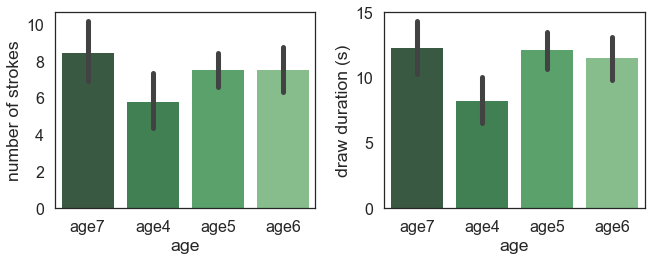

In [26]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
seq = np.arange(4,10)
sns.barplot(data=X,x='age',y='num_strokes', palette="Greens_d")
plt.ylabel('number of strokes')

plt.subplot(1,3,2)
seq = np.arange(4,10)

sns.barplot(data=X,x='age',y='draw_duration', palette="Greens_d")
plt.ylabel('draw duration (s)')

plt.tight_layout()

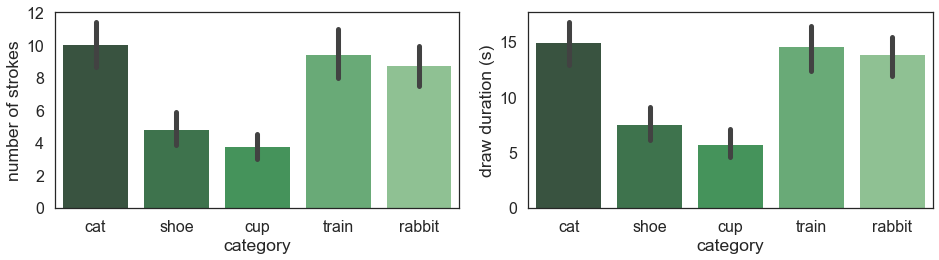

In [27]:
plt.figure(figsize=(20,4))

plt.subplot(1,3,1)
seq = np.arange(4,10)
sns.barplot(data=X,x='category',y='num_strokes',palette="Greens_d")
plt.ylabel('number of strokes')

plt.subplot(1,3,2)
seq = np.arange(4,10)

sns.barplot(data=X,x='category',y='draw_duration', palette="Greens_d")
plt.ylabel('draw duration (s)')

# plt.subplot(1,3,3)
# seq = np.arange(4,10)
# sns.barplot(data=X,x='age',y='mean_intensity',order=seq,palette="Greens_d")
# plt.ylabel('mean pixel intensity')

plt.tight_layout()

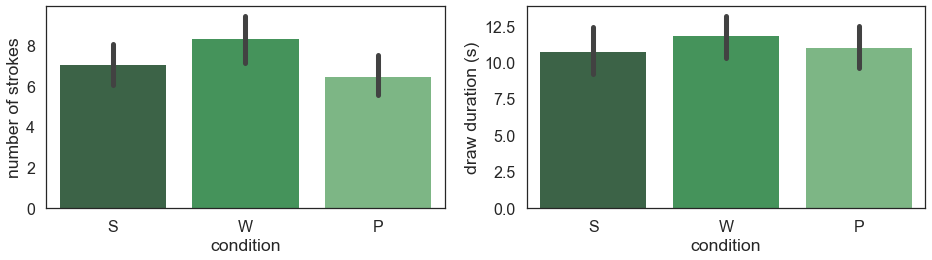

In [28]:
plt.figure(figsize=(20,4))

plt.subplot(1,3,1)
seq = np.arange(4,10)
sns.barplot(data=X,x='condition',y='num_strokes',palette="Greens_d")
plt.ylabel('number of strokes')

plt.subplot(1,3,2)
seq = np.arange(4,10)

sns.barplot(data=X,x='condition',y='draw_duration', palette="Greens_d")
plt.ylabel('draw duration (s)')

plt.tight_layout()

In [ ]:
# categories = [i for i in os.listdir('sketches') if i != '.DS_Store']
# num_ims = 0
# ims_per_cat = []
# for c in categories:
#     num_ims += len([i for i  in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store'])
#     ims_per_cat.append(len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store']))
    
# print num_ims
# print ims_per_cat



# categories = [i for i in os.listdir('sketches') if i != '.DS_Store']
# num_ims = 0
# ims_per_cat = []
# for c in categories:
#     num_ims += len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store'])
#     ims_per_cat.append(len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store']))
    
# print num_ims
# print ims_per_cat